# Import

In [21]:
import os
import cv2
import csv
import math
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.signal import savgol_filter

# Global variables

In [2]:
KeypointsROOT = "data/"
VIDEOROOT = "data/"

# TIMESTAMP_PATH = "_timeStamp.csv"
# TIMESTAMP_PATH = "_timeStamp_0831.csv" ### [update] 2023/08/31
TIMESTAMP_PATH = "_timeStamp_0916.csv" ### [update] 2023/09/16

VIDEOTYPE_PATH = "_videoType.csv"

In [3]:
LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398]
RIGHT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246]

LEFT_IRIS = [474, 475, 476, 477] ### 右, 上, 左, 下
RIGHT_IRIS = [469, 470, 471, 472] ### 右, 上, 左, 下

LEFT_EYEBROW =[336, 296, 334, 293, 300, 276, 283, 282, 295, 285]
RIGHT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]

COLOR_BLACK = (0, 0, 0)
COLOR_WHITE = (255, 255, 255)
COLOR_RED = (0, 0, 255)
COLOR_GREEN = (0, 255, 0)
COLOR_BLUE = (255, 0, 0)
COLOR_PINK = (147,20,255)
COLOR_YELLOW = (0,255,255)
COLOR_CYAN = (255,255,0)
COLOR_MAGENTA = (255,0,255)
COLOR_GRAY = (128,128,128)
COLOR_PURPLE = (128,0,128)
COLOR_ORANGE = (0,165,255)

In [4]:
timeStamp_dict = {}
allID_list = []
invalidID_list = []

# GPU Setting

In [5]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Load Timestamp

In [7]:
timeStamp_dict = {}

def load_timestamp():
    if not os.path.exists(TIMESTAMP_PATH):
        print(f'[Timestamp] CSV does not exit.')
    else:
        df = pd.read_csv(TIMESTAMP_PATH)
        df = df.fillna(0)
        n_row, n_col = df.shape[0], df.shape[1]
        
        data_dict = {}
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            start1 = int(float(df.iloc[idx, 1]))
            end1 = int(float(df.iloc[idx, 2]))
            
            if start1==0 and end1==0:
                continue
            else:
                data_dict[pid] = {}
                data_dict[pid]["1-start"] = start1
                data_dict[pid]["1-end"] = end1
    return data_dict


timeStamp_dict = load_timestamp()

In [8]:
print(f'=== number of pid in timeStamp CSV file: {len(timeStamp_dict)} ===\n')
# print(f'Without pid: 41, 96, 97, 98, 99, 100\n')
print(f'Without pid: 41\n') ### [update] 2023/09/16

for key in timeStamp_dict:
    print(f'key:{key}, {timeStamp_dict[key]}')

=== number of pid in timeStamp CSV file: 99 ===

Without pid: 41

key:1, {'1-start': 67, '1-end': 119}
key:2, {'1-start': 111, '1-end': 149}
key:3, {'1-start': 62, '1-end': 96}
key:4, {'1-start': 111, '1-end': 150}
key:5, {'1-start': 119, '1-end': 168}
key:6, {'1-start': 57, '1-end': 79}
key:7, {'1-start': 62, '1-end': 84}
key:8, {'1-start': 93, '1-end': 110}
key:9, {'1-start': 61, '1-end': 75}
key:10, {'1-start': 106, '1-end': 128}
key:11, {'1-start': 145, '1-end': 160}
key:12, {'1-start': 73, '1-end': 109}
key:13, {'1-start': 71, '1-end': 193}
key:14, {'1-start': 59, '1-end': 79}
key:15, {'1-start': 66, '1-end': 108}
key:16, {'1-start': 91, '1-end': 139}
key:17, {'1-start': 85, '1-end': 137}
key:18, {'1-start': 90, '1-end': 118}
key:19, {'1-start': 84, '1-end': 148}
key:20, {'1-start': 71, '1-end': 101}
key:21, {'1-start': 64, '1-end': 95}
key:22, {'1-start': 87, '1-end': 118}
key:23, {'1-start': 82, '1-end': 118}
key:24, {'1-start': 80, '1-end': 231}
key:25, {'1-start': 71, '1-end':

# Load ID

In [9]:
def loadID(KeypointsROOT):
    tmp_id = []
    for pid in list(os.listdir(KeypointsROOT)):
        if int(pid) in timeStamp_dict:
            tmp_id.append(pid)
        if (int(pid) in timeStamp_dict)==False:
            print(f'pid [{int(pid)}] not in timeStamp_dict.')
    return tmp_id
    
allID_list = loadID(KeypointsROOT)

In [10]:
print(f'=== number of valid pid: {len(allID_list)} subjects. ===\n')

print(allID_list)

=== number of valid pid: 99 subjects. ===

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


# Load video type

In [11]:
videoType_dict = {}

def load_videotype():
    if not os.path.exists(VIDEOTYPE_PATH):
        print(f'[VideoType] CSV does not exit.')
    else:
        df = pd.read_csv(VIDEOTYPE_PATH)
        n_row, n_col = df.shape[0], df.shape[1]
        
        data_dict = {}
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            videotype = int(df.iloc[idx, 1])
            
            data_dict[pid] = {}
            data_dict[pid]["type"] = videotype
    return data_dict

    
videoType_dict = load_videotype()

In [12]:
print(f'Number of subjects in videoType_dict: {len(videoType_dict)} subjects.\n')

print(videoType_dict)

Number of subjects in videoType_dict: 99 subjects.

{1: {'type': 1}, 2: {'type': 1}, 3: {'type': 1}, 4: {'type': 1}, 5: {'type': 1}, 6: {'type': 1}, 7: {'type': 1}, 8: {'type': 1}, 9: {'type': 1}, 10: {'type': 1}, 100: {'type': 2}, 11: {'type': 1}, 12: {'type': 1}, 13: {'type': 1}, 14: {'type': 1}, 15: {'type': 1}, 16: {'type': 1}, 17: {'type': 1}, 18: {'type': 1}, 19: {'type': 1}, 20: {'type': 1}, 21: {'type': 1}, 22: {'type': 1}, 23: {'type': 1}, 24: {'type': 1}, 25: {'type': 1}, 26: {'type': 1}, 27: {'type': 1}, 28: {'type': 1}, 29: {'type': 1}, 30: {'type': 1}, 31: {'type': 1}, 32: {'type': 1}, 33: {'type': 1}, 34: {'type': 1}, 35: {'type': 1}, 36: {'type': 1}, 37: {'type': 1}, 38: {'type': 1}, 39: {'type': 1}, 40: {'type': 1}, 42: {'type': 1}, 43: {'type': 1}, 44: {'type': 1}, 45: {'type': 1}, 46: {'type': 1}, 47: {'type': 1}, 48: {'type': 1}, 49: {'type': 1}, 50: {'type': 1}, 51: {'type': 1}, 52: {'type': 1}, 53: {'type': 2}, 54: {'type': 2}, 55: {'type': 2}, 56: {'type': 2}, 57:

# Modify file

### Change file name

In [6]:
def change_file_name(KeypointsROOT, pidList):
    for pid in pidList:
        old_file_name = KeypointsROOT + pid + '/timeSeries_DataList.csv'
        new_file_name = KeypointsROOT + pid + '/timeSeries_data1.csv'

        if not os.path.exists(old_file_name):
            print(f'[{pid}] csv file does not exist.')
        else:
            os.rename(old_file_name, new_file_name)
    

change_file_name(KeypointsROOT, allID)

### Move file

In [8]:
import shutil

def move_file(VIDEOROOT, pidList):
    for pid in pidList:
        if int(pid) in timeStamp_dict:
            csv1 = VIDEOROOT + pid + '/timeSeries_data1.csv'
            csv2 = VIDEOROOT + pid + '/timeSeries_data1_2.csv'
            csv3 = VIDEOROOT + pid + '/timeSeries_data1_2_normalized.csv'

            if not os.path.exists(csv1) or not os.path.exists(csv2) or not os.path.exists(csv3):
                print(f'Something wrong with [pid {pid}].')
            else:
                print(f'pid {pid}')
                new_csv1 = VIDEOROOT + pid + '/Description1/timeSeries_data1.csv'
                new_csv2 = VIDEOROOT + pid + '/Description1/timeSeries_data1_2.csv'
                new_csv3 = VIDEOROOT + pid + '/Description1/timeSeries_data1_2_normalized.csv'
                shutil.move(csv1, new_csv1)
                shutil.move(csv2, new_csv2)
                shutil.move(csv3, new_csv3)
                

move_file(VIDEOROOT, allID)

Something wrong with [pid 01].
pid 02
pid 03
pid 04
pid 05
pid 06
pid 07
pid 08
pid 09
pid 12
pid 13
pid 14
pid 15
pid 16
pid 17
pid 18
pid 19
pid 20
pid 21
pid 22
pid 23
pid 24
pid 25
pid 26
pid 27
pid 28
pid 29
pid 30
pid 31
pid 32
pid 33
pid 34
pid 35
pid 36
pid 37
pid 38
pid 39
pid 40
pid 42
pid 43
pid 44
pid 45
pid 46
pid 47
pid 48
pid 49
pid 50
pid 51
pid 52
pid 53
pid 54
pid 55
pid 56
pid 57
pid 58
pid 59
pid 62
pid 63
pid 64
pid 65
pid 66
pid 67
pid 68
pid 69
pid 70
pid 71
pid 72
pid 73
pid 74
pid 75
pid 76
pid 77
pid 78
pid 79
pid 80
pid 81
pid 82
pid 83
pid 84
pid 86
pid 87
pid 88
pid 89
pid 90
pid 91
pid 92
pid 93
pid 94
pid 95


### Delete unused file

In [10]:
import shutil

def deleteVideo(VIDEOROOT, pidList):
    for pid in pidList:
        video_path = VIDEOROOT + pid + '/eyeVideo_eyebrow.mp4'
        if not os.path.exists(video_path):
            print(f'{pid} no video file')
        else:
            os.remove(video_path)
            

deleteVideo(VIDEOROOT, allID)

01 no video file
50 no video file


# Image - MediaPipe 

In [7]:
def landmarksDetection(image, results, isDraw=False):
    imgHeight, imgWidth= image.shape[:2]

    # list[(x,y), (x,y)....]: the list of tuples for each landmarks 
    mesh_coord = [(int(point.x * imgWidth), int(point.y * imgHeight)) for point in results.multi_face_landmarks[0].landmark]
    if isDraw:
        [cv2.circle(image, p, 2, COLOR_GREEN, -1) for p in mesh_coord]
    return mesh_coord


def preProcessing(image):
    fImg = image.astype(np.float32)
    fImg = fImg / 255.0
    hlsImg = cv2.cvtColor(fImg, cv2.COLOR_BGR2HLS)
    hlsCopy = np.copy(hlsImg)
    lightness = 30 
    saturation = 30 
   
    hlsCopy[:, :, 1] = (1 + lightness / 100.0) * hlsCopy[:, :, 1]
    hlsCopy[:, :, 1][hlsCopy[:, :, 1] > 1] = 1  
   
    hlsCopy[:, :, 2] = (1 + saturation / 100.0) * hlsCopy[:, :, 2]
    hlsCopy[:, :, 2][hlsCopy[:, :, 2] > 1] = 1  
     
    result = cv2.cvtColor(hlsCopy, cv2.COLOR_HLS2BGR)
    result = ((result * 255).astype(np.uint8))
    return result


def draw_line(image, coords, ptsList):
    for pt in ptsList:
        x = coords[pt][0]
        y = coords[pt][1]
        cv2.circle(image, [x, y], 2, COLOR_BLUE, -1)
    pt1 = coords[ptsList[0]]
    pt2 = coords[ptsList[1]]
    cv2.line(image, pt1, pt2, COLOR_CYAN, 1)
    return image

### Original Image

In [33]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    image_path = 'test-image/image1.jpg'
    image_path_output = 'test-image/image1-0605.jpg'
    print(image_path)
    
    if not os.path.exists(image_path):
        print(f'Image does not exist.')
    else:
        img = cv2.imread(image_path)
        
        imgHeight = img.shape[0]
        imgWidth = img.shape[1]
        
        targetWidth = 1280
        targetHeight = 720
        
        img = cv2.resize(img, (int(720/imgHeight*imgWidth), 720), interpolation=cv2.INTER_NEAREST)
        img = preProcessing(img)
        
        ### add a black background on the original image
        ### 640x480 -> 960x720 -> 1280x720
        if img.shape[1] != targetWidth:
            new_img = np.zeros((targetHeight, targetWidth, 3), dtype = "uint8")

            xOffset = int((targetWidth-img.shape[1])/2)
            yOffset = 0
    
            new_img[yOffset:yOffset+img.shape[0], xOffset:xOffset+img.shape[1]] = img
            img = new_img
            
        results = face_mesh.process(img)
        if results.multi_face_landmarks:
            meshCoord = landmarksDetection(img, results, False)
            img = draw_line(img, meshCoord, [6, 10])
            img = draw_line(img, meshCoord, [6, 162])
            img = draw_line(img, meshCoord, [6, 389])
            img = draw_line(img, meshCoord, [162, 389])
            
        cv2.imwrite(image_path_output, img)

test-image/image1.jpg


### Cropped Image

In [16]:
def draw_eye(image, coords, indices):
    for idx in indices:
        x = coords[idx][0]
        y = coords[idx][1]
        cv2.circle(image, [x, y], 2, COLOR_BLUE, -1)

In [24]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    image_path = 'test-image/image3-0605-faceDetection.jpg'
    image_path_output = 'test-image/image3-0605-faceDetection-eyes.jpg'
    print(image_path)
    
    if not os.path.exists(image_path):
        print(f'Image does not exist.')
    else:
        img = cv2.imread(image_path)
        
        h, w = img.shape[0], img.shape[1]
        
        targetWidth = 450
        targetHeight = 540
        
        img = cv2.resize(img, (int(targetHeight/h*w), targetHeight), interpolation=cv2.INTER_NEAREST)
        # img = preProcessing(img)
        
        ### add a black background on the original image
        ### 350x420 -> ??x540 -> 450x540
        if img.shape[1] != targetWidth:
            new_img = np.zeros((targetHeight, targetWidth, 3), dtype = "uint8")

            xOffset = int((targetWidth-img.shape[1])/2)
            yOffset = 0
    
            new_img[yOffset:yOffset+img.shape[0], xOffset:xOffset+img.shape[1]] = img
            img = new_img
            
        results = face_mesh.process(img)
        if results.multi_face_landmarks:
            meshCoord = landmarksDetection(img, results, False)
            image = draw_eye(img, meshCoord, LEFT_EYE)
            image = draw_eye(img, meshCoord, RIGHT_EYE)
            
            
        cv2.imwrite(image_path_output, img)

test-image/image3-0605-faceDetection.jpg


# Video - MediaPipe

In [36]:
def landmarksDetection(image, results, isDraw=False):
    imgHeight, imgWidth= image.shape[:2]

    # list[(x,y), (x,y)....]: the list of tuples for each landmarks 
    mesh_coord = [(int(point.x * imgWidth), int(point.y * imgHeight)) for point in results.multi_face_landmarks[0].landmark]
    if isDraw:
        [cv2.circle(image, p, 2, COLOR_GREEN, -1) for p in mesh_coord]
    return mesh_coord

def draw_keypoints(image, coords, indices):
    for idx in indices:
        x = coords[idx][0]
        y = coords[idx][1]
        cv2.circle(image, [x, y], 2, COLOR_CYAN, -1)
    return image

In [42]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    for pid in allID:
        # if int(pid) in timeStamp_dict:
        if int(pid) in timeStamp_dict and pid>"04" and pid<"24":
            # video_path = VIDEOROOT + pid + '/eyeVideo.mp4'
            video_path = VIDEOROOT + pid + '/Description1/clip1_cropFace.mp4'
            # video_output_path = VIDEOROOT + pid + '/Description1/clip1_cropFace_output.mp4'
            print(video_path)

            if not os.path.exists(video_path):
                print(f'====== Pid [{pid}] eyeVideo does NOT exist. ======')
            else:
                ### Load video
                cap = cv2.VideoCapture(video_path)

                nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                frameWidth, frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                FPS = cap.get(cv2.CAP_PROP_FPS)
                
                video_writer = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*"mp4v"), FPS, (frameWidth, frameHeight))

                ### Get Threshold
                noFace = 0

                for frame in tqdm(range(nFrames), total=nFrames):
                    ret, image = cap.read()
                    # print(type(image))
                    if ret == False:
                        print(ret)
                        break
                    # image = cv2.resize(image, (1280, 720), interpolation=cv2.INTER_NEAREST)
                    # image = preProcessing(image)

                    results = face_mesh.process(image)

                    if results.multi_face_landmarks:
                        meshCoord = landmarksDetection(image, results, False)
                        image = draw_keypoints(image, meshCoord, LEFT_EYE)
                        image = draw_keypoints(image, meshCoord, RIGHT_EYE)
                        image = draw_keypoints(image, meshCoord, LEFT_EYEBROW)
                        image = draw_keypoints(image, meshCoord, RIGHT_EYEBROW)
                        video_writer.write(image)

                        # data = get_Time_Series_Data_Iris(meshCoord, LEFT_EYEBROW, RIGHT_EYEBROW, LEFT_IRIS, RIGHT_IRIS)
                        # data = get_Time_Series_Data_Eye(meshCoord, LEFT_EYEBROW, RIGHT_EYEBROW, LEFT_EYE, RIGHT_EYE)
                    else:
                        noFace += 1
                        if noFace > 10*30:
                            print(f'[Info] {pid} detection failed.')
                            break

                cap.release()
                video_writer.release()
                cv2.destroyAllWindows()

data/05/Description1/clip1_cropFace.mp4


100%|██████████| 1500/1500 [00:18<00:00, 79.36it/s]


data/06/Description1/clip1_cropFace.mp4


100%|██████████| 690/690 [00:08<00:00, 77.18it/s]


data/07/Description1/clip1_cropFace.mp4


100%|██████████| 690/690 [00:08<00:00, 81.79it/s]


data/08/Description1/clip1_cropFace.mp4


100%|██████████| 540/540 [00:07<00:00, 76.58it/s]


data/09/Description1/clip1_cropFace.mp4


100%|██████████| 450/450 [00:05<00:00, 78.24it/s]


data/12/Description1/clip1_cropFace.mp4


100%|██████████| 1110/1110 [00:14<00:00, 78.08it/s]


data/13/Description1/clip1_cropFace.mp4


100%|██████████| 3690/3690 [00:47<00:00, 77.90it/s]


data/14/Description1/clip1_cropFace.mp4


100%|██████████| 630/630 [00:07<00:00, 79.18it/s]


data/15/Description1/clip1_cropFace.mp4


100%|██████████| 1290/1290 [00:16<00:00, 76.81it/s]


data/16/Description1/clip1_cropFace.mp4


 44%|████▍     | 644/1470 [00:06<00:07, 103.47it/s]


[Info] 16 detection failed.
data/17/Description1/clip1_cropFace.mp4


100%|██████████| 1590/1590 [00:19<00:00, 80.77it/s]


data/18/Description1/clip1_cropFace.mp4


100%|██████████| 870/870 [00:10<00:00, 81.10it/s]


data/19/Description1/clip1_cropFace.mp4


100%|██████████| 1950/1950 [00:24<00:00, 79.34it/s]


data/20/Description1/clip1_cropFace.mp4


100%|██████████| 930/930 [00:11<00:00, 80.98it/s]


data/21/Description1/clip1_cropFace.mp4


100%|██████████| 960/960 [00:11<00:00, 80.96it/s]


data/22/Description1/clip1_cropFace.mp4


100%|██████████| 960/960 [00:12<00:00, 75.83it/s]


data/23/Description1/clip1_cropFace.mp4


100%|██████████| 1110/1110 [00:14<00:00, 78.49it/s]


# Time Series Data - MediaPipe

In [12]:
def landmarksDetection(image, results, isDraw=False):
    imgHeight, imgWidth= image.shape[:2]

    # list[(x,y), (x,y)....]: the list of tuples for each landmarks 
    mesh_coord = [(int(point.x * imgWidth), int(point.y * imgHeight)) for point in results.multi_face_landmarks[0].landmark]
    if isDraw:
        [cv2.circle(image, p, 2, COLOR_GREEN, -1) for p in mesh_coord]
    return mesh_coord


def preProcessing(image):
    fImg = image.astype(np.float32)
    fImg = fImg / 255.0
    hlsImg = cv2.cvtColor(fImg, cv2.COLOR_BGR2HLS)
    hlsCopy = np.copy(hlsImg)
    lightness = 30 
    saturation = 30 
   
    hlsCopy[:, :, 1] = (1 + lightness / 100.0) * hlsCopy[:, :, 1]
    hlsCopy[:, :, 1][hlsCopy[:, :, 1] > 1] = 1  
   
    hlsCopy[:, :, 2] = (1 + saturation / 100.0) * hlsCopy[:, :, 2]
    hlsCopy[:, :, 2][hlsCopy[:, :, 2] > 1] = 1  
     
    result = cv2.cvtColor(hlsCopy, cv2.COLOR_HLS2BGR)
    result = ((result * 255).astype(np.uint8))
    return result


def calculate_distance(pt1_x, pt1_y, pt2_x, pt2_y):
    pt1 = [pt1_x, pt1_y]
    pt2 = [pt2_x, pt2_y]
    # dist = math.dist(pt1, pt2)
    dist = ((pt1_x - pt2_x)**2 + (pt1_y - pt2_y)**2)**0.5
    return round(dist, 2)    

In [13]:
def get_time_series_data_Iris(coords, left_Eyebrow_list, right_Eyebrow_list, left_Iris_list, right_Iris_list):
    n_landmarks = len(coords)
    
    ### LEFT_EYEBROW =[336, 296, 334, 293, 300, 276, 283, 282, 295, 285]
    pt1_x, pt1_y = int((coords[336][0]+coords[285][0])/2), int((coords[336][1]+coords[285][1])/2)
    pt2_x, pt2_y = int((coords[334][0]+coords[282][0])/2), int((coords[334][1]+coords[282][1])/2)
    pt3_x, pt3_y = int((coords[300][0]+coords[276][0])/2) , int((coords[300][1]+coords[276][1])/2)
    
    ### RIGHT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
    pt4_x, pt4_y = int((coords[107][0]+coords[55][0])/2) , int((coords[107][1]+coords[55][1])/2)
    pt5_x, pt5_y = int((coords[105][0]+coords[52][0])/2) , int((coords[105][1]+coords[52][1])/2)
    pt6_x, pt6_y = int((coords[70][0]+coords[46][0])/2) , int((coords[70][1]+coords[46][1])/2)
    
    ### center of the eyebrow
    l_center_x = int((coords[285][0]+coords[295][0]+coords[282][0]+coords[283][0]+coords[276][0])/5)
    l_center_y = int((coords[285][1]+coords[295][1]+coords[282][1]+coords[283][1]+coords[276][1])/5)
    r_center_x = int((coords[55][0]+coords[65][0]+coords[52][0]+coords[53][0]+coords[46][0])/5)
    r_center_y = int((coords[55][1]+coords[65][1]+coords[52][1]+coords[53][1]+coords[46][1])/5)
    
    l_upIris_x, l_upIris_y = int(coords[475][0]), int(coords[475][1])
    r_upIris_x, r_upIris_y = int(coords[470][0]), int(coords[470][1])
    l_downIris_x, l_downIris_y = int(coords[477][0]), int(coords[477][1])
    r_downIris_x, r_downIris_y = int(coords[472][0]), int(coords[472][1])
    
    ### vertical distance between [eyebrow and up_iris]
    dist1 = calculate_distance(l_upIris_x, l_upIris_y, l_center_x, l_center_y)
    dist2 = calculate_distance(r_upIris_x, r_upIris_y, r_center_x, r_center_y)
    
    ### vertical distance between [up_eye and down_iris]
    dist3 = calculate_distance(l_upIris_x, l_upIris_y, l_downIris_x, l_downIris_y)
    dist4 = calculate_distance(r_upIris_x, r_upIris_y, r_downIris_x, r_downIris_y)
    
    ### 16 features
    data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x, pt4_y, pt5_x, pt5_y, pt6_x, pt6_y, dist1, dist2, dist3, dist4]
    
    return data


def get_time_series_data_Eye(coords, left_Eyebrow_list, right_Eyebrow_list, left_Eye_list, right_Eye_list):
    n_landmarks = len(coords)
    
    ### LEFT_EYEBROW =[336, 296, 334, 293, 300, 276, 283, 282, 295, 285]
    pt1_x, pt1_y = int((coords[336][0]+coords[285][0])/2), int((coords[336][1]+coords[285][1])/2)
    pt2_x, pt2_y = int((coords[334][0]+coords[282][0])/2), int((coords[334][1]+coords[282][1])/2)
    pt3_x, pt3_y = int((coords[300][0]+coords[276][0])/2) , int((coords[300][1]+coords[276][1])/2)
    
    ### RIGHT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
    pt4_x, pt4_y = int((coords[107][0]+coords[55][0])/2) , int((coords[107][1]+coords[55][1])/2)
    pt5_x, pt5_y = int((coords[105][0]+coords[52][0])/2) , int((coords[105][1]+coords[52][1])/2)
    pt6_x, pt6_y = int((coords[70][0]+coords[46][0])/2) , int((coords[70][1]+coords[46][1])/2)
    
    ### center of the eyebrow
    l_center_x = int((coords[285][0]+coords[295][0]+coords[282][0]+coords[283][0]+coords[276][0])/5)
    l_center_y = int((coords[285][1]+coords[295][1]+coords[282][1]+coords[283][1]+coords[276][1])/5)
    r_center_x = int((coords[55][0]+coords[65][0]+coords[52][0]+coords[53][0]+coords[46][0])/5)
    r_center_y = int((coords[55][1]+coords[65][1]+coords[52][1]+coords[53][1]+coords[46][1])/5)
    
    ### LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398]
    ### RIGHT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246]    
    l_upEye_x, l_upEye_y = int((coords[385][0]+coords[386][0])/2) , int((coords[385][1]+coords[386][1])/2)
    l_downEye_x, l_downEye_y = int((coords[380][0]+coords[374][0]+coords[373][0])/3) , int((coords[380][1]+coords[374][1]+coords[373][1])/3)
    r_upEye_x, r_upEye_y = int((coords[158][0]+coords[159][0])/2) , int((coords[158][1]+coords[159][1])/2)
    r_downEye_x, r_downEye_y = int((coords[153][0]+coords[145][0]+coords[144][0])/3) , int((coords[153][1]+coords[145][1]+coords[144][1])/3)
    
    
    ### vertical distance between [eyebrow and up_eye]
    dist1 = calculate_distance(l_upEye_x, l_upEye_y, l_center_x, l_center_y)
    dist2 = calculate_distance(r_upEye_x, r_upEye_y, r_center_x, r_center_y)
    
    ### vertical distance between [up_eye and down_eye]
    dist3 = calculate_distance(l_upEye_x, l_upEye_y, l_downEye_x, l_downEye_y)
    dist4 = calculate_distance(r_upEye_x, r_upEye_y, r_downEye_x, r_downEye_y)

    ### 16 features
    data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x, pt4_y, pt5_x, pt5_y, pt6_x, pt6_y, dist1, dist2, dist3, dist4]
    
    return data



def get_time_series_data_singleSide(coords, eyebrowList, eyeList, irisList, flag):
    n_landmarks = len(coords)
    
    if flag == "left":
        ### LEFT_EYEBROW =[336, 296, 334, 293, 300, 276, 283, 282, 295, 285]\
        ### LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398]
        ### LEFT_IRIS = [474, 475, 476, 477] ### 右, 上, 左, 下
        
        ### Eyebrow
        pt1_x, pt1_y = int((coords[336][0]+coords[285][0])/2), int((coords[336][1]+coords[285][1])/2)
        pt2_x, pt2_y = int((coords[334][0]+coords[282][0])/2), int((coords[334][1]+coords[282][1])/2)
        pt3_x, pt3_y = int((coords[300][0]+coords[276][0])/2) , int((coords[300][1]+coords[276][1])/2)
        
        ### Get the center of eyebrow from 10 points
        eyebrow_center_x = int((coords[285][0]+coords[295][0]+coords[282][0]+coords[283][0]+coords[276][0]+coords[336][0]+coords[296][0]+coords[334][0]+coords[293][0]+coords[300][0]) / 10)
        eyebrow_center_y = int((coords[285][1]+coords[295][1]+coords[282][1]+coords[283][1]+coords[276][1]+coords[336][1]+coords[296][1]+coords[334][1]+coords[293][1]+coords[300][1]) / 10)
        
        dist1 = calculate_distance(eyebrow_center_x, eyebrow_center_y, coords[475][0], coords[475][1]) ### vertical distance between [eyebrow and up_iris]
        dist2 = calculate_distance(coords[475][0], coords[475][1], coords[477][0], coords[477][1]) ### vertical distance between [up_iris and down_iris]
        # print(f'dist1: {dist1}, dist2: {dist2}')
        
        data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, dist1, dist2]
        
    elif flag == "right":
        ### RIGHT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
        ### RIGHT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246]
        ### RIGHT_IRIS = [469, 470, 471, 472] ### 右, 上, 左, 下
        
        ### Eyebrow
        pt1_x, pt1_y = int((coords[107][0]+coords[55][0])/2) , int((coords[107][1]+coords[55][1])/2)
        pt2_x, pt2_y = int((coords[105][0]+coords[52][0])/2) , int((coords[105][1]+coords[52][1])/2)
        pt3_x, pt3_y = int((coords[70][0]+coords[46][0])/2) , int((coords[70][1]+coords[46][1])/2)
        
        ### Get the center of eyebrow from 10 points
        eyebrow_center_x = int((coords[55][0]+coords[65][0]+coords[52][0]+coords[53][0]+coords[46][0]+coords[107][0]+coords[66][0]+coords[105][0]+coords[63][0]+coords[70][0]) / 10)
        eyebrow_center_y = int((coords[55][1]+coords[65][1]+coords[52][1]+coords[53][1]+coords[46][1]+coords[107][1]+coords[66][1]+coords[105][1]+coords[63][1]+coords[70][1]) / 10)
        
        dist1 = calculate_distance(eyebrow_center_x, eyebrow_center_y, coords[470][0], coords[470][1]) ### vertical distance between [eyebrow and up_iris]
        dist2 = calculate_distance(coords[475][0], coords[475][1], coords[472][0], coords[472][1]) ### vertical distance between [up_iris and down_iris]
        print(f'dist1: {dist1}, dist2: {dist2}')
        
        data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, dist1, dist2]
    
    else:
        print(f'Something wrong with [flag].')
        
    return data



def get_time_series_data_eyebrow_only(coords, l_eyebrowList, r_eyebrowList):
    n_landmarks = len(coords)

    ### [Left] Eyebrow = [336, 296, 334, 293, 300, 276, 283, 282, 295, 285]
    pt1_x, pt1_y = int((coords[336][0]+coords[285][0])/2), int((coords[336][1]+coords[285][1])/2)
    pt2_x, pt2_y = int((coords[334][0]+coords[282][0])/2), int((coords[334][1]+coords[282][1])/2)
    pt3_x, pt3_y = int((coords[300][0]+coords[276][0])/2) , int((coords[300][1]+coords[276][1])/2)
    
    ### [Right] Eyebrow = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
    pt4_x, pt4_y = int((coords[107][0]+coords[55][0])/2) , int((coords[107][1]+coords[55][1])/2)
    pt5_x, pt5_y = int((coords[105][0]+coords[52][0])/2) , int((coords[105][1]+coords[52][1])/2)
    pt6_x, pt6_y = int((coords[70][0]+coords[46][0])/2) , int((coords[70][1]+coords[46][1])/2)
    
    data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x, pt4_y, pt5_x, pt5_y, pt6_x, pt6_y]
    return data


def get_time_series_data_eye_only(coords, l_eyebrowList, r_eyebrowList):
    n_landmarks = len(coords)
    
    ### [Left] Eye = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398]
    pt1_x, pt1_y = int((coords[398][0]+coords[362][0]+coords[382][0])/3), int((coords[398][1]+coords[362][1]+coords[382][1])/3)
    pt2_x, pt2_y = int((coords[466][0]+coords[263][0]+coords[249][0])/3), int((coords[466][1]+coords[263][1]+coords[249][1])/3)
    pt3_x, pt3_y = int((coords[386][0]+coords[374][0])/2), int((coords[386][1]+coords[374][1])/2)
    
    ### [Right] Eye = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246]
    pt4_x, pt4_y = int((coords[173][0]+coords[133][0]+coords[155][0])/3), int((coords[173][1]+coords[133][1]+coords[155][1])/3)
    pt5_x, pt5_y = int((coords[246][0]+coords[33][0]+coords[7][0])/3), int((coords[246][1]+coords[33][1]+coords[7][1])/3)
    pt6_x, pt6_y = int((coords[159][0]+coords[145][0])/2), int((coords[159][1]+coords[145][1])/2)

    data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x, pt4_y, pt5_x, pt5_y, pt6_x, pt6_y]
    return data


def get_time_series_data_eye_and_eyebrow(coords, l_eyebrowList, r_eyebrowList, l_eyeList, r_eyeList):
    ### [Left] Eyebrow = [336, 296, 334, 293, 300, 276, 283, 282, 295, 285]
    pt1_x, pt1_y = int((coords[336][0]+coords[285][0])/2), int((coords[336][1]+coords[285][1])/2)
    pt2_x, pt2_y = int((coords[334][0]+coords[282][0])/2), int((coords[334][1]+coords[282][1])/2)
    pt3_x, pt3_y = int((coords[300][0]+coords[276][0])/2) , int((coords[300][1]+coords[276][1])/2)
    
    ### [Right] Eyebrow = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
    pt4_x, pt4_y = int((coords[107][0]+coords[55][0])/2) , int((coords[107][1]+coords[55][1])/2)
    pt5_x, pt5_y = int((coords[105][0]+coords[52][0])/2) , int((coords[105][1]+coords[52][1])/2)
    pt6_x, pt6_y = int((coords[70][0]+coords[46][0])/2) , int((coords[70][1]+coords[46][1])/2)
    
    ### [Left] Eye = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398]
    pt7_x, pt7_y = int((coords[398][0]+coords[362][0]+coords[382][0])/3), int((coords[398][1]+coords[362][1]+coords[382][1])/3)
    pt8_x, pt8_y = int((coords[466][0]+coords[263][0]+coords[249][0])/3), int((coords[466][1]+coords[263][1]+coords[249][1])/3)
    pt9_x, pt9_y = int((coords[386][0]+coords[374][0])/2), int((coords[386][1]+coords[374][1])/2)
    
    ### [Right] Eye = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246]
    pt10_x, pt10_y = int((coords[173][0]+coords[133][0]+coords[155][0])/3), int((coords[173][1]+coords[133][1]+coords[155][1])/3)
    pt11_x, pt11_y = int((coords[246][0]+coords[33][0]+coords[7][0])/3), int((coords[246][1]+coords[33][1]+coords[7][1])/3)
    pt12_x, pt12_y = int((coords[159][0]+coords[145][0])/2), int((coords[159][1]+coords[145][1])/2)

    data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x, pt4_y, pt5_x, pt5_y, pt6_x, pt6_y, pt7_x, pt7_y, pt8_x, pt8_y, pt9_x, pt9_y, pt10_x, pt10_y, pt11_x, pt11_y, pt12_x, pt12_y]
    return data

In [14]:
def put_image_in_center(image, width, height):
    w, h = image.shape[1], image.shape[0]
    
    new_image = np.zeros((height, width, 3), dtype = "uint8")
    x_offset = int(width/2 - w/2) ### 1280/2-640/2=640-320=320
    y_offset = int(height/2 - h/2) ### 720/2-480/2=360-240=120
    new_image[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return new_image


def write_to_csv_file(csv_output_path, dataList):
    with open(csv_output_path, 'w', newline='') as outfile:
        csv_writer = csv.writer(outfile)
        csv_writer.writerows(dataList)

In [25]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    for pid in allID_list: # for folder in list(os.listdir(VIDEOROOT)):
        # if pid!="60" and pid!="61" and pid!="85":
        if pid == "100":
            video_path = VIDEOROOT + pid + '/Description1/clip1.mp4'

            # csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_data1.csv'
            # csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_data2.csv'
            # csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_data3.csv' ### [Eyebrow only]
            csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_data4.csv' ### [Eye only]
            # csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_data5.csv' ### [Eyebrow + Eye]
            
            
            # csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_left_data1.csv'
            # csv_output_path = VIDEOROOT + pid + '/Description1/timeSeries_right_data1.csv'

            if not os.path.exists(video_path):
                print(f'====== Pid [{pid}] clip1 does NOT exist. ======')
            else:
                print(f'pid: {pid}, {video_path}')

                ### Load video
                cap = cv2.VideoCapture(video_path)
                n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                frameWidth, frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                FPS = cap.get(cv2.CAP_PROP_FPS)

                noFace = 0
                
                dataList = []
                isWriteCSV = True
                for frame in tqdm(range(n_frames), total=n_frames):
                    ret, image = cap.read()
                    if ret == False:
                        break

                    ### pre-process image: video resolution 1(640x480) or video resolution 2(1280x720)
                    # image = cv2.resize(image, (1280, 720), interpolation=cv2.INTER_NEAREST)
                    # image = preProcessing(image)

                    
                    results = face_mesh.process(image)
                    if results.multi_face_landmarks:
                        meshCoord = landmarksDetection(image, results, False)

                        # data = get_time_series_data_Iris(meshCoord, LEFT_EYEBROW, RIGHT_EYEBROW, LEFT_IRIS, RIGHT_IRIS)
                        # data = get_time_series_data_Eye(meshCoord, LEFT_EYEBROW, RIGHT_EYEBROW, LEFT_EYE, RIGHT_EYE)
                        # data = get_time_series_data_singleSide(meshCoord, LEFT_EYEBROW, LEFT_EYE, LEFT_IRIS, "left")
                        # data = get_time_series_data_singleSide(meshCoord, RIGHT_EYEBROW, RIGHT_EYE, RIGHT_IRIS, "right")
                        # data = get_time_series_data_eyebrow_only(meshCoord, LEFT_EYEBROW, RIGHT_EYEBROW)
                        data = get_time_series_data_eye_only(meshCoord, LEFT_EYE, RIGHT_EYE)
                        # data = get_time_series_data_eye_and_eyebrow(meshCoord, LEFT_EYEBROW, RIGHT_EYEBROW, LEFT_EYE, RIGHT_EYE)

                        dataList.append(data)
                    else:
                        noFace += 1
                        if noFace > 10*30 and isWriteCSV==True: ### 10 seconds
                            allID.remove(pid)
                            print(f'[Info] pid {pid} - no face detected. Len of [allID]: {len(allID)}')
                            isWriteCSV = False
                
                cap.release()
                cv2.destroyAllWindows()
                if isWriteCSV == True:
                    write_to_csv_file(csv_output_path, dataList)

pid: 100, data/100/Description1/clip1.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:20<00:00, 75.77it/s]


In [29]:
def remove_invalid_pid(pidList, removeList):
    for pid in removeList:
        pidList.remove(pid)
    return pidList
    
    
invalid_pid_list = ["60", "61", "85"]
allID_list = remove_invalid_pid(allID_list, invalid_pid_list)   

print(f'=== number of valid pid: {len(allID_list)} ===\n')
print(allID_list)

=== number of valid pid: 96 ===

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


## Problem List: 60, 61, 85

## Change y-coordinate

In [35]:
def change_y_coordinate(KeypointsROOT, pidList, yCoordIdx):
    for pid in pidList:
        if pid >= "96":
            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data1.csv'
            # csv_file_change = KeypointsROOT + pid + '/Description1/timeSeries_data1_2.csv'
            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data2.csv'
            # csv_file_change = KeypointsROOT + pid + '/Description1/timeSeries_data2_2.csv'

            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data3.csv'  ### [Eyebrow only]
            # csv_file_change = KeypointsROOT + pid + '/Description1/timeSeries_data3_2.csv' 
            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data4.csv'  ### [Eye only]
            # csv_file_change = KeypointsROOT + pid + '/Description1/timeSeries_data4_2.csv' 
            csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data5.csv'  ### [Eyebrow + Eye]
            csv_file_change = KeypointsROOT + pid + '/Description1/timeSeries_data5_2.csv' 

            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_left_data1.csv'
            # csv_file_change = KeypointsROOT + pid + '/Description1/timeSeries_left_data1_2.csv'

            videoType = videoType_dict[int(pid)]['type']
            if videoType == 1:
                frameHeight = 480
            elif videoType == 2:
                frameHeight = 720

            if not os.path.exists(csv_file):
                print(f'[{pid}] csv file does not exist.')
            else:
                df = pd.read_csv(csv_file, header=None)
                print(f'pid: {pid}, {csv_file}, videoType: {videoType}')
                n_row = df.shape[0]

                for i in range(n_row):
                    for fid in yCoordIdx:
                        value = df.iloc[i, fid]
                        df.iloc[i, fid] = frameHeight - value

                df.to_csv(csv_file_change, index=False, header=False)

yCoordIdx = [1, 3, 5, 7, 9, 11] ### timeSeries_data1.csv / timeSeries_data2.csv / timeSeries_data3.csv (Eyebrow only) / timeSeries_data4.csv (Eye only)
# yCoordIdx = [1, 3, 5] ### timeSeries_left_data1.csv
change_y_coordinate(KeypointsROOT, allID_list, yCoordIdx)

pid: 96, data/96/Description1/timeSeries_data5.csv, videoType: 2
pid: 97, data/97/Description1/timeSeries_data5.csv, videoType: 2
pid: 98, data/98/Description1/timeSeries_data5.csv, videoType: 2
pid: 99, data/99/Description1/timeSeries_data5.csv, videoType: 2


## Normalize feature

In [42]:
from sklearn.preprocessing import MinMaxScaler

def normalize_feature(KeypointsROOT, pidList):
    for pid in pidList:
        if pid >= "96":
            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data1_2.csv'
            # csv_file_normalized = KeypointsROOT + pid + '/Description1/timeSeries_data1_2_normalized.csv'
            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data2_2.csv'
            # csv_file_normalized = KeypointsROOT + pid + '/Description1/timeSeries_data2_2_normalized.csv'

            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data3_2.csv' ### [Eyebrow only]
            # csv_file_normalized = KeypointsROOT + pid + '/Description1/timeSeries_data3_2_normalized.csv'
            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data4_2.csv'  ### [Eye only]
            # csv_file_normalized = KeypointsROOT + pid + '/Description1/timeSeries_data4_2_normalized.csv'
            csv_file = KeypointsROOT + pid + '/Description1/timeSeries_data5_2.csv'  ### [Eyebrow + Eye]
            csv_file_normalized = KeypointsROOT + pid + '/Description1/timeSeries_data5_2_normalized.csv'

            # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_left_data1_2.csv'
            # csv_file_normalized = KeypointsROOT + pid + '/Description1/timeSeries_left_data1_2_normalized.csv'

            if not os.path.exists(csv_file):
                print(f'[{pid}] csv file does not exist.')
            else:
                print(f'pid: {pid}, {csv_file}')
                df = pd.read_csv(csv_file, header=None)
                n_row = df.shape[0]
                n_feature = df.shape[1]

                all_feature_scaled = []

                for i in range(n_feature):
                    data = df.iloc[:, i].values
                    data = data.reshape(-1, 1)

                    scaler = MinMaxScaler(feature_range=(0, 1))
                    scaled_data = scaler.fit_transform(data)
                    scaled_data = scaled_data.reshape(-1)
                    scaled_data_list = scaled_data.tolist()
                    all_feature_scaled.append(scaled_data_list)

                ### Write [normalized] data into csv file
                new_data = []
                for i in range(n_row):
                    one_row = [round(feature[i], 4) for feature in all_feature_scaled]
                    new_data.append(one_row)
                with open(csv_file_normalized, 'w', newline='') as outfile:
                    csv_writer = csv.writer(outfile)
                    csv_writer.writerows(new_data)

normalize_feature(KeypointsROOT, allID_list)

pid: 96, data/96/Description1/timeSeries_data5_2.csv
pid: 97, data/97/Description1/timeSeries_data5_2.csv
pid: 98, data/98/Description1/timeSeries_data5_2.csv
pid: 99, data/99/Description1/timeSeries_data5_2.csv


## Visualize feature

In [53]:
def plot_feature_distribution_onePid(data, mapping_dict):
    for i in range(len(data)):
    # for i in range(5):
        pid = mapping_dict[i]["pid"]
        
        plt.figure(figsize=(15, 5))
        plt.title(f'pid [{pid}]')
        plt.plot(data[i])

def plot_feature_distribution_allPid(data):
    plt.figure(figsize=(15, 5))
    
    # for i in range(len(data)):
    for i in range(5):
        plt.plot(data[i])

def select_feature(KeypointsROOT, pidList, featureIdx):
    data_allPid = []
    tmp_dict = {}
    
    idx = 0
    for pid in pidList:
        # csv_file = KeypointsROOT + pid + '/Description1/timeSeries_left_data1_2_normalized.csv'
        csv_file = KeypointsROOT + pid + '/Description1/timeSeries_left_data1_2_normalized.csv'
        

        if not os.path.exists(csv_file):
            print(f'[{pid}] csv file does not exist.')
        else:
            df = pd.read_csv(csv_file, header=None)

            data_onePid = df.iloc[:, featureIdx[0]].values
            data_allPid.append(data_onePid)
            
            tmp_dict[idx] = {}
            tmp_dict[idx]["pid"] = pid
            idx += 1
            
    return data_allPid, tmp_dict

In [55]:
featureIdx = [6] ### the index of feature: L-dist1, R-dist1, L-dist2, R-dist2

feature_data, idx_pid_mapping_dict = select_feature(KeypointsROOT, allID, featureIdx)

[60] csv file does not exist.
[61] csv file does not exist.
[85] csv file does not exist.


In [56]:
print(idx_pid_mapping_dict)

{0: {'pid': '01'}, 1: {'pid': '02'}, 2: {'pid': '03'}, 3: {'pid': '04'}, 4: {'pid': '05'}, 5: {'pid': '06'}, 6: {'pid': '07'}, 7: {'pid': '08'}, 8: {'pid': '09'}, 9: {'pid': '12'}, 10: {'pid': '13'}, 11: {'pid': '14'}, 12: {'pid': '15'}, 13: {'pid': '16'}, 14: {'pid': '17'}, 15: {'pid': '18'}, 16: {'pid': '19'}, 17: {'pid': '20'}, 18: {'pid': '21'}, 19: {'pid': '22'}, 20: {'pid': '23'}, 21: {'pid': '24'}, 22: {'pid': '25'}, 23: {'pid': '26'}, 24: {'pid': '27'}, 25: {'pid': '28'}, 26: {'pid': '29'}, 27: {'pid': '30'}, 28: {'pid': '31'}, 29: {'pid': '32'}, 30: {'pid': '33'}, 31: {'pid': '34'}, 32: {'pid': '35'}, 33: {'pid': '36'}, 34: {'pid': '37'}, 35: {'pid': '38'}, 36: {'pid': '39'}, 37: {'pid': '40'}, 38: {'pid': '42'}, 39: {'pid': '43'}, 40: {'pid': '44'}, 41: {'pid': '45'}, 42: {'pid': '46'}, 43: {'pid': '47'}, 44: {'pid': '48'}, 45: {'pid': '49'}, 46: {'pid': '50'}, 47: {'pid': '51'}, 48: {'pid': '52'}, 49: {'pid': '53'}, 50: {'pid': '54'}, 51: {'pid': '55'}, 52: {'pid': '56'}, 53

C:\Users\BaoHsuanHuang\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


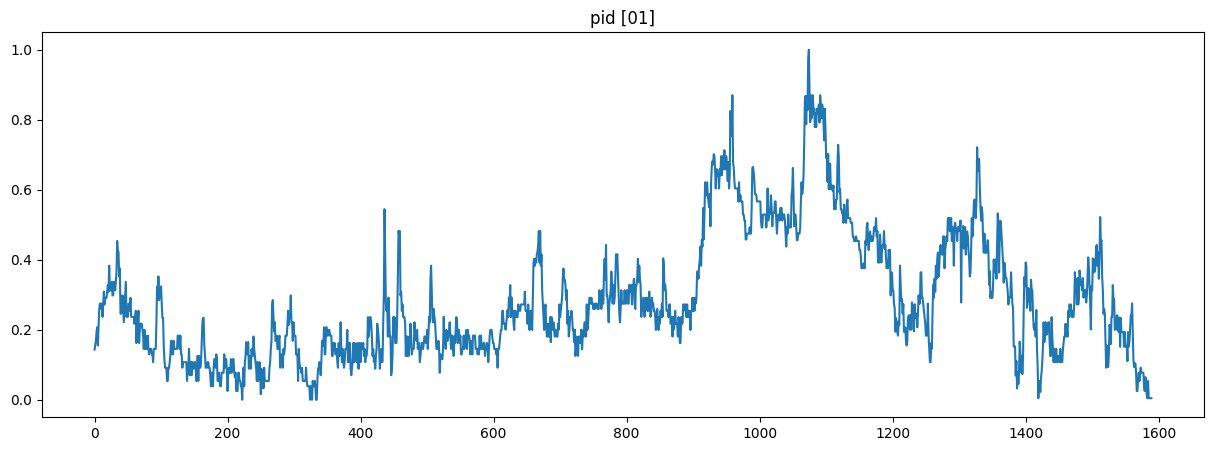

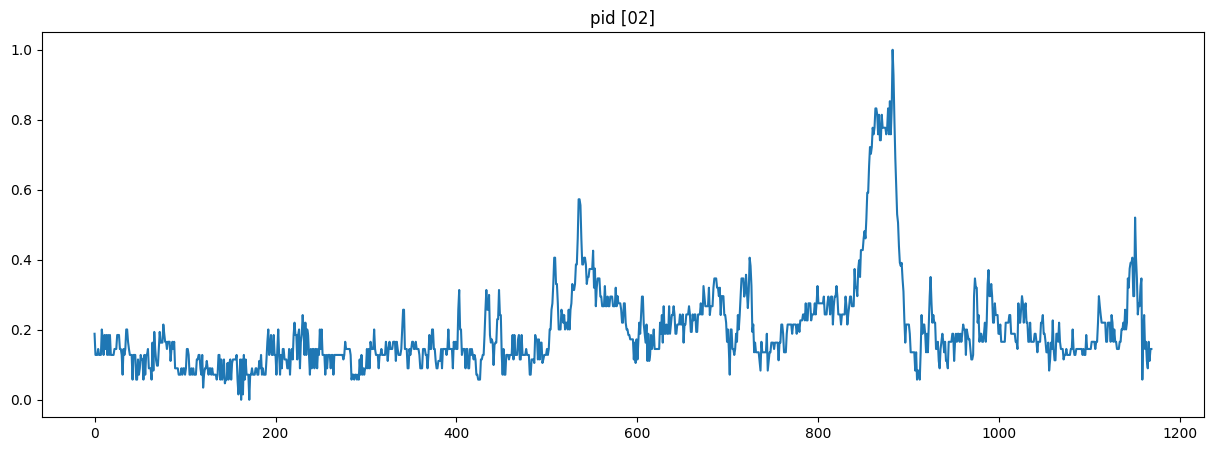

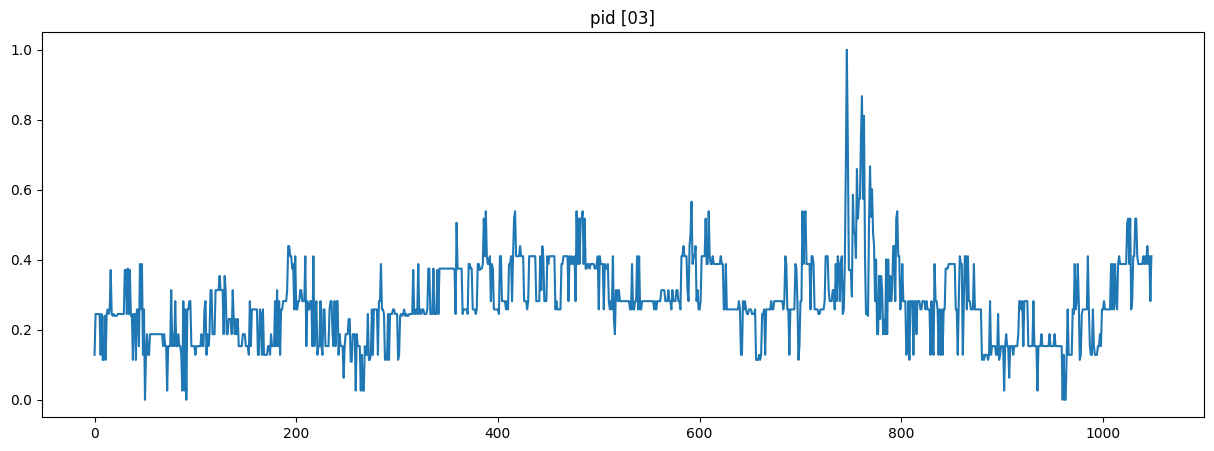

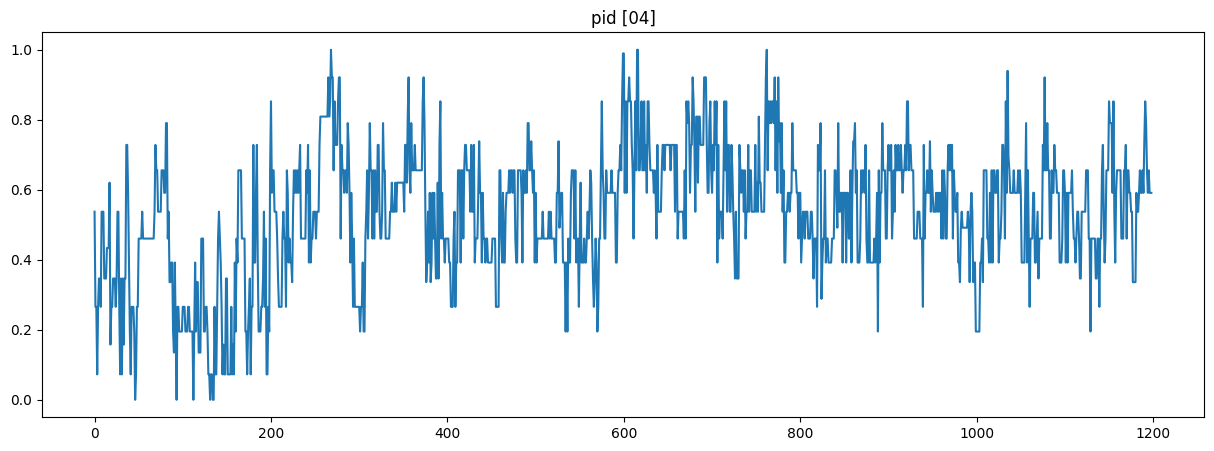

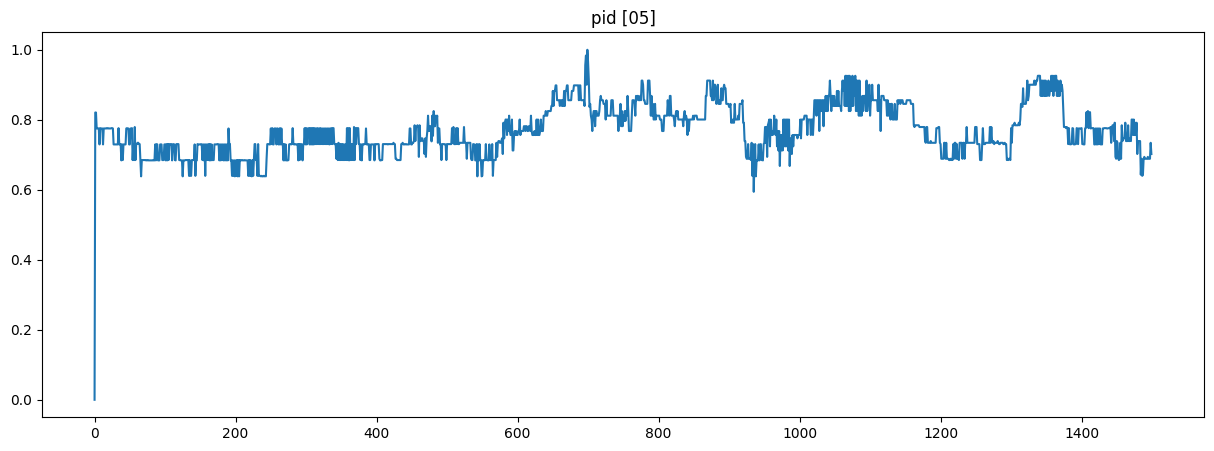

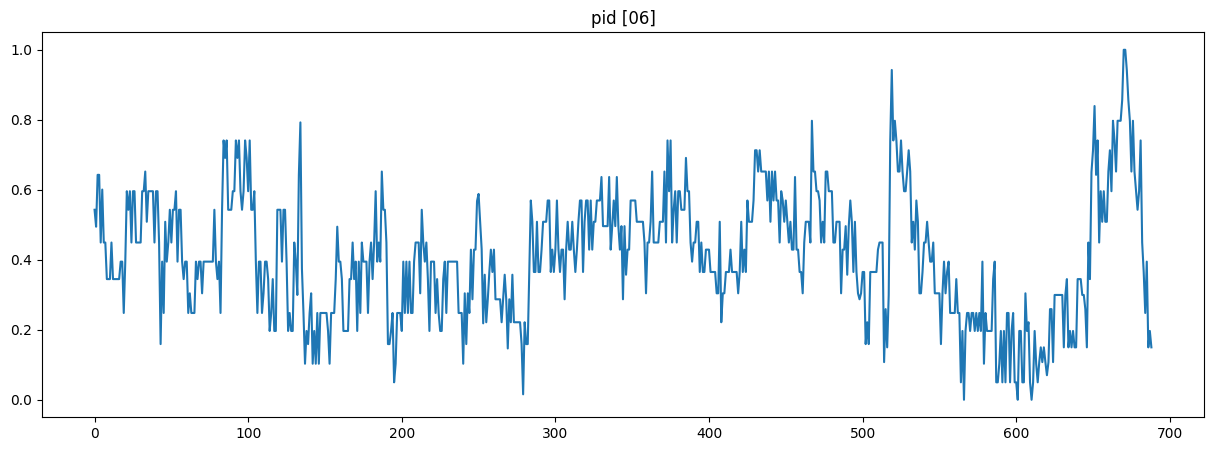

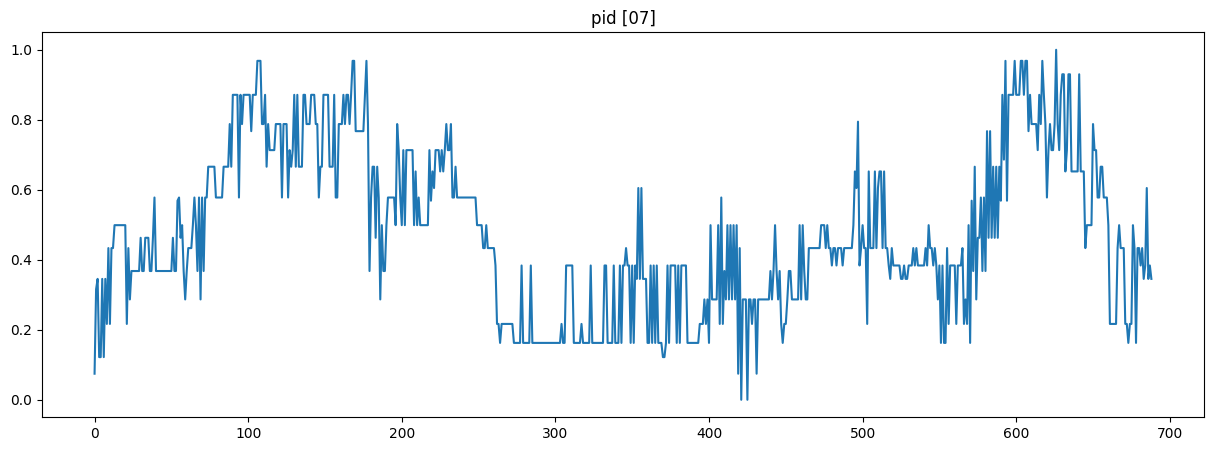

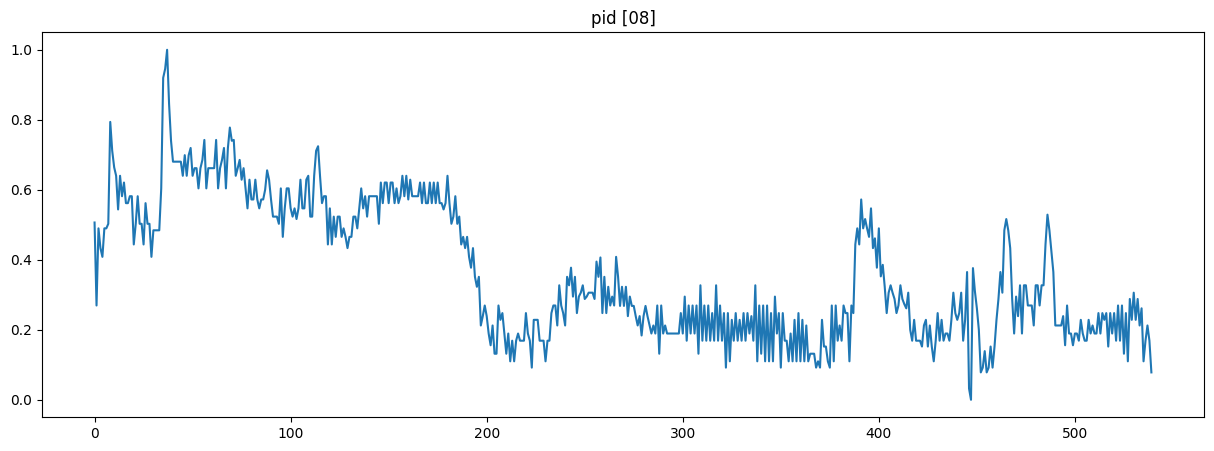

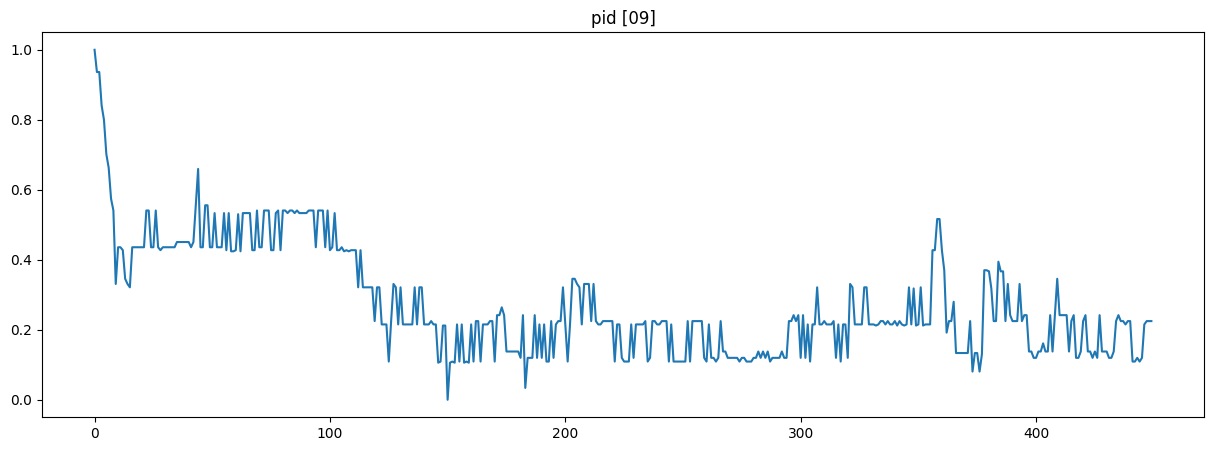

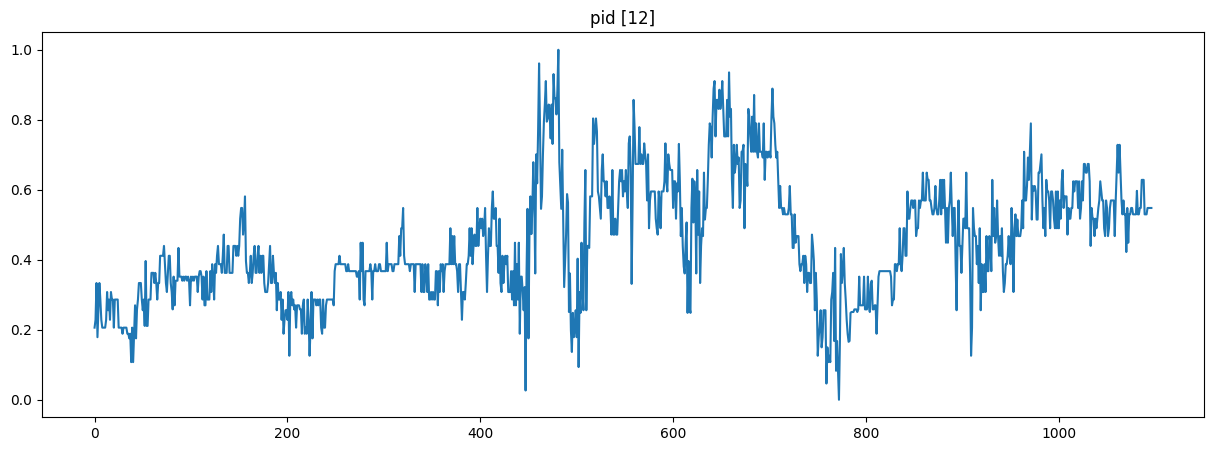

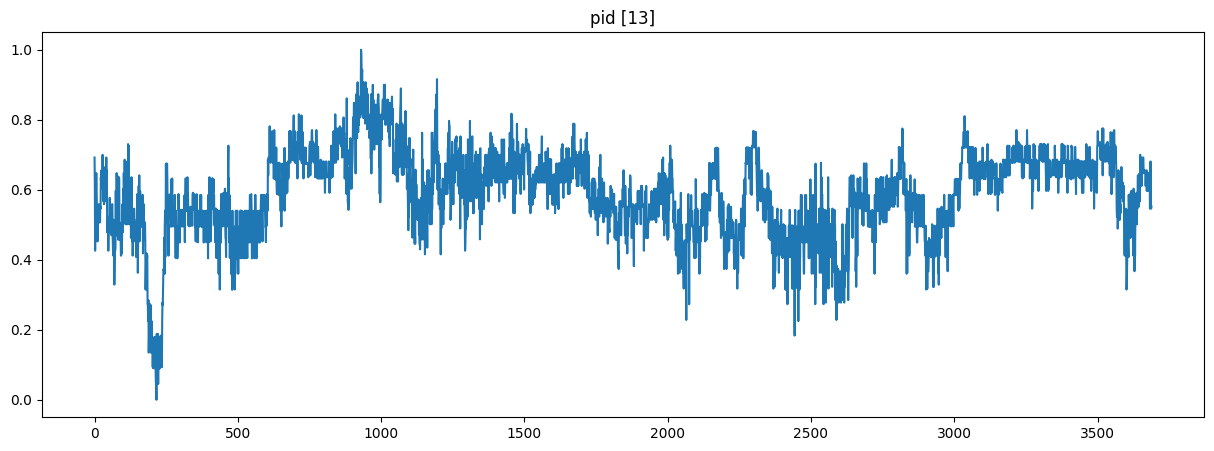

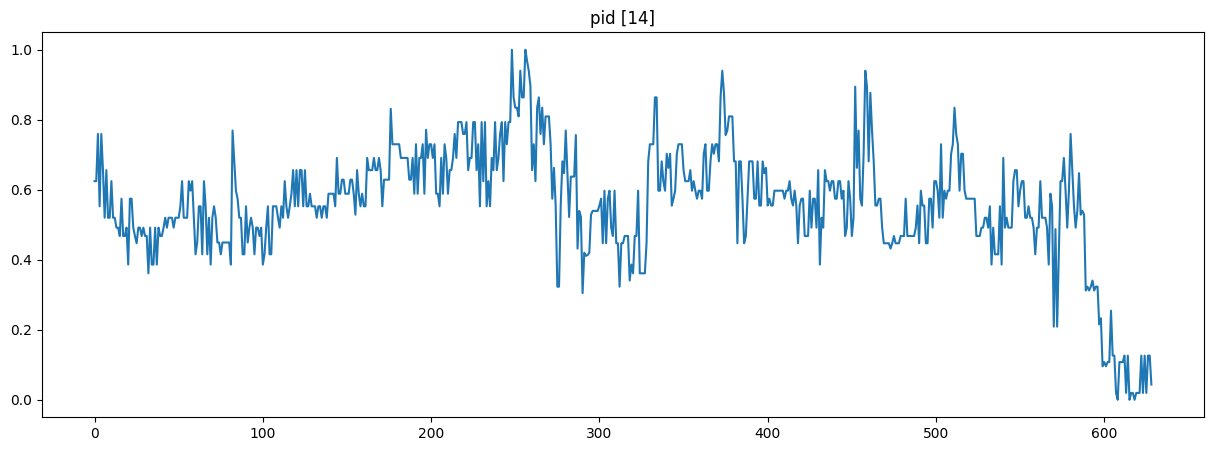

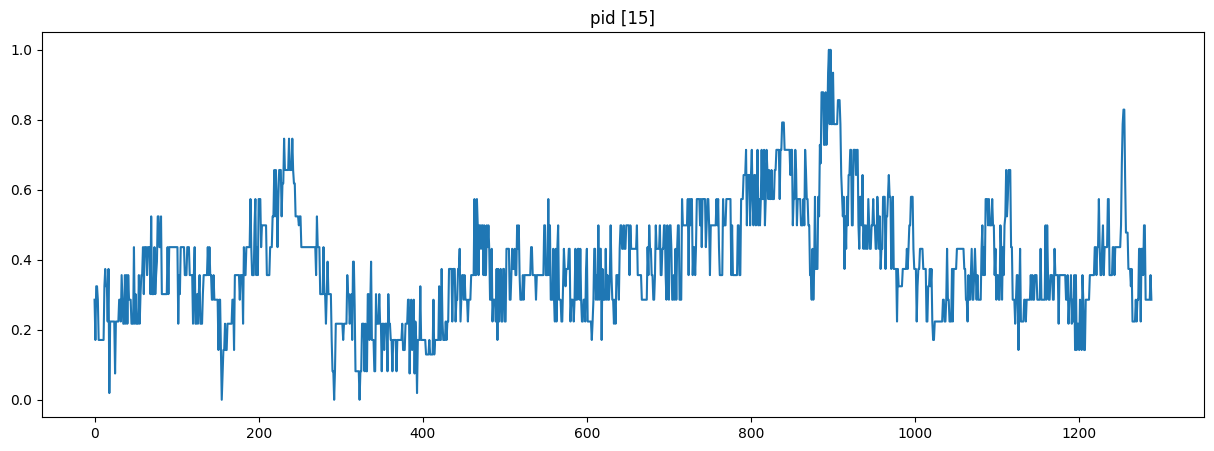

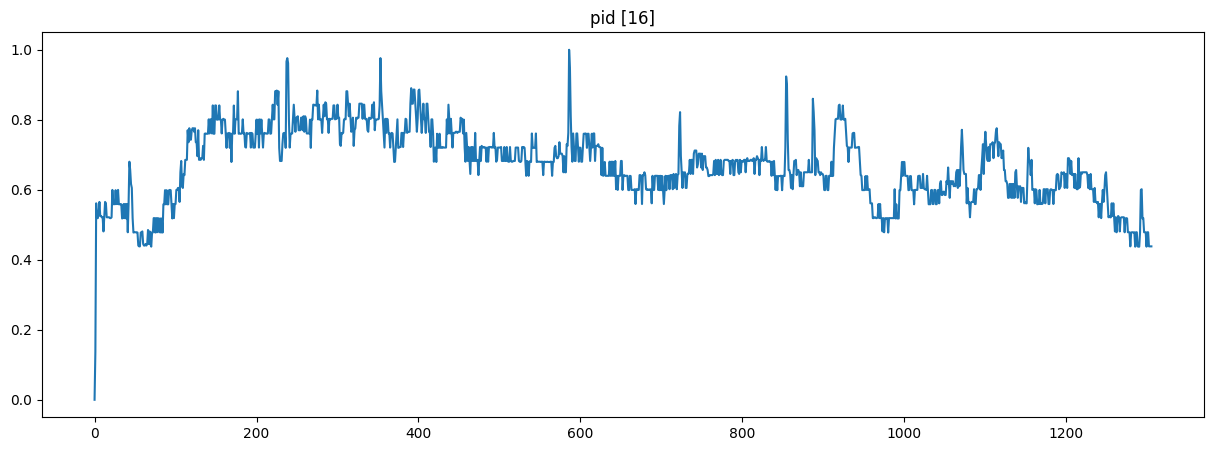

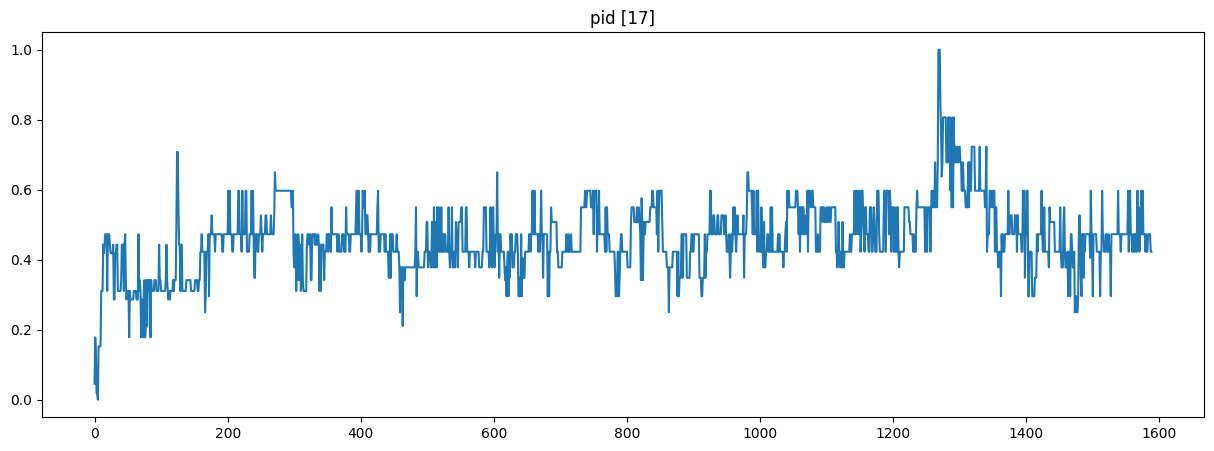

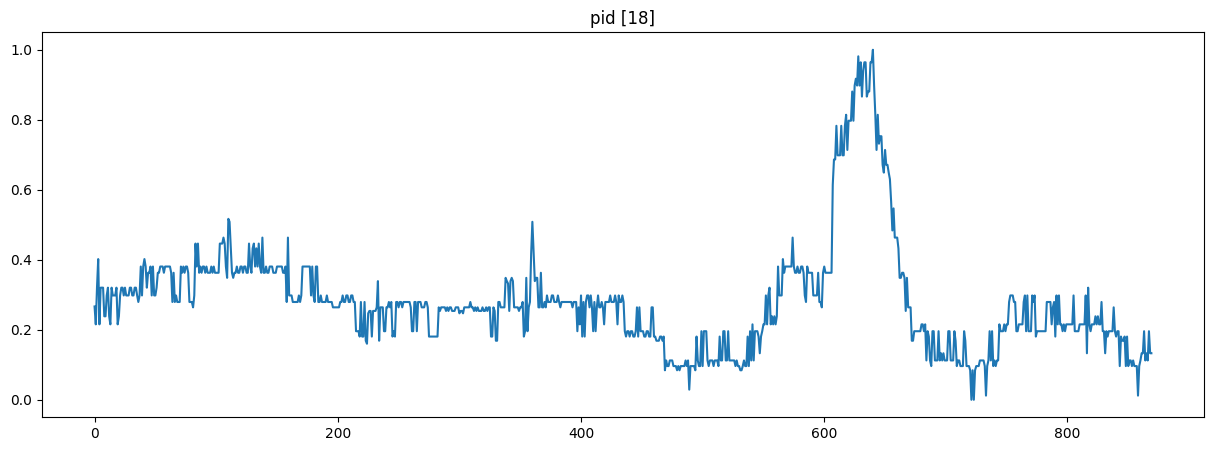

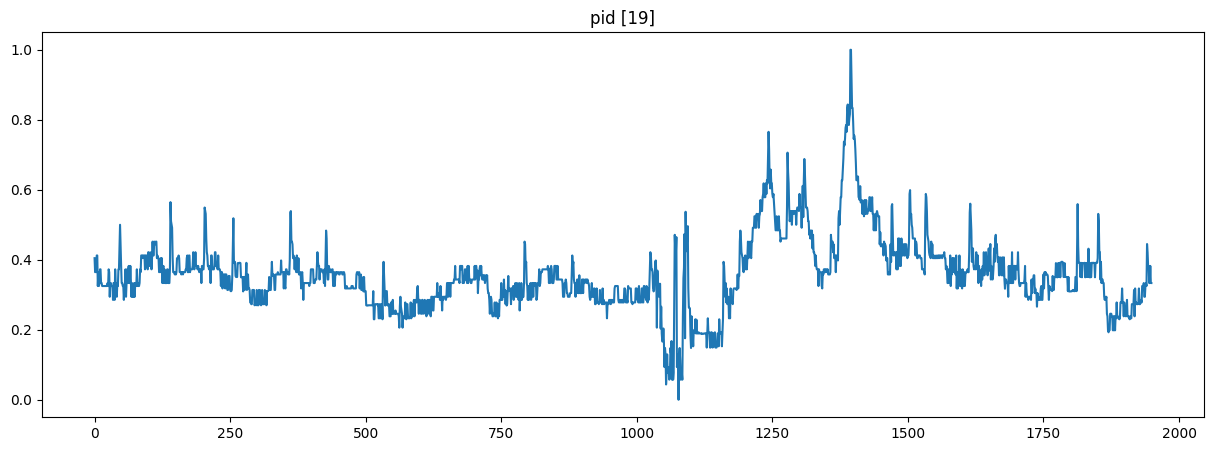

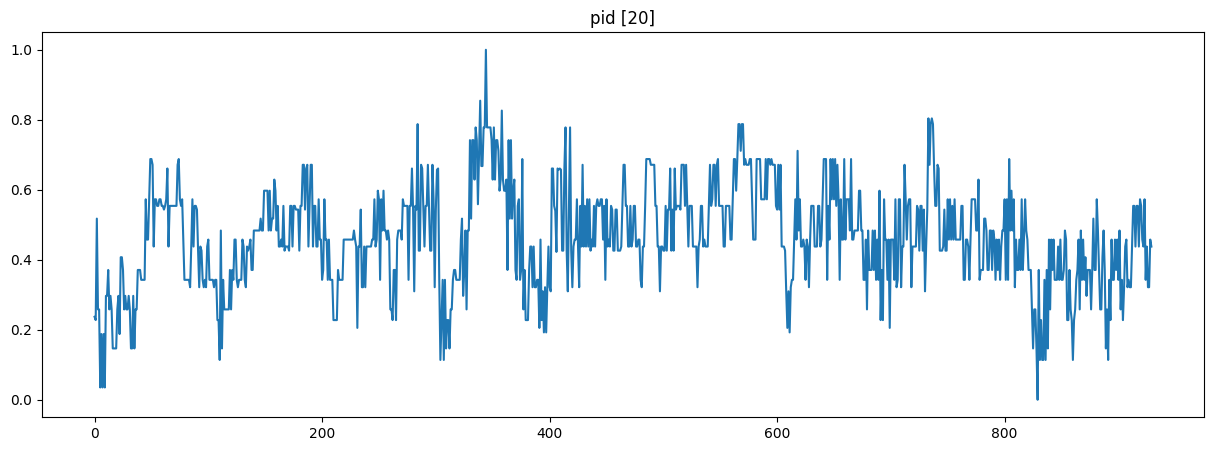

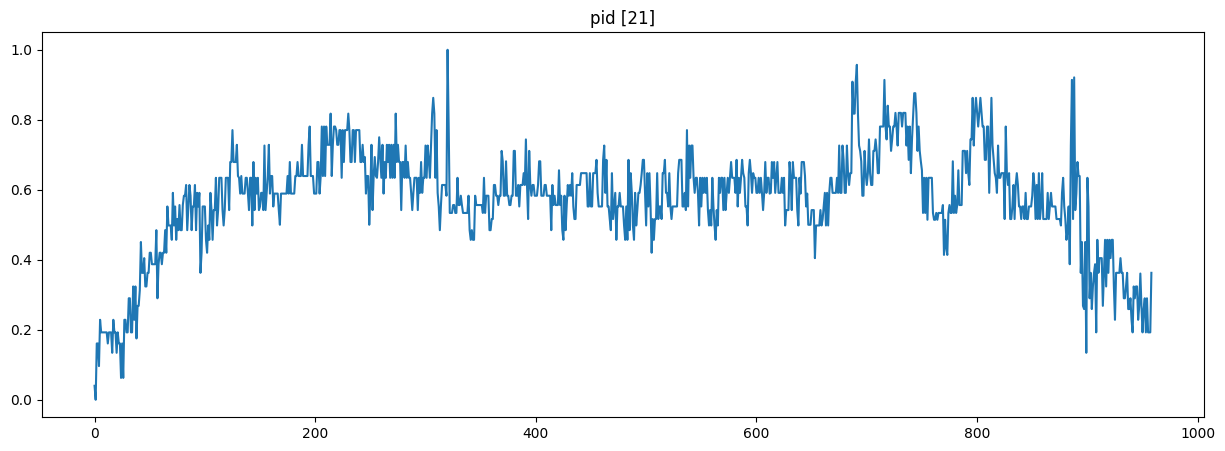

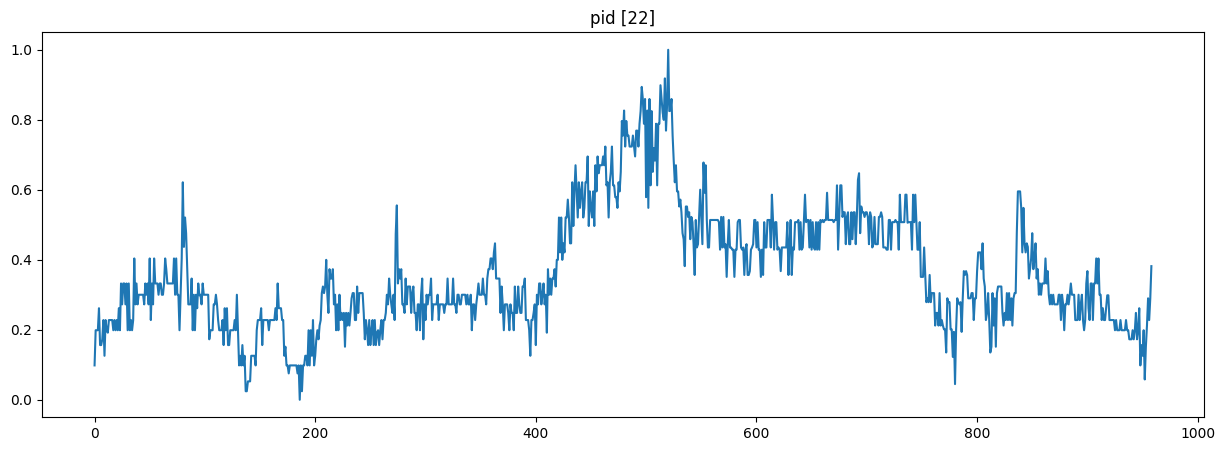

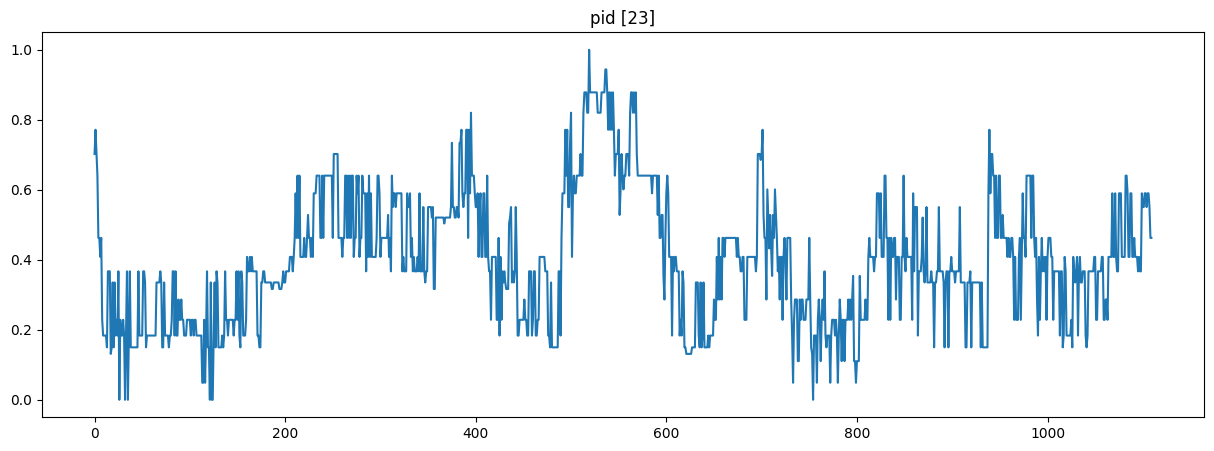

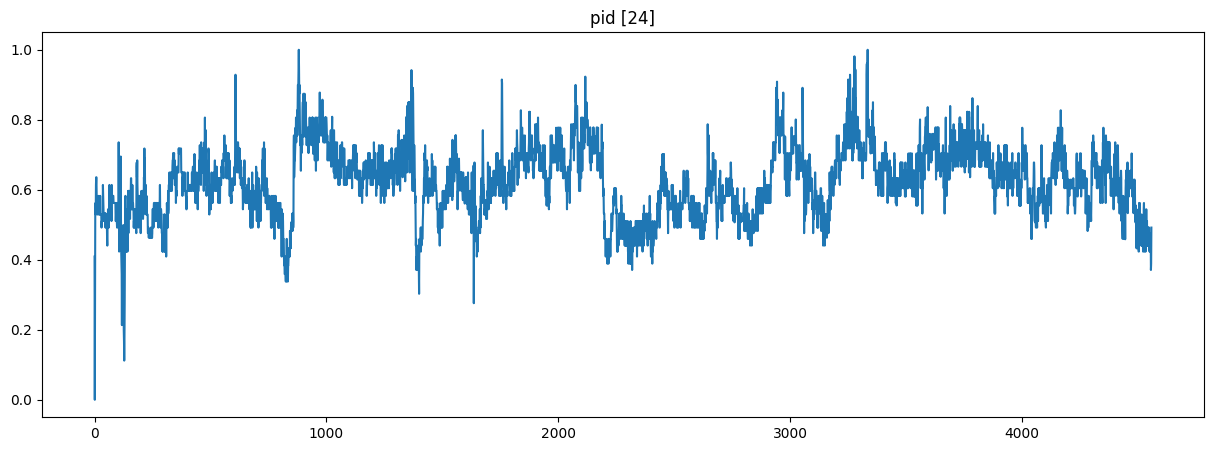

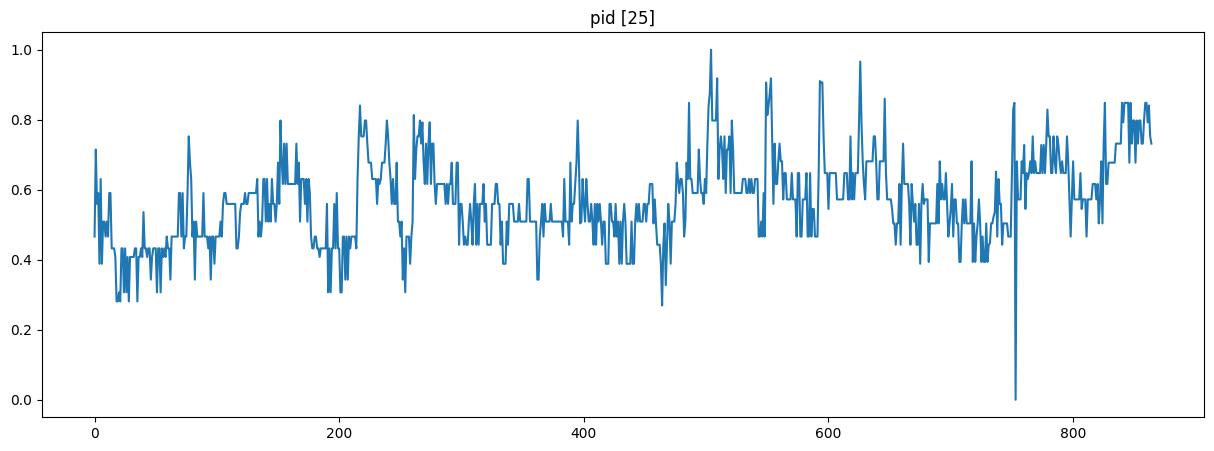

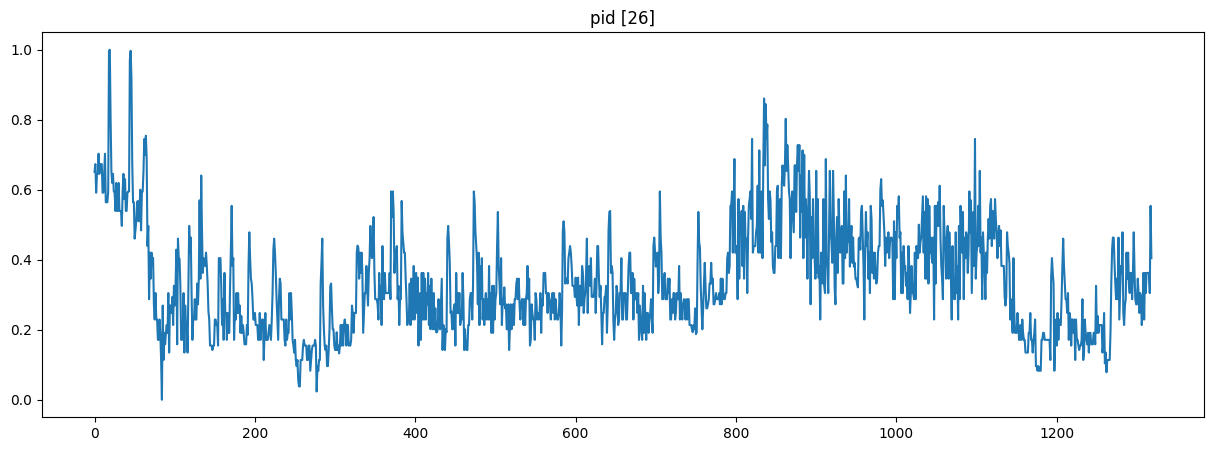

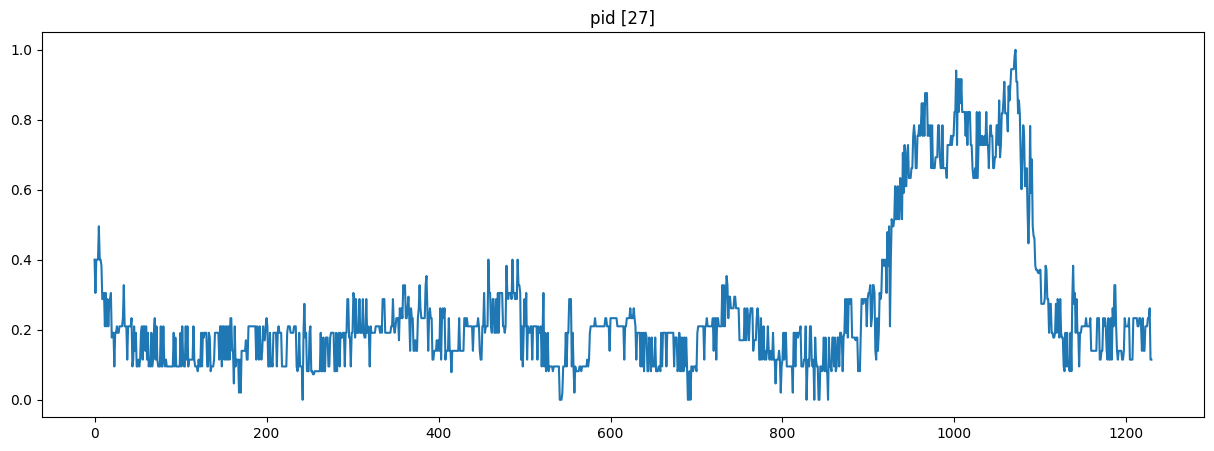

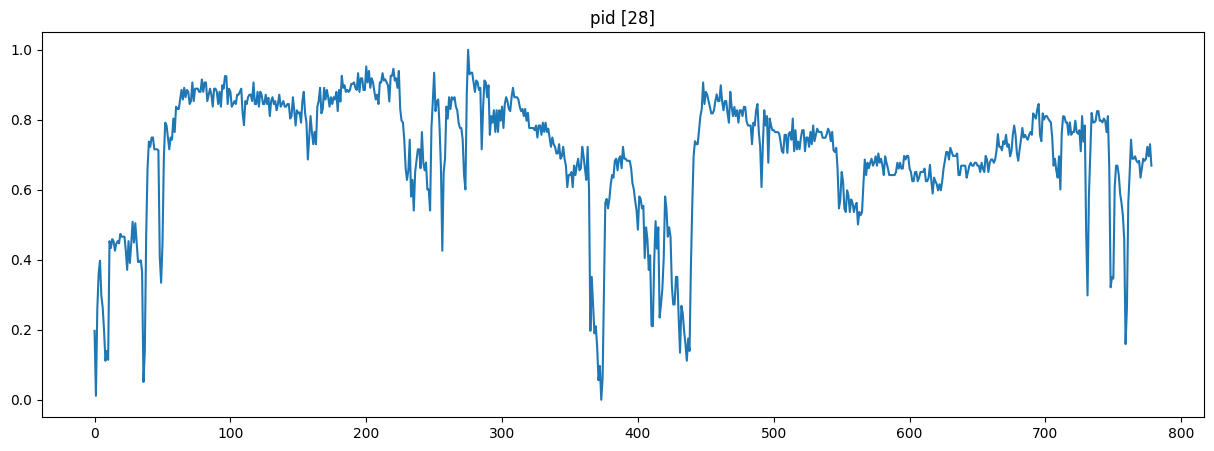

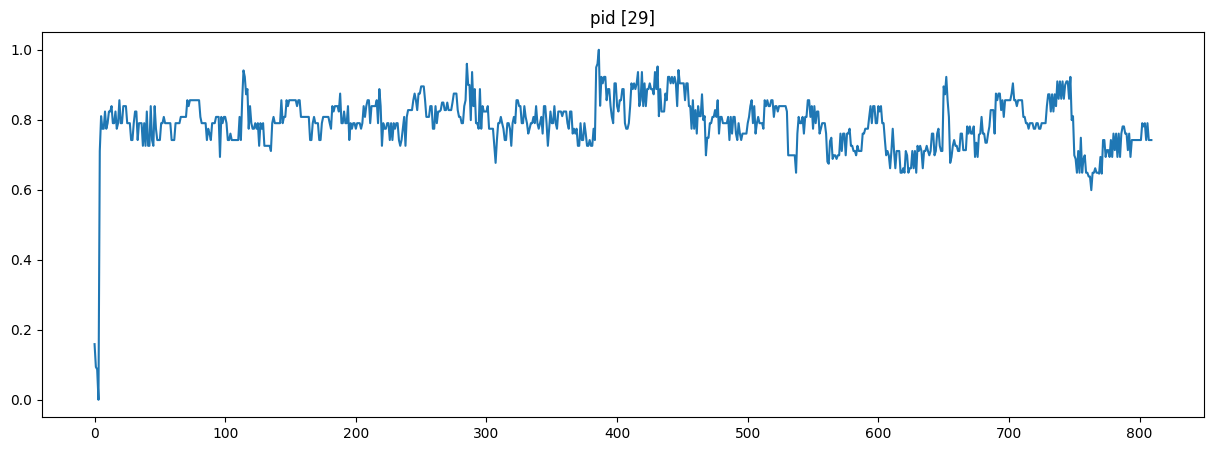

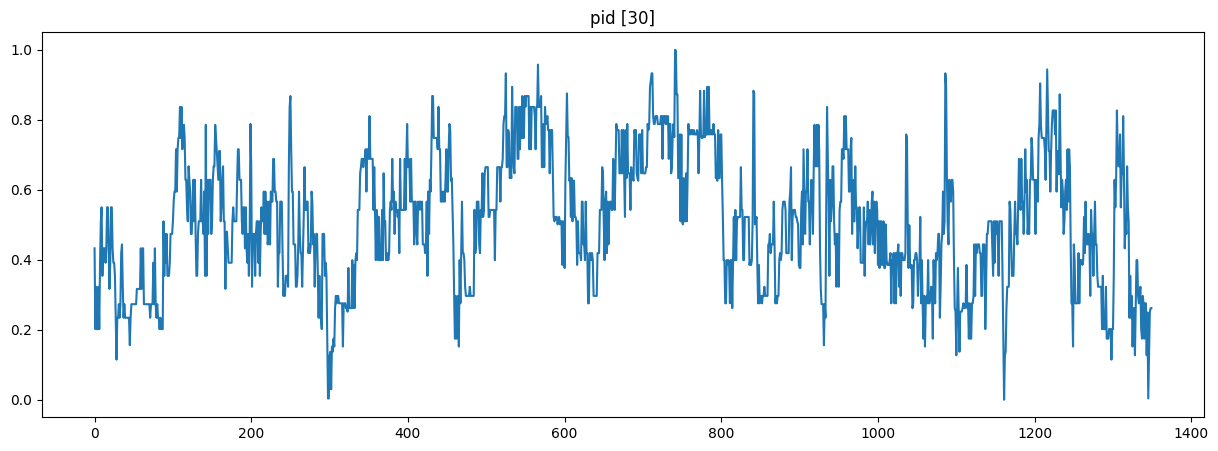

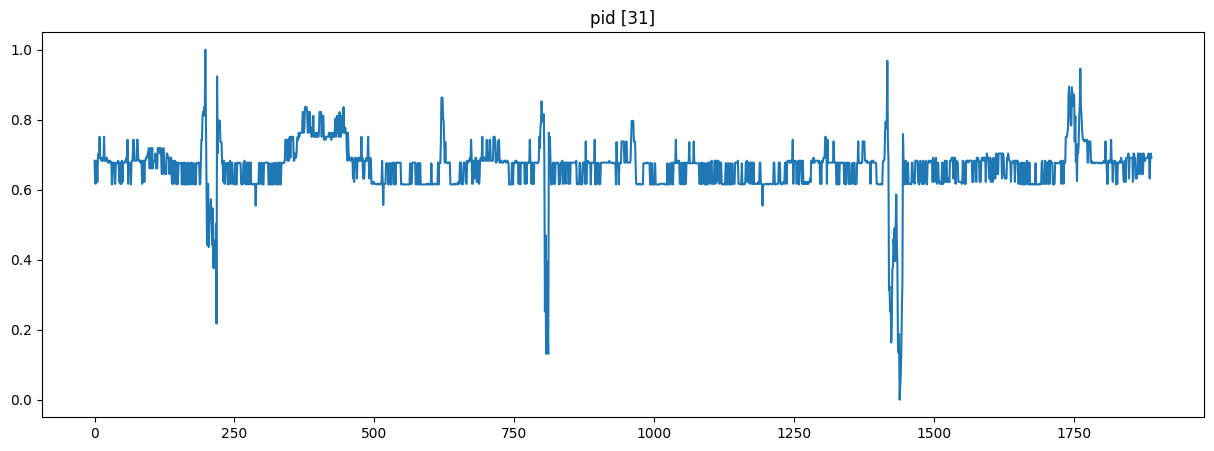

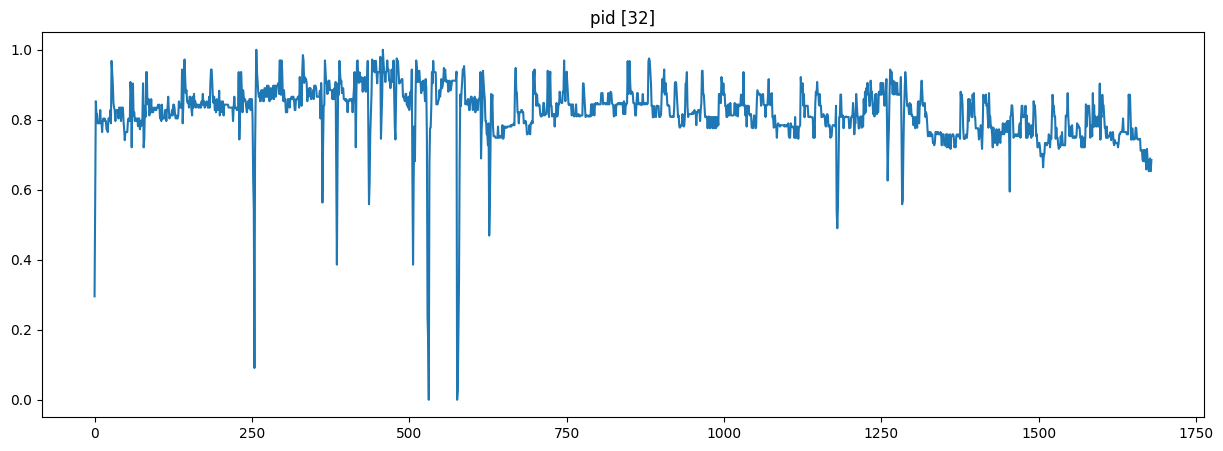

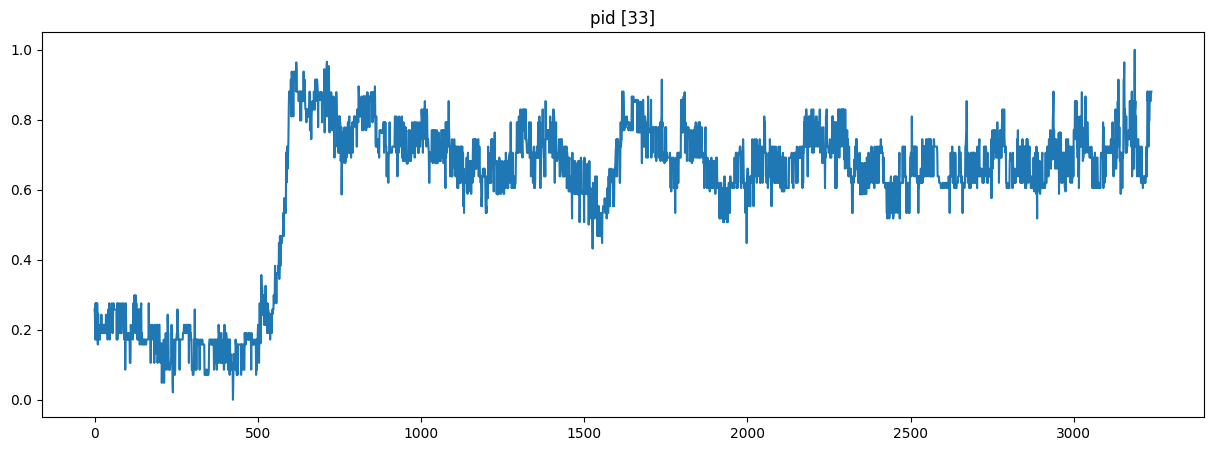

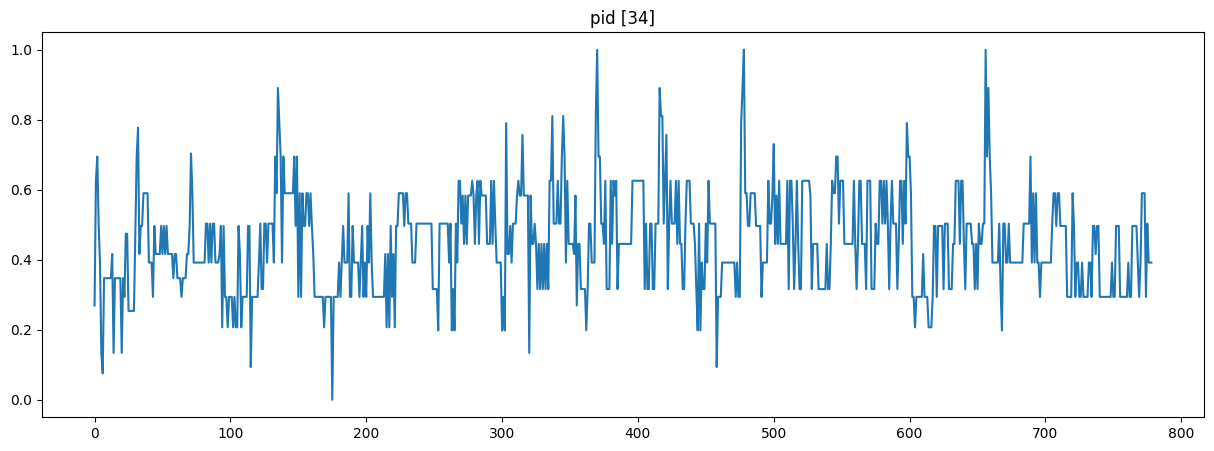

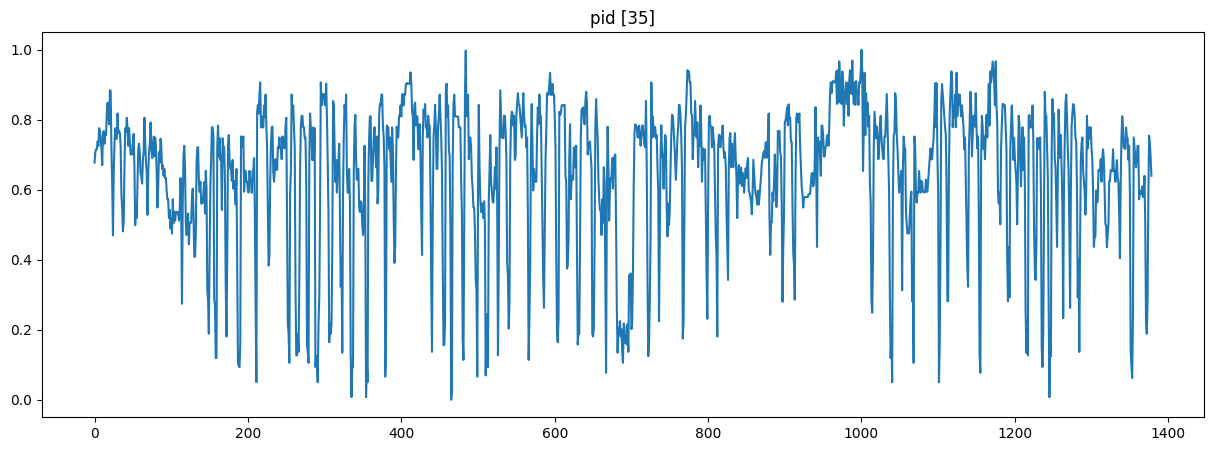

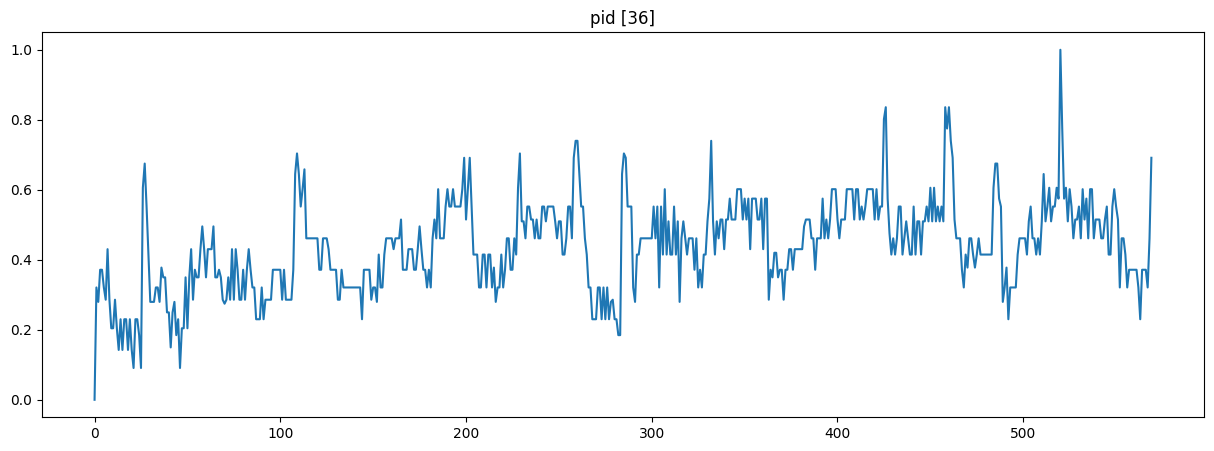

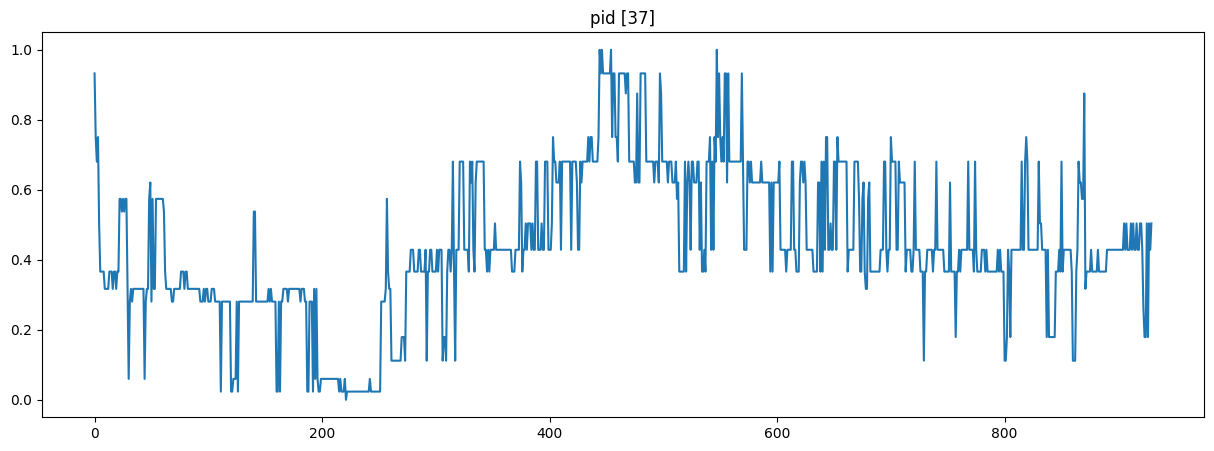

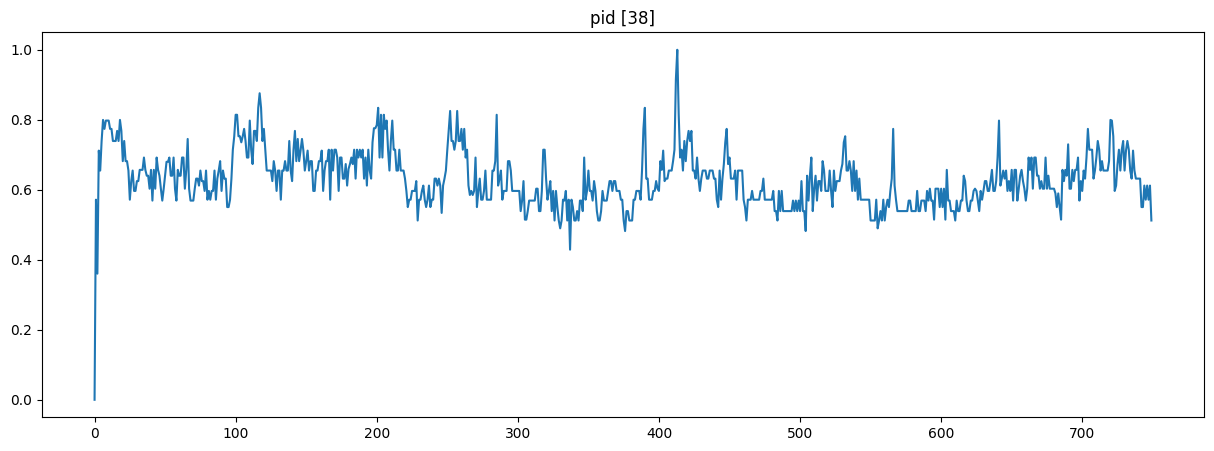

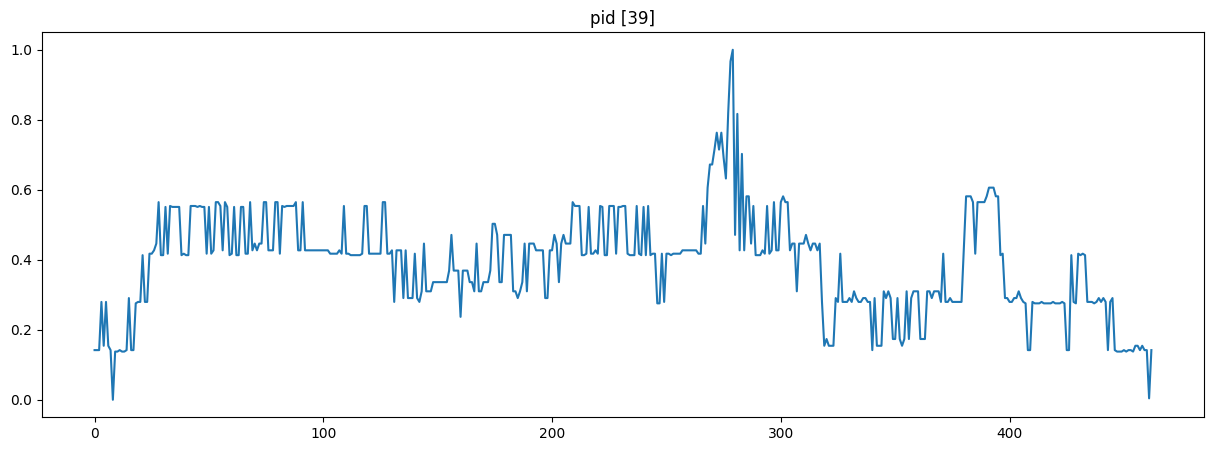

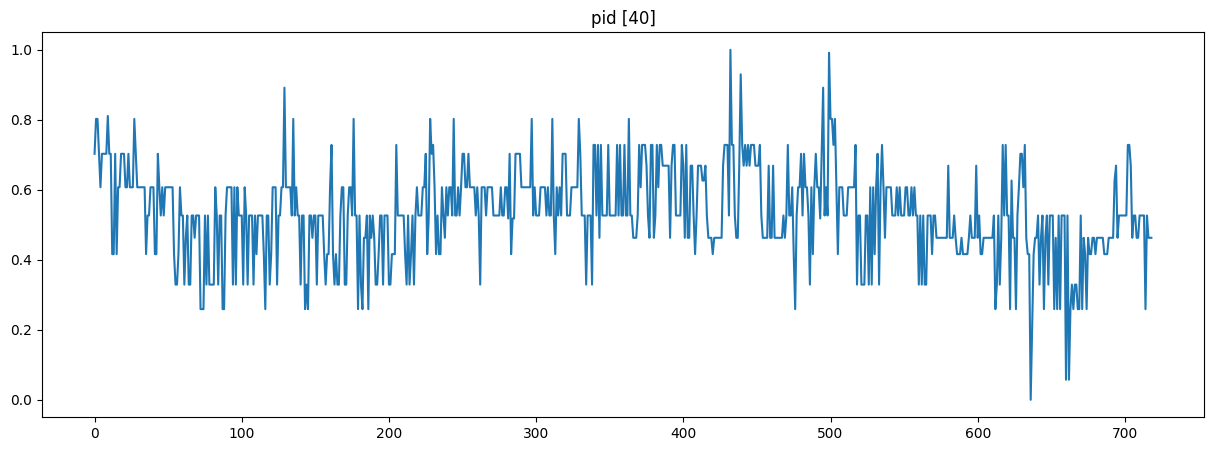

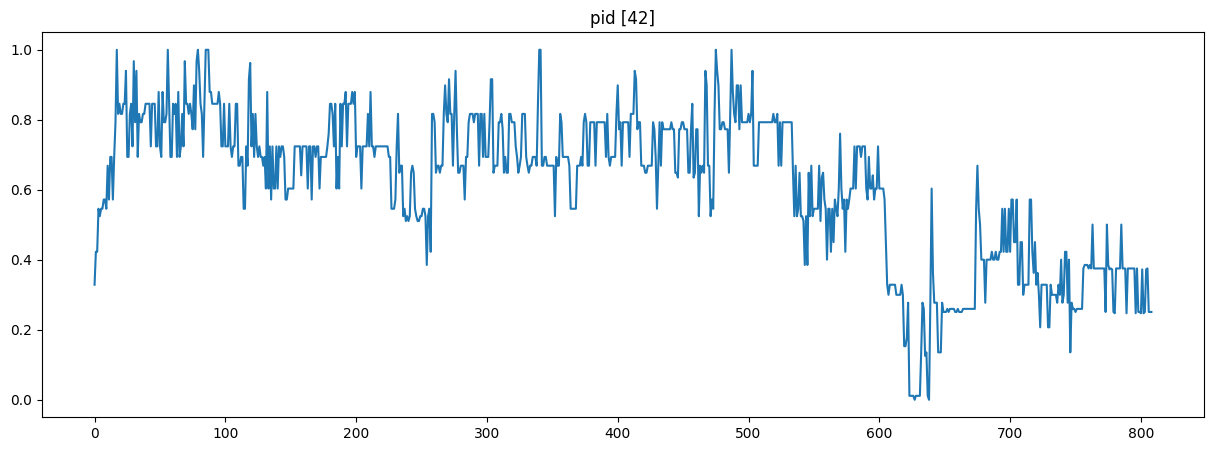

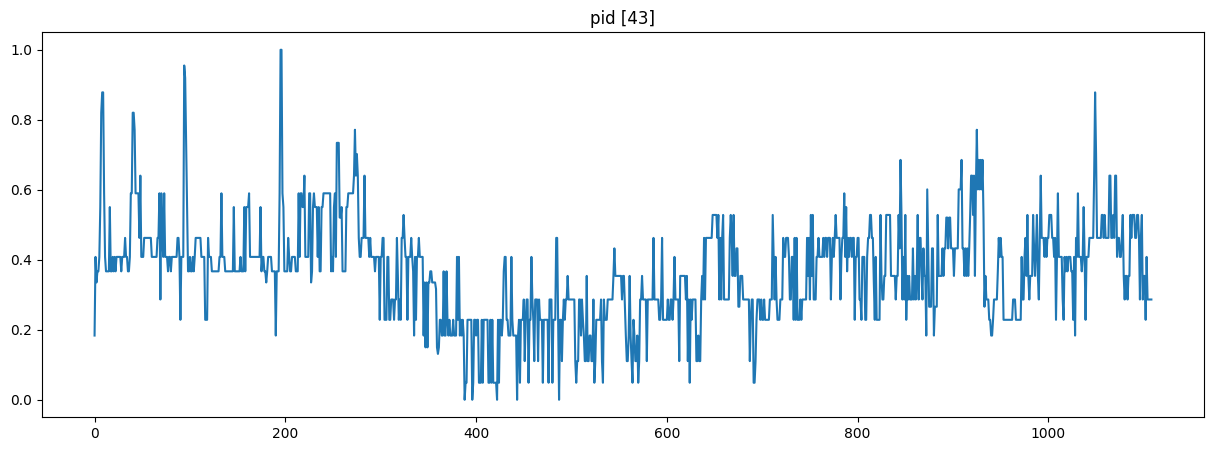

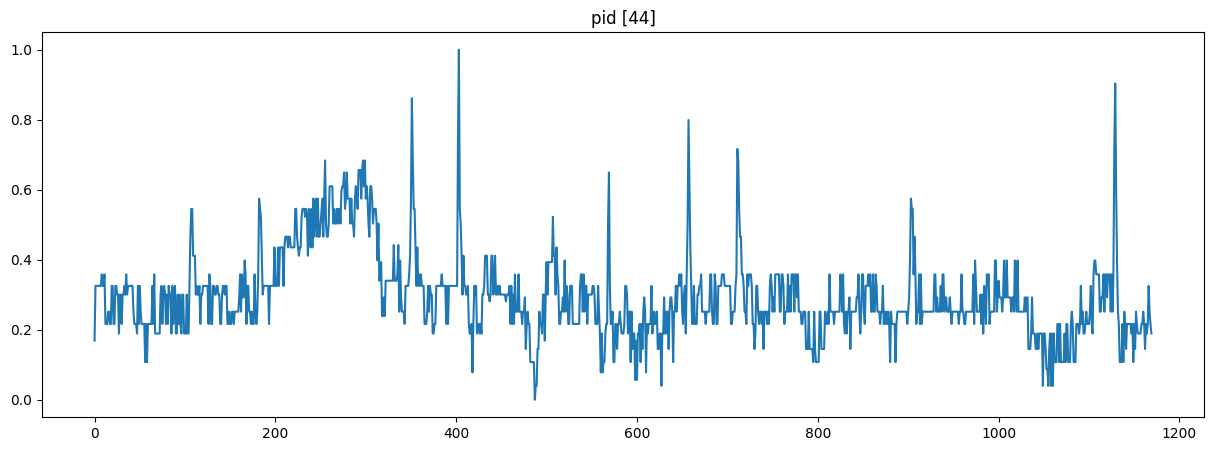

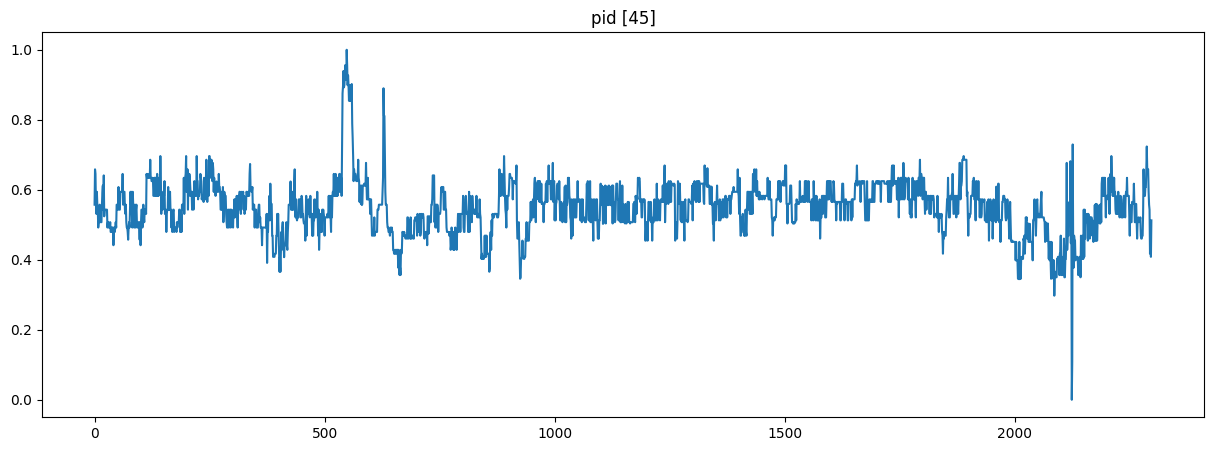

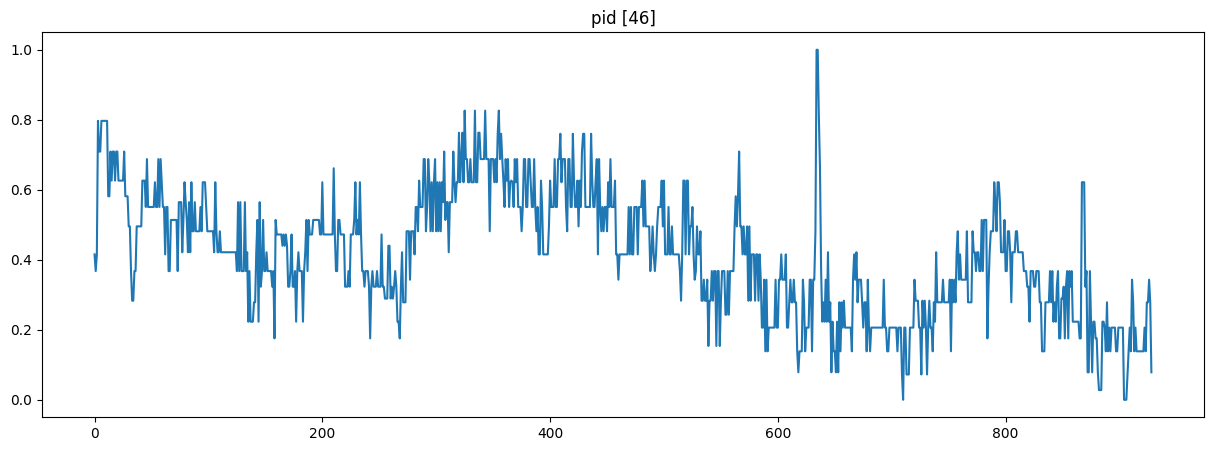

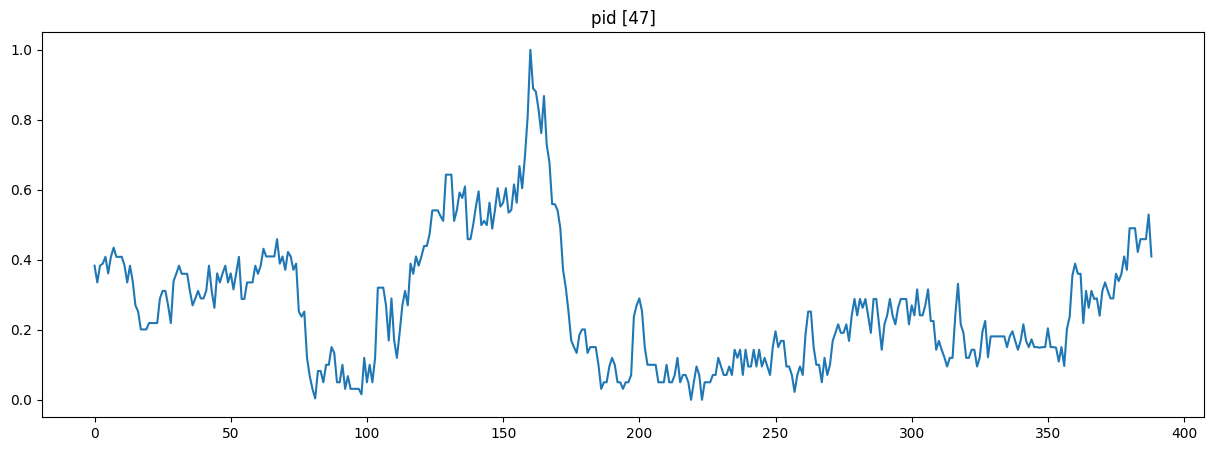

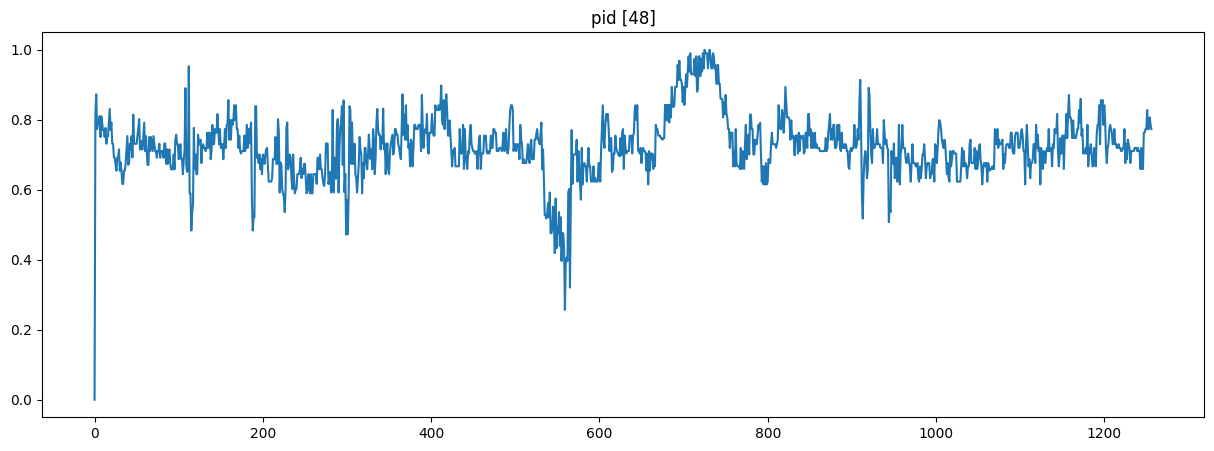

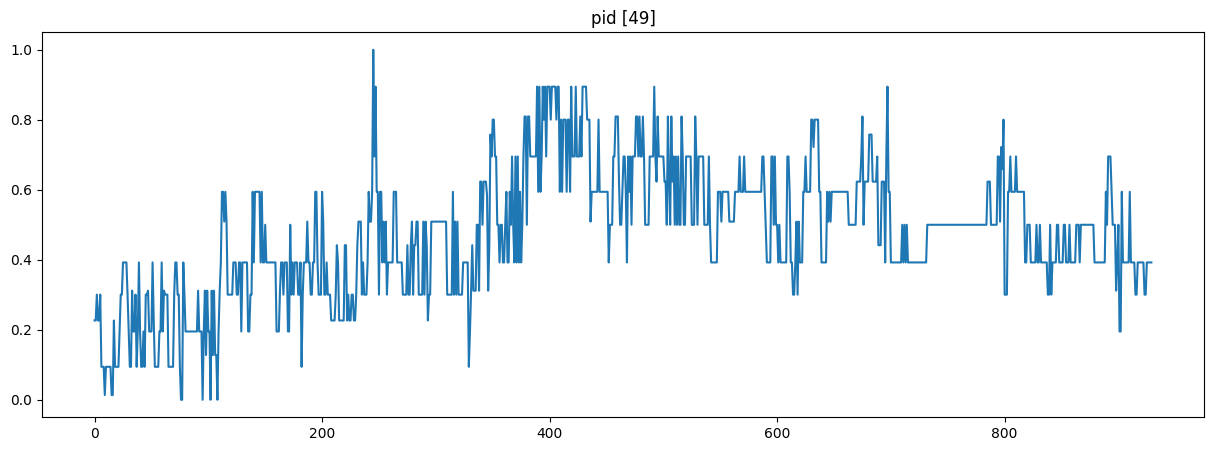

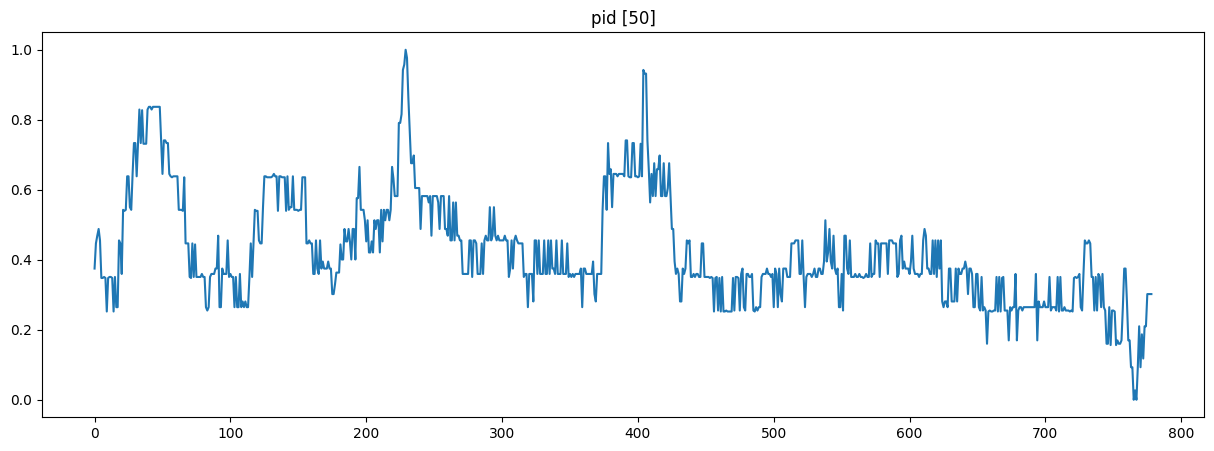

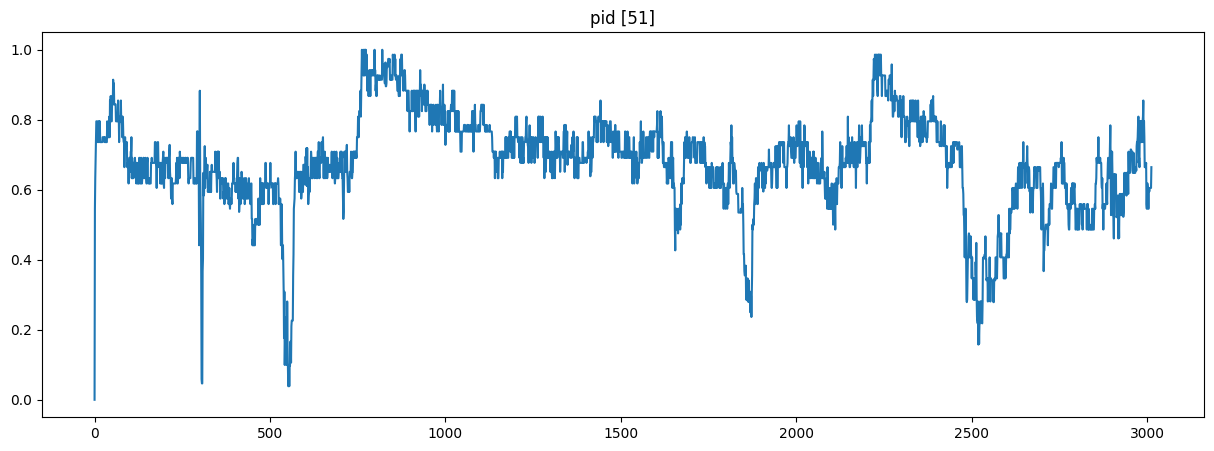

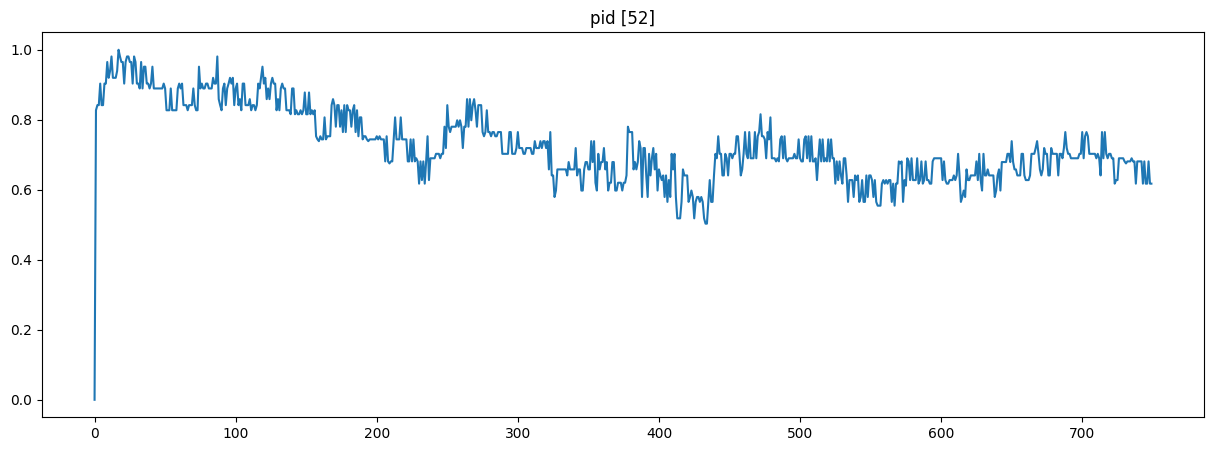

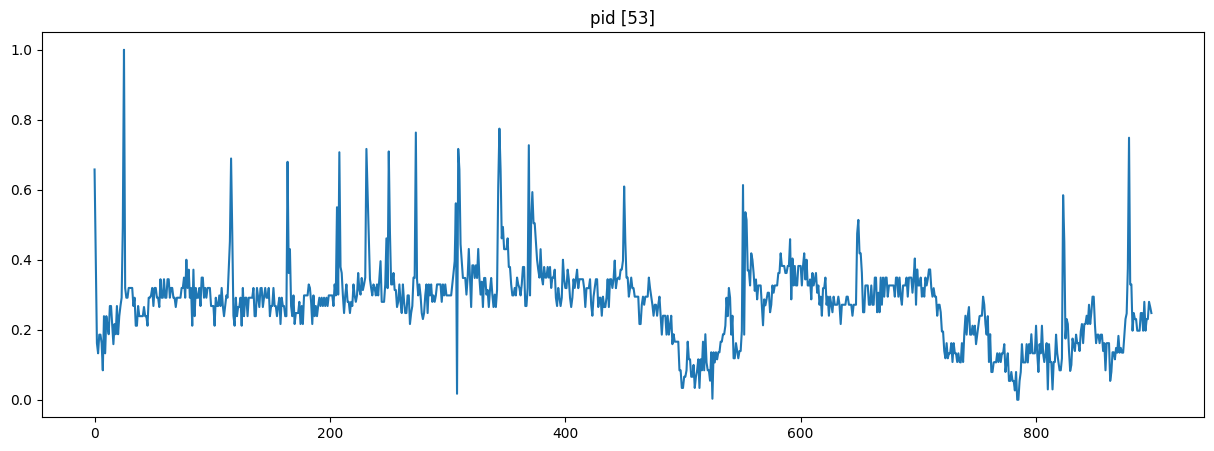

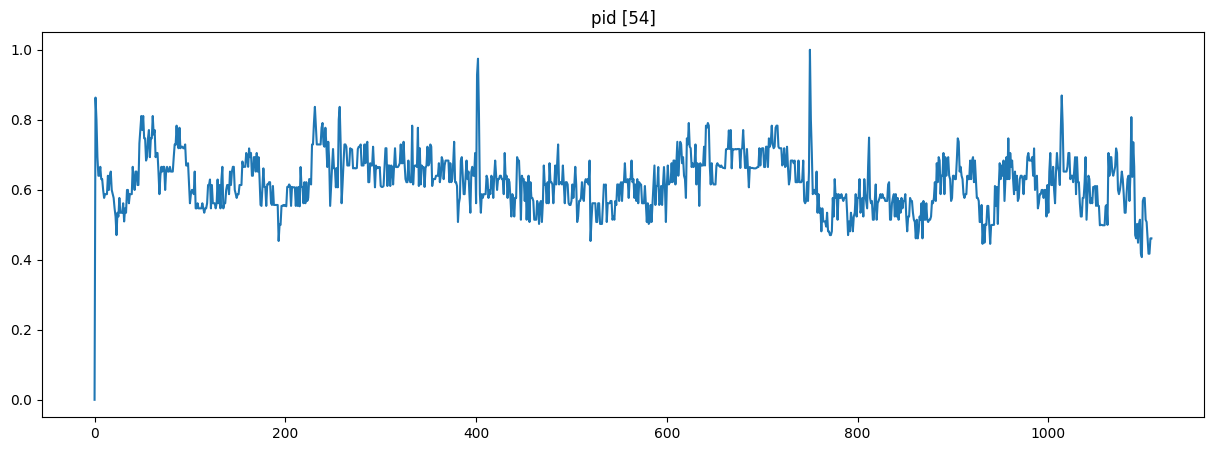

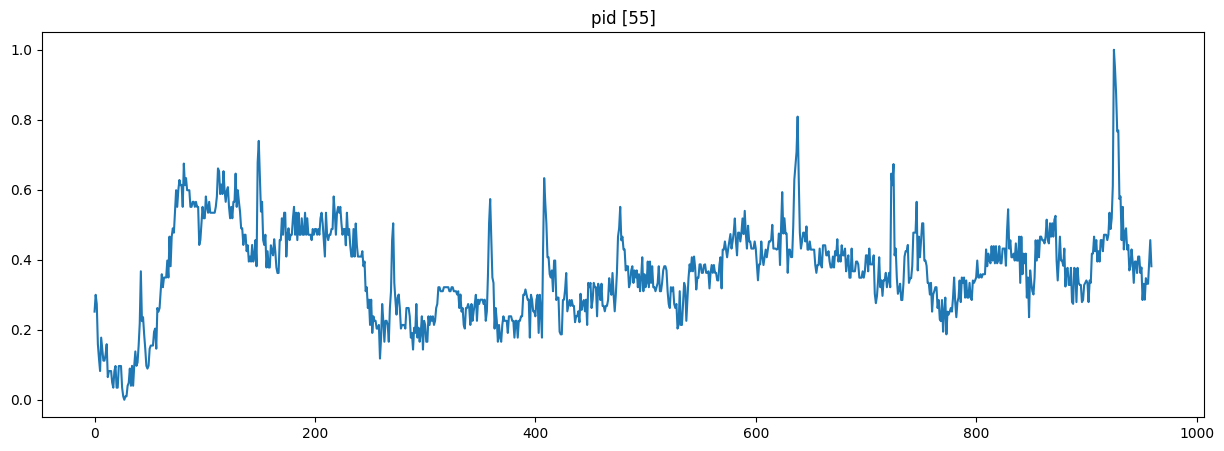

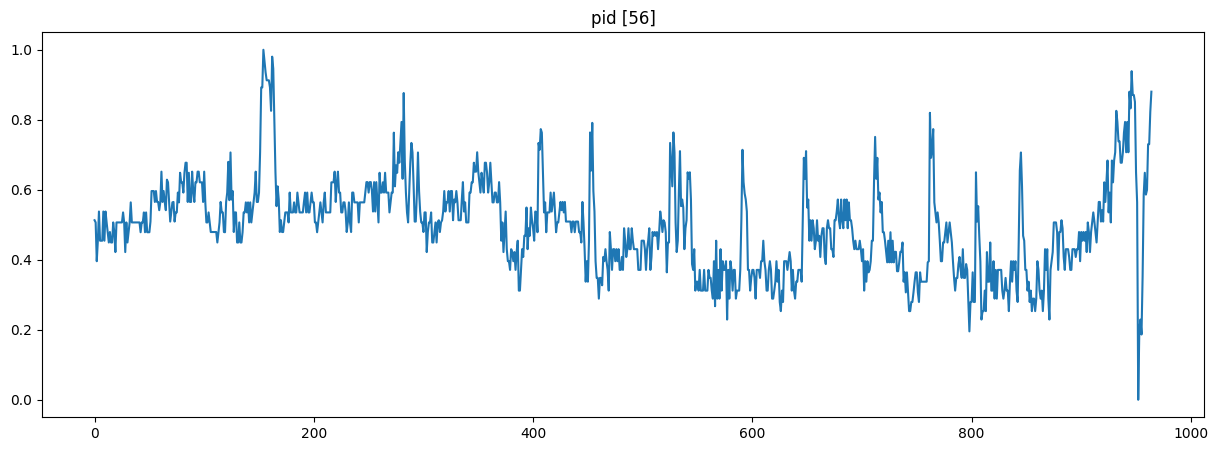

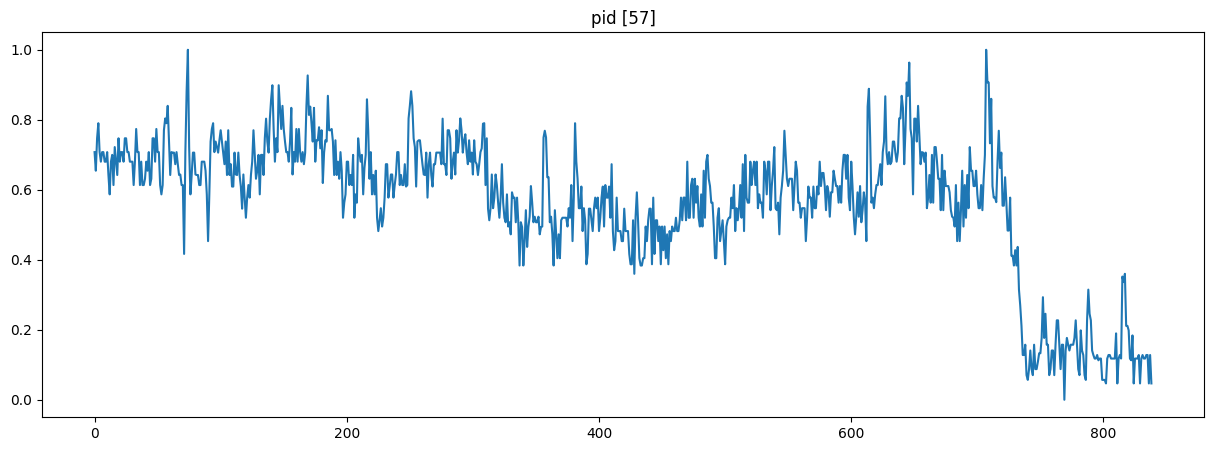

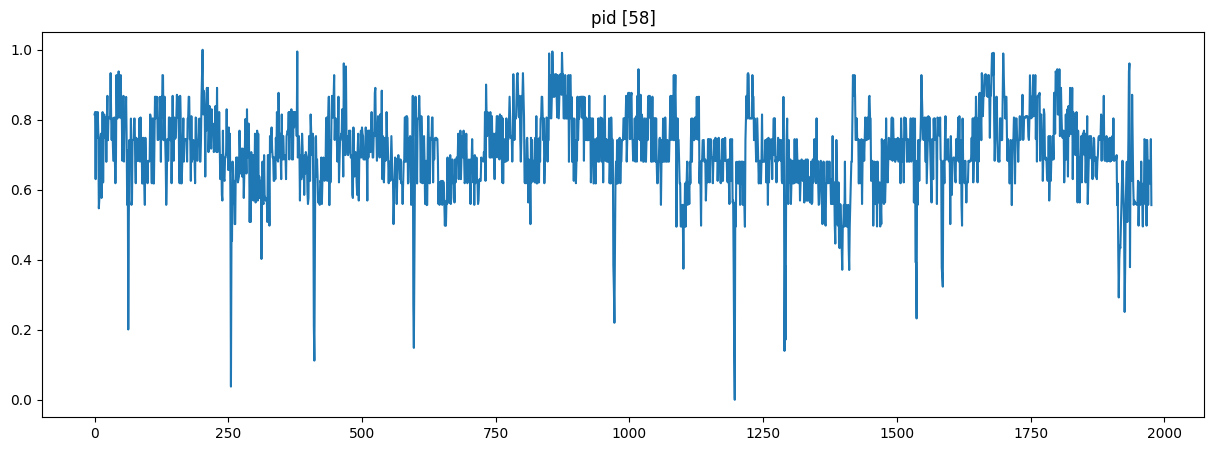

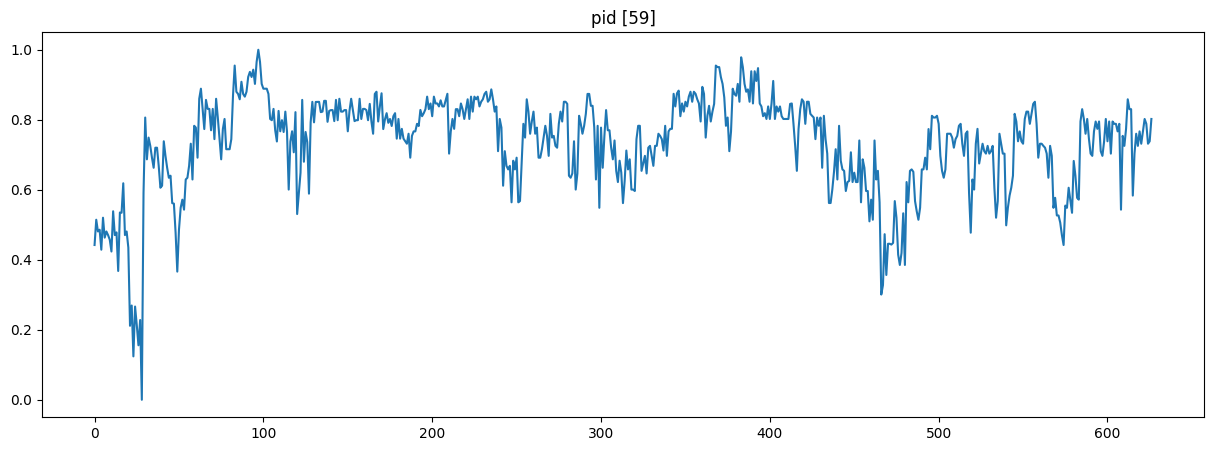

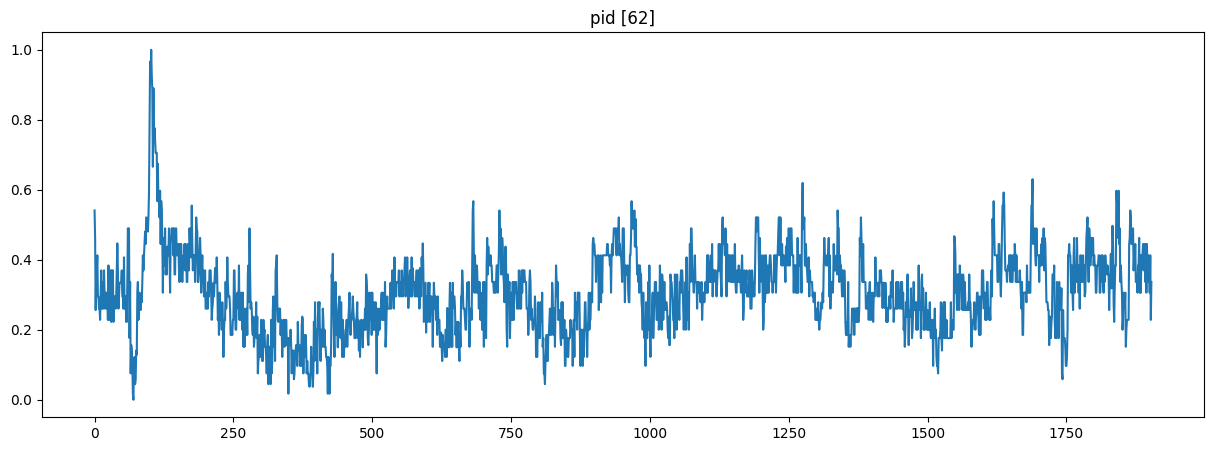

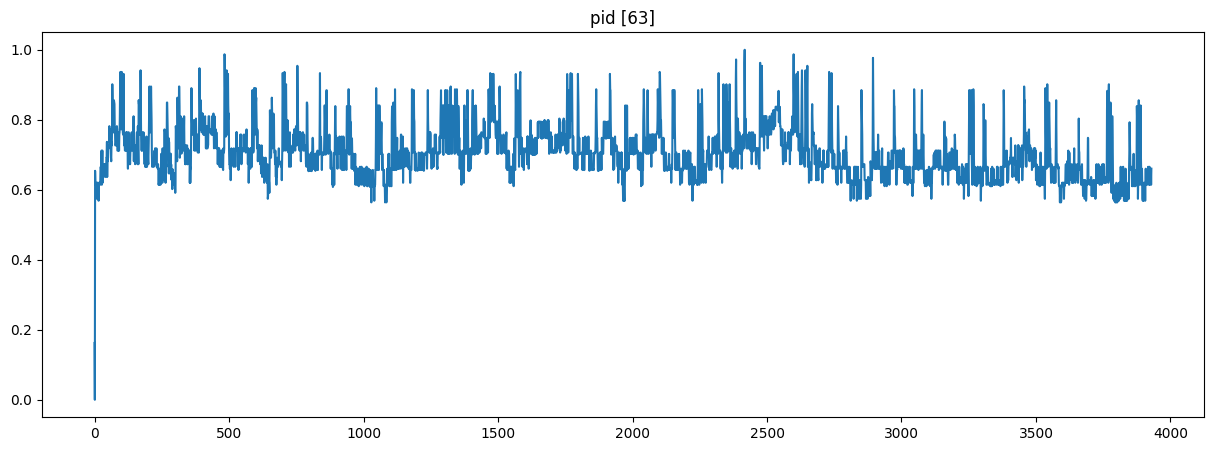

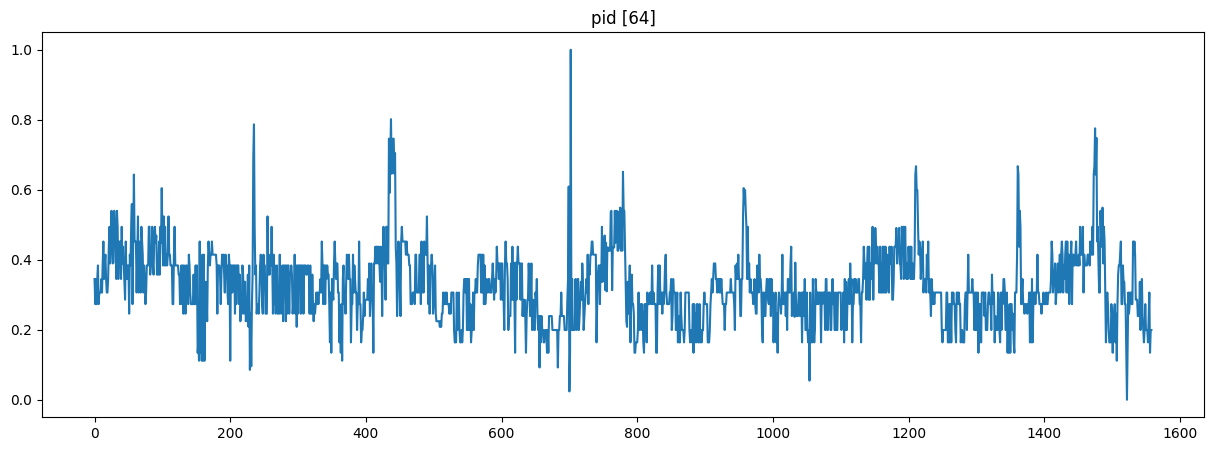

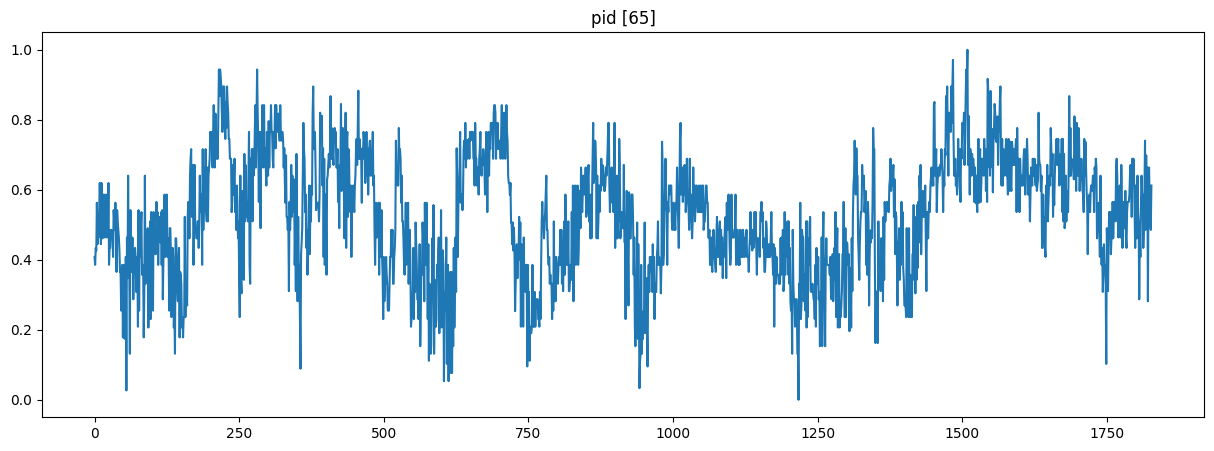

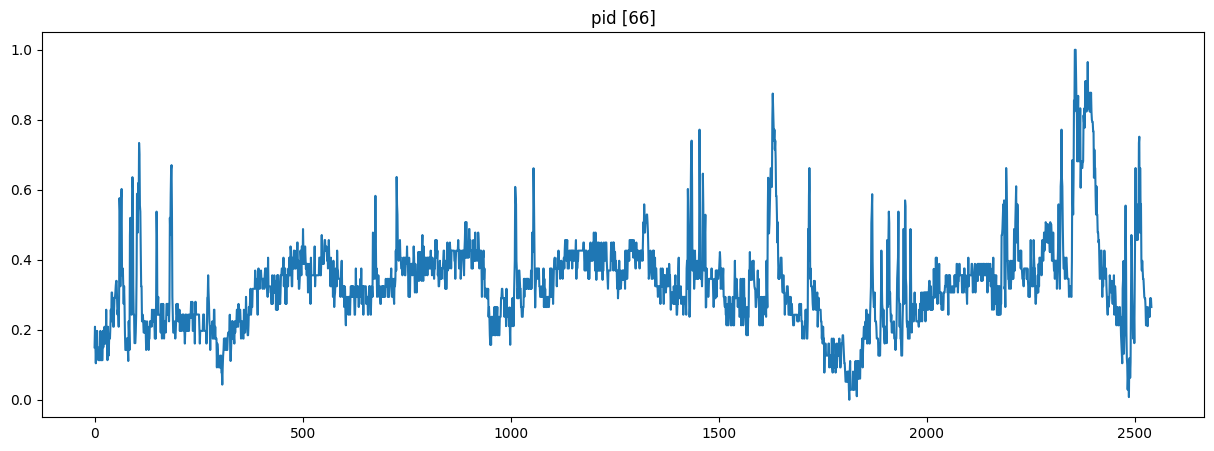

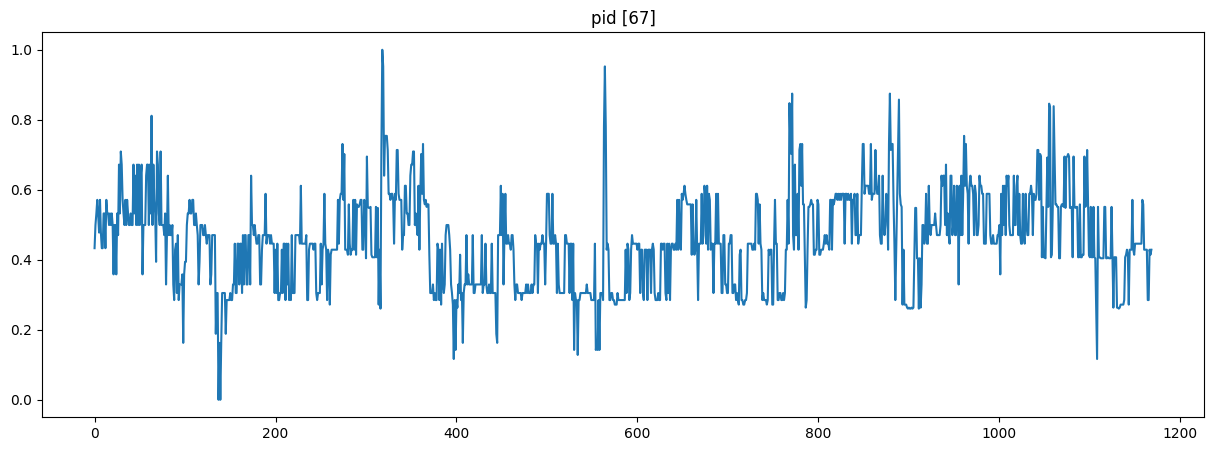

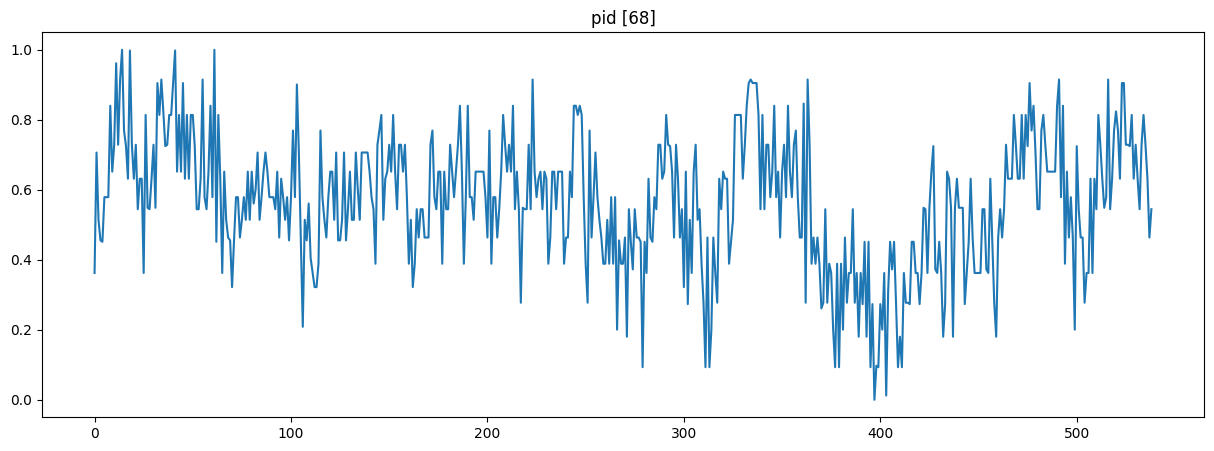

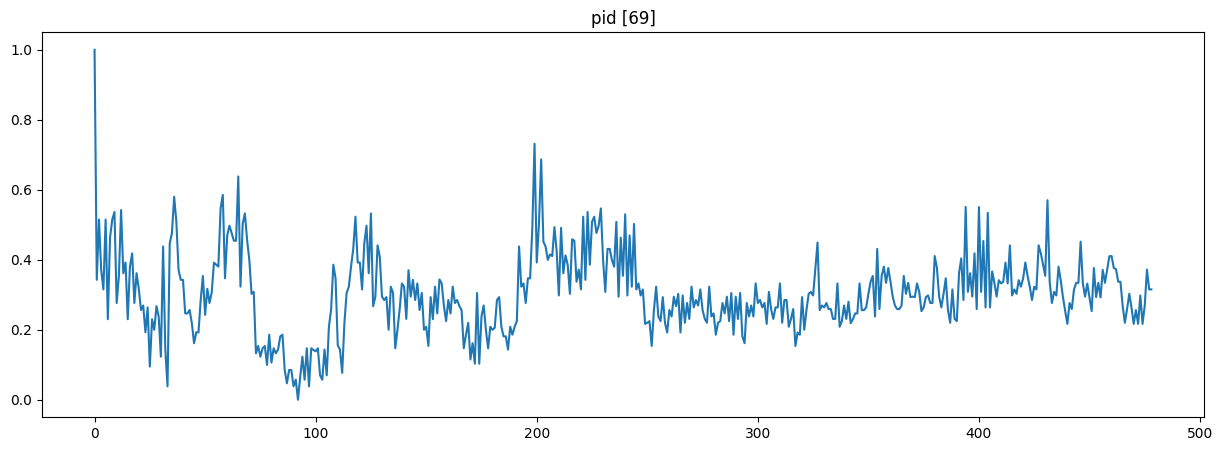

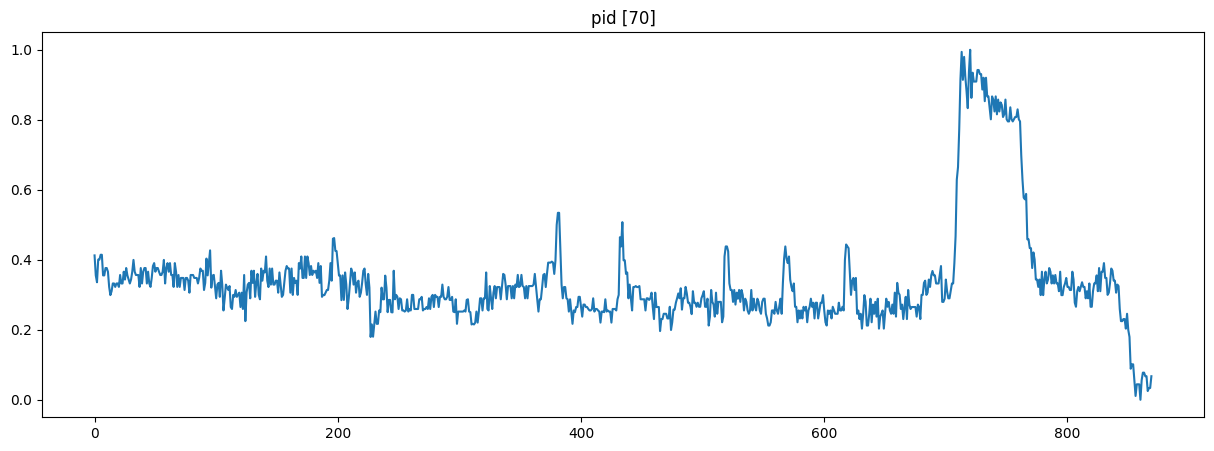

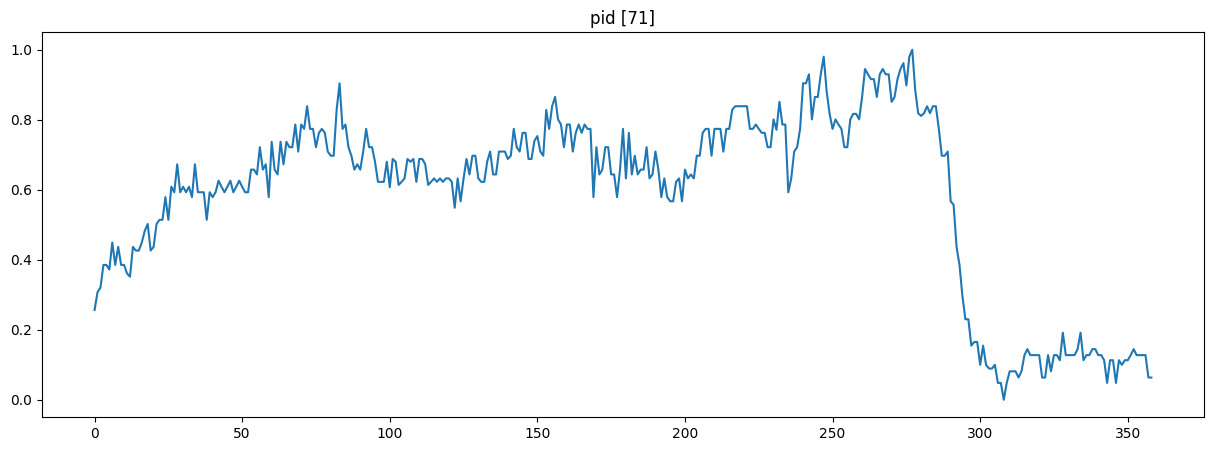

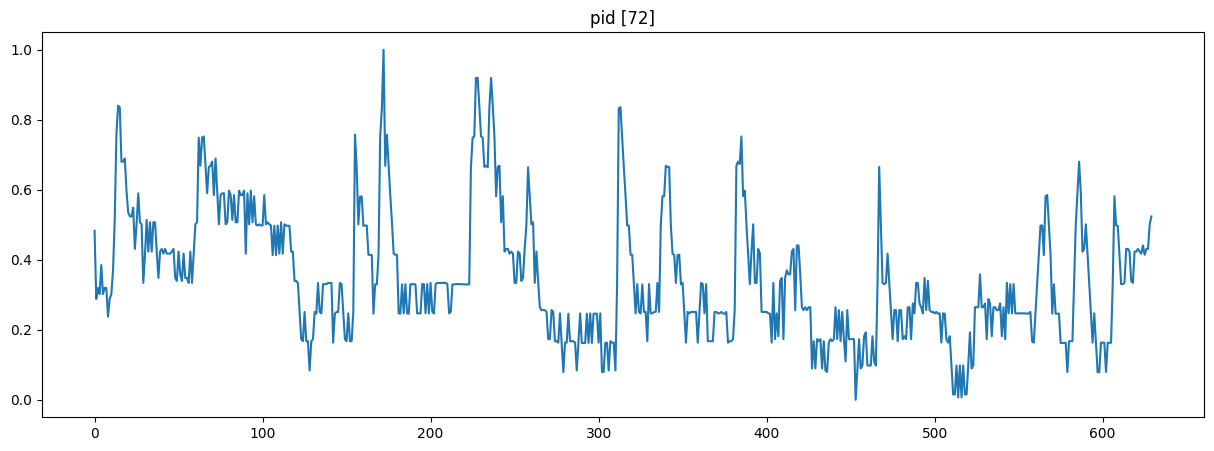

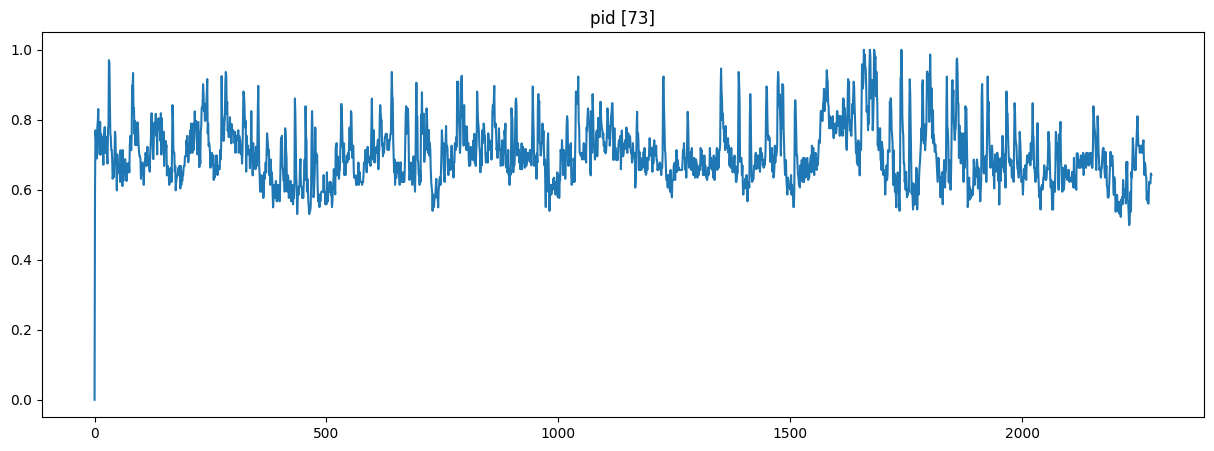

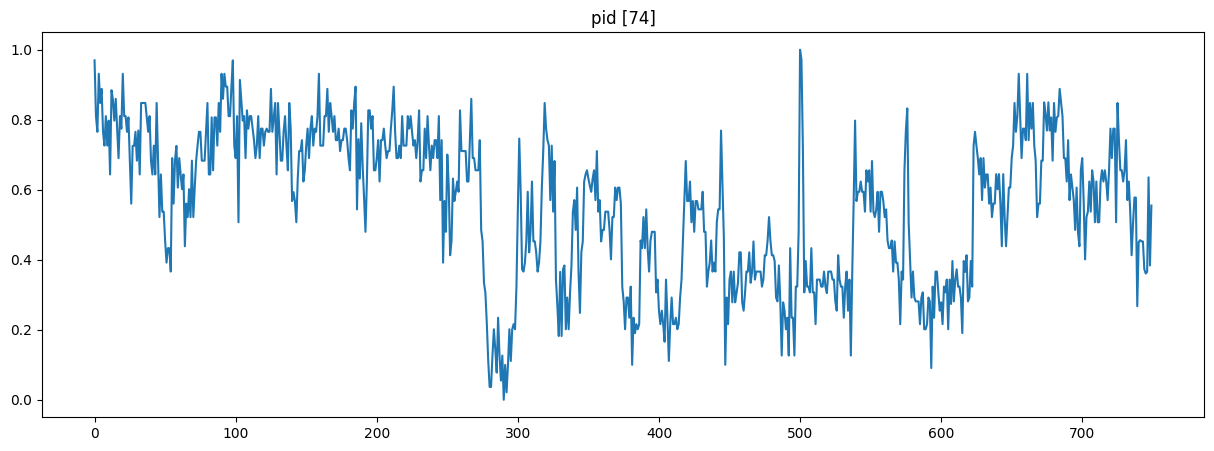

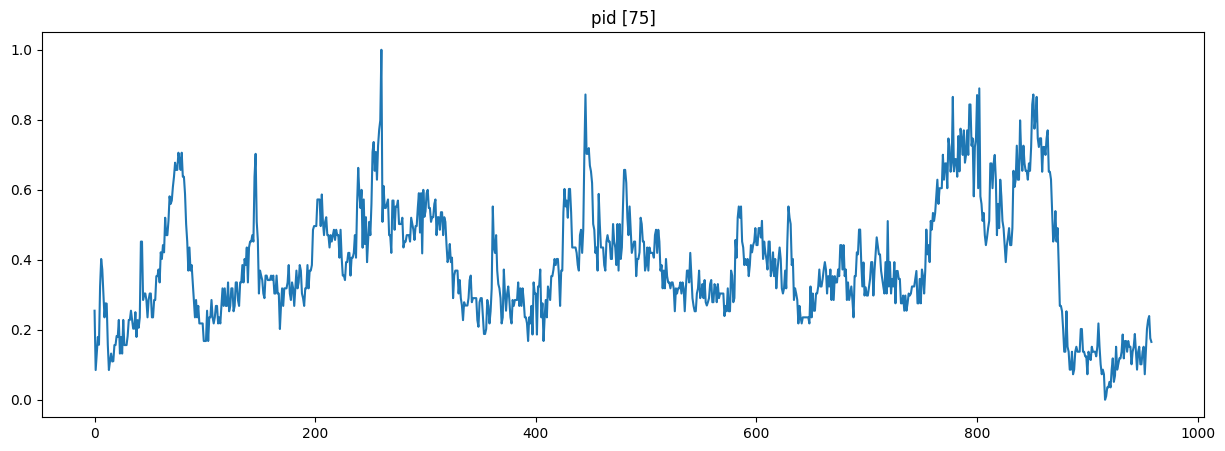

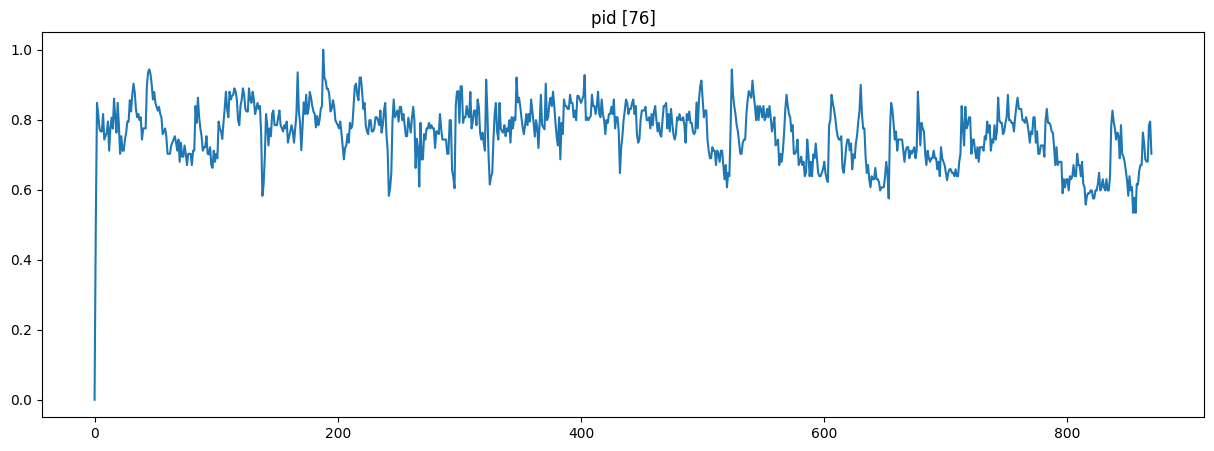

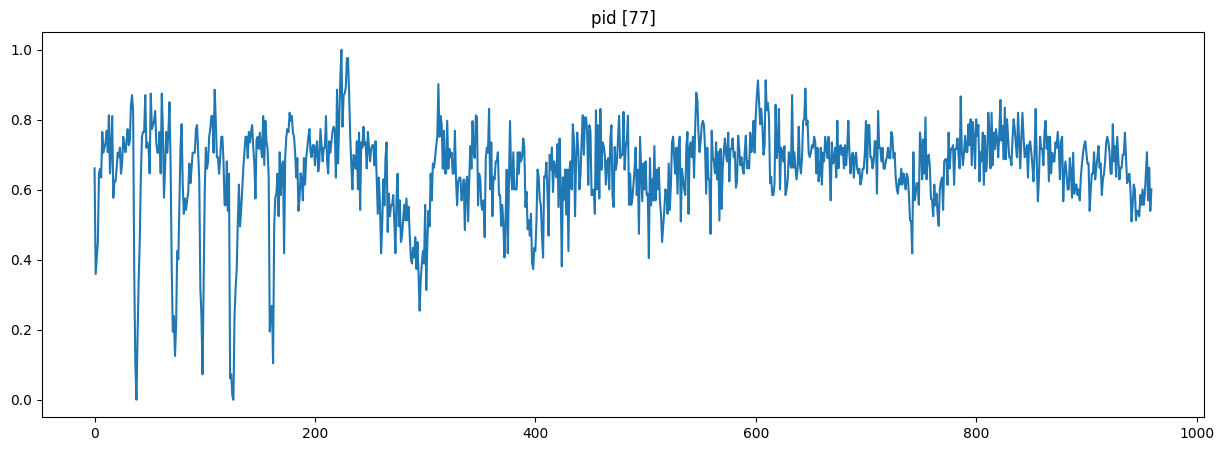

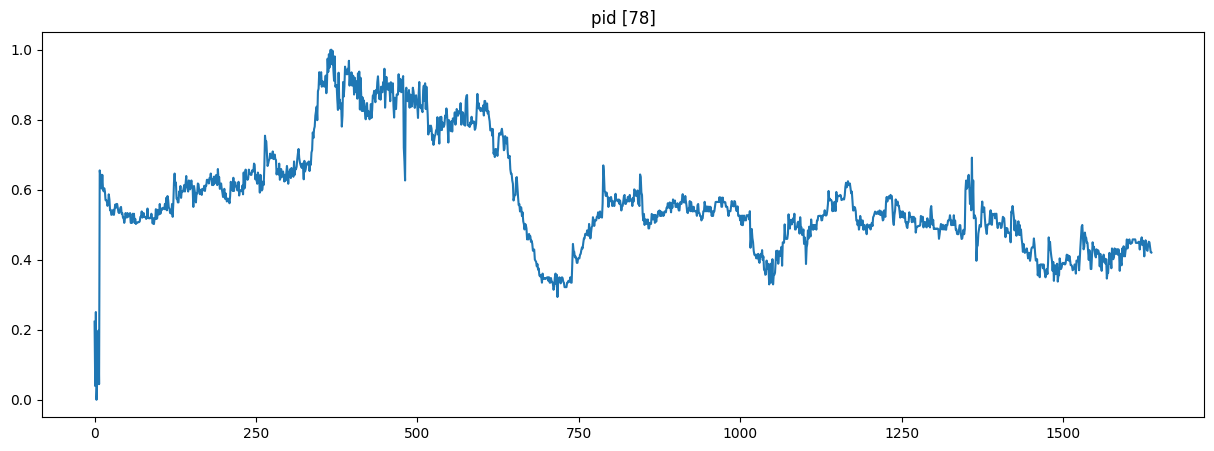

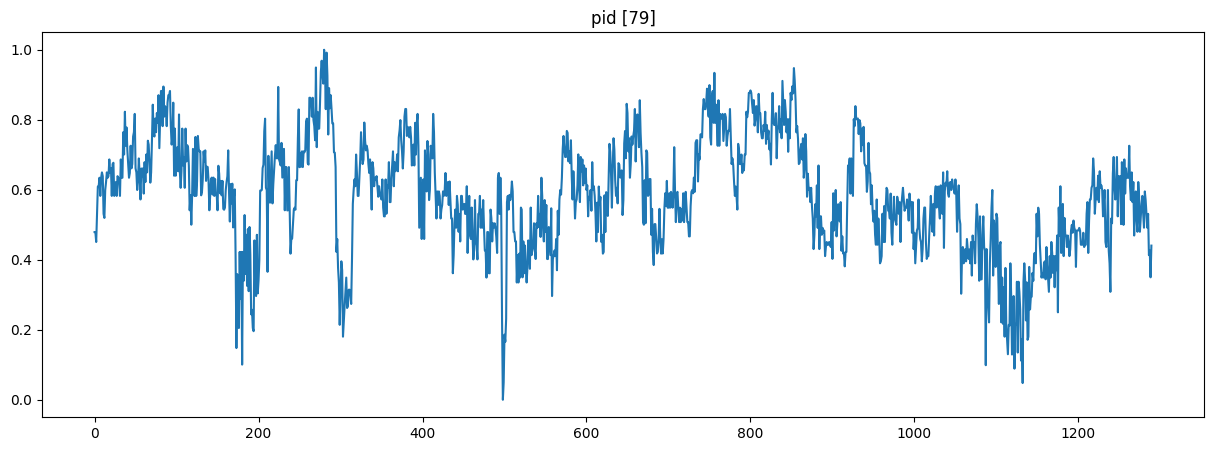

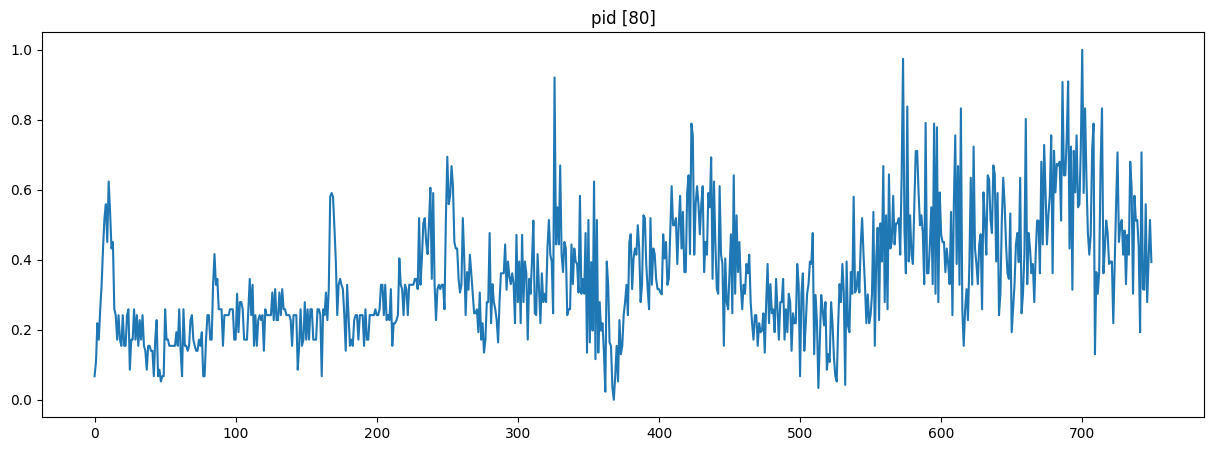

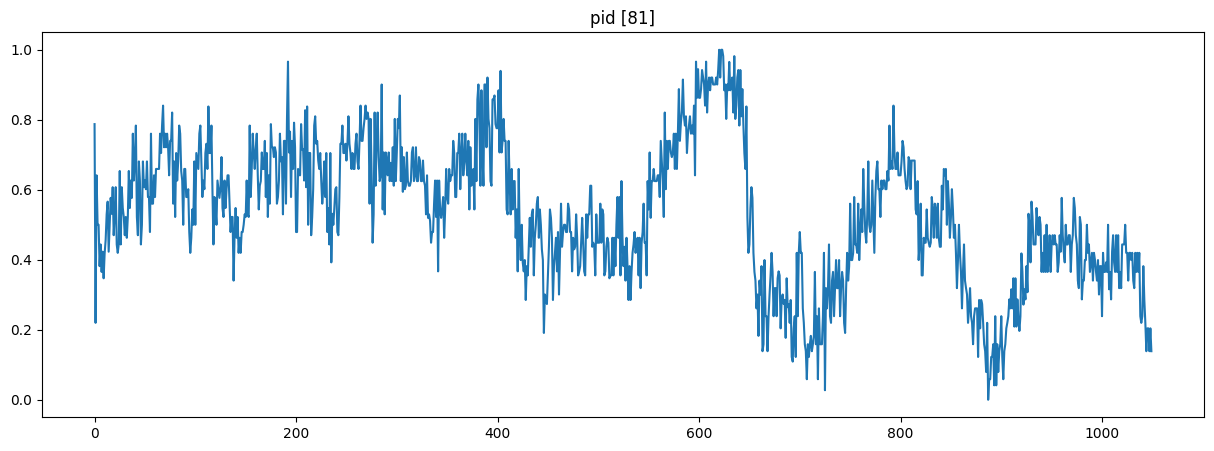

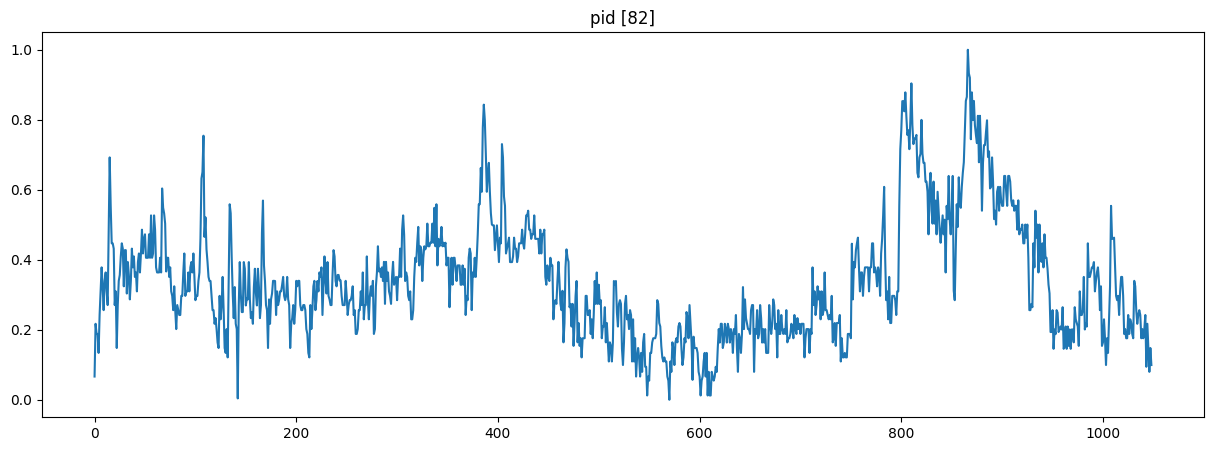

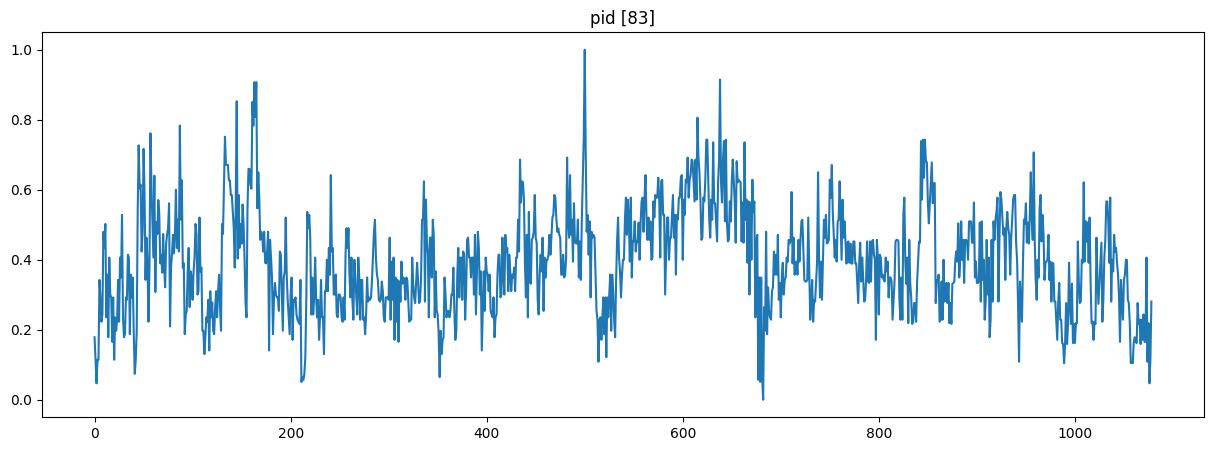

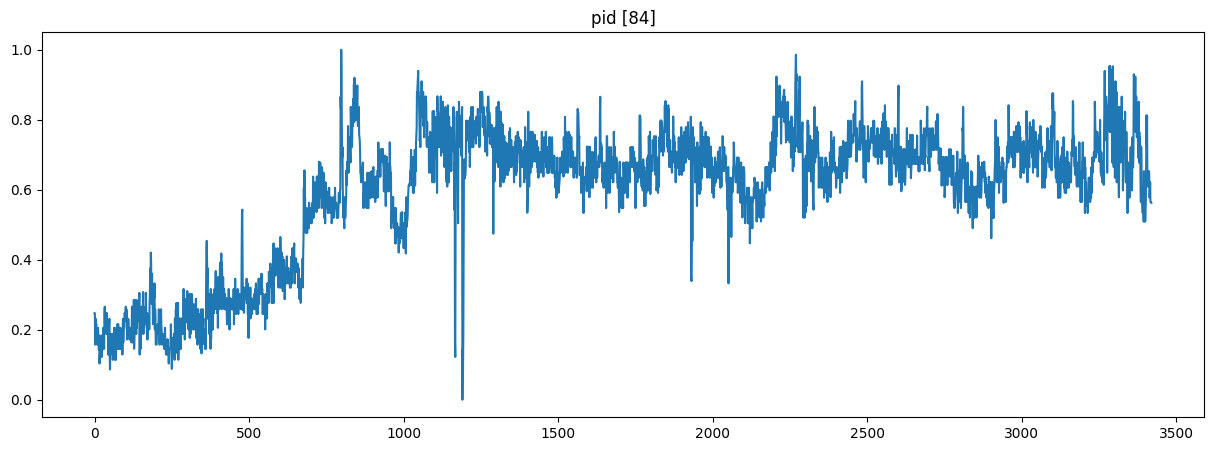

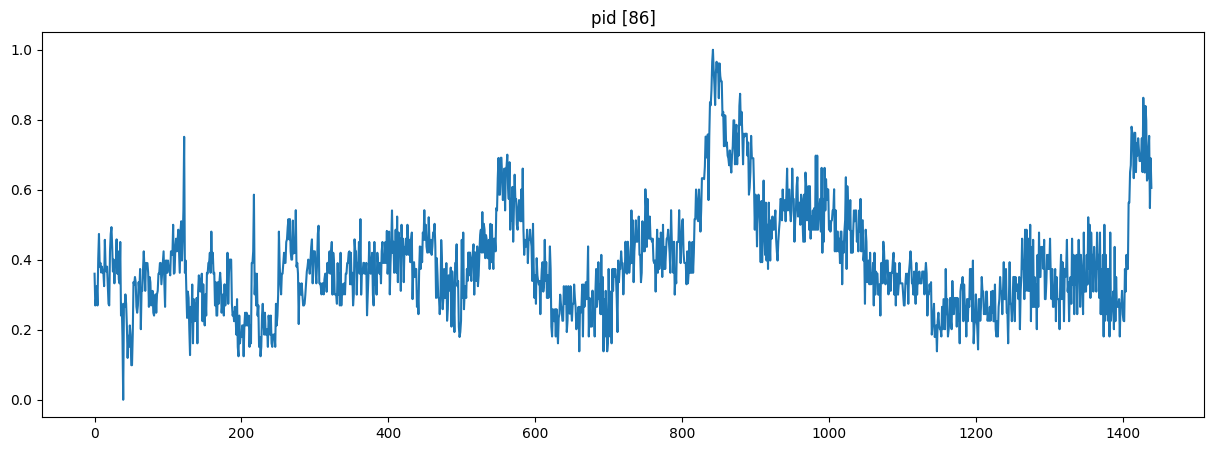

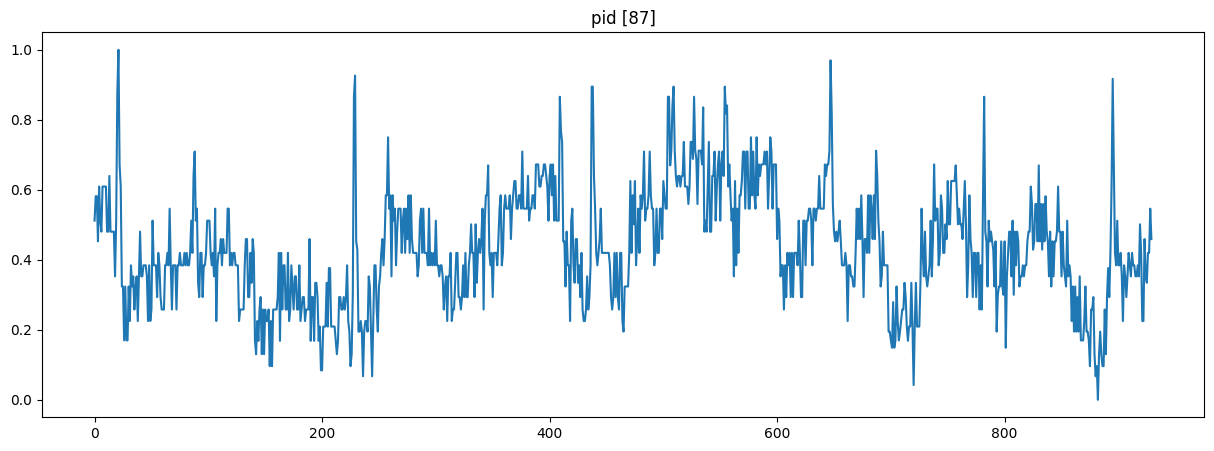

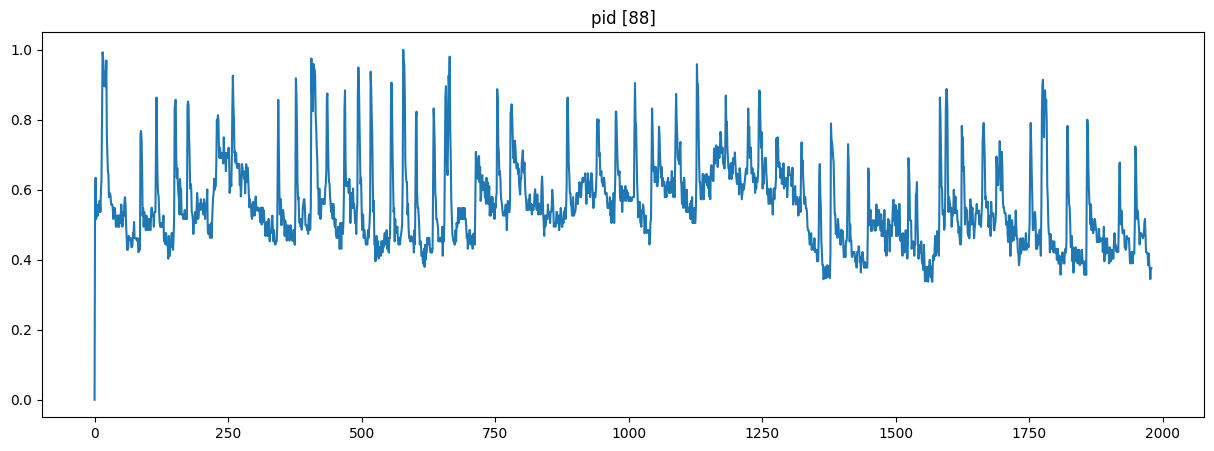

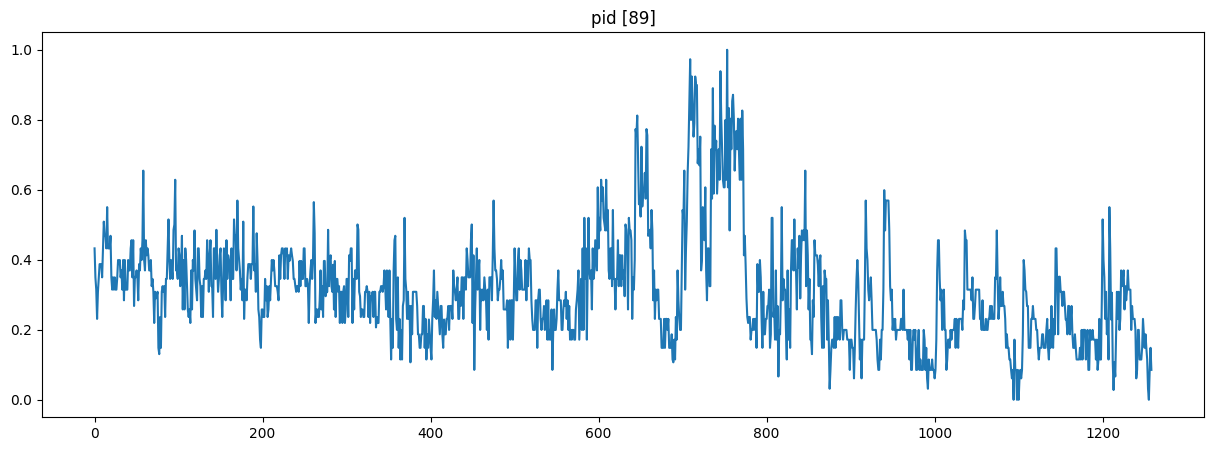

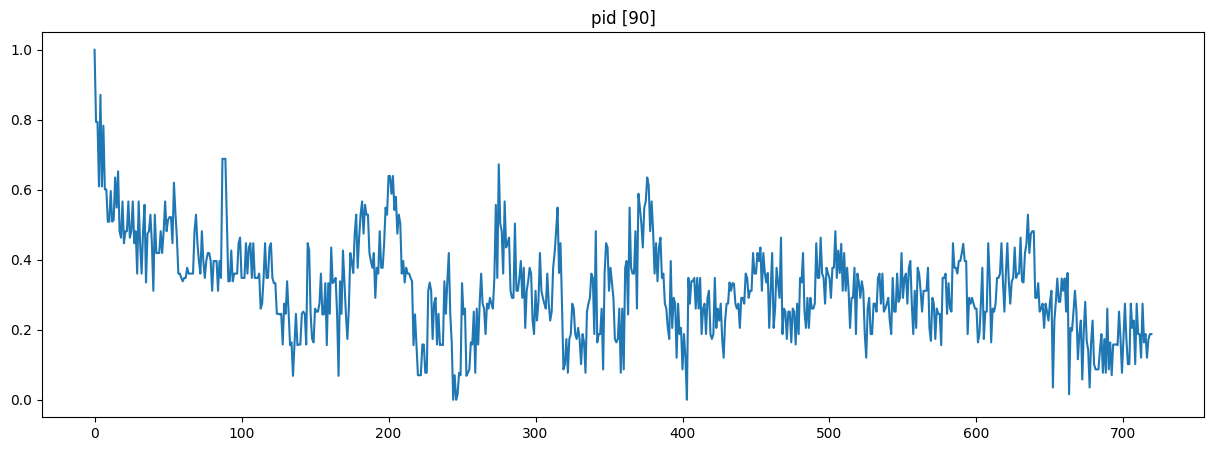

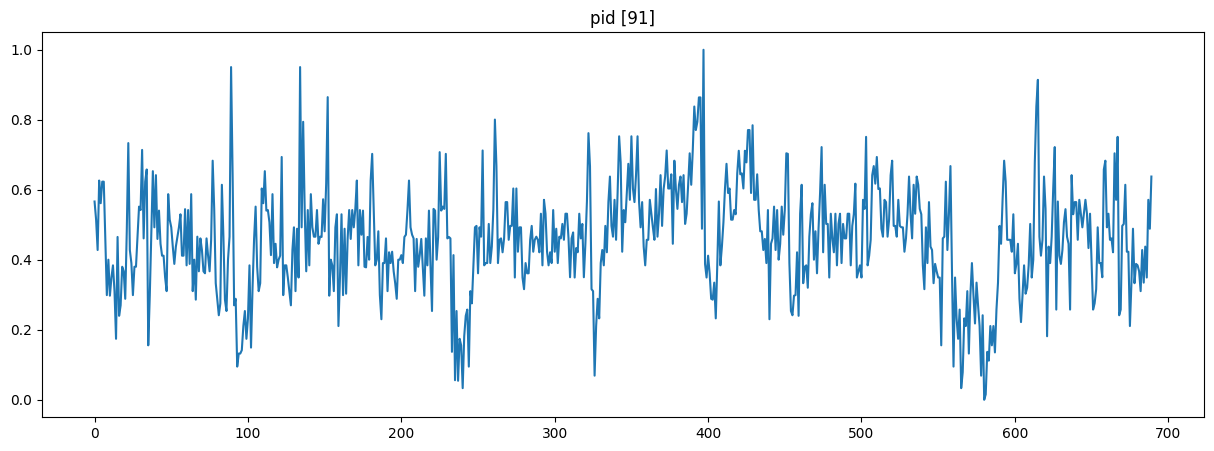

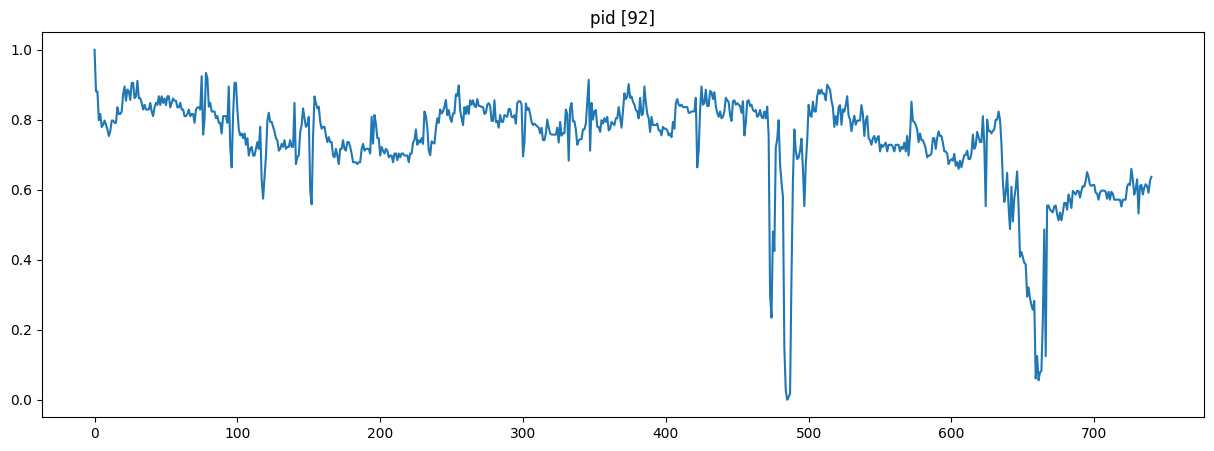

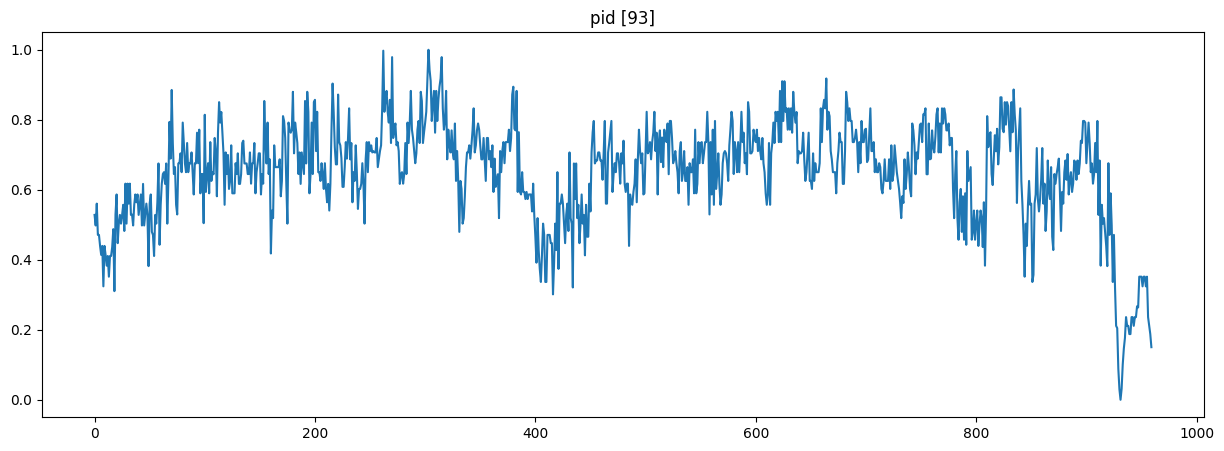

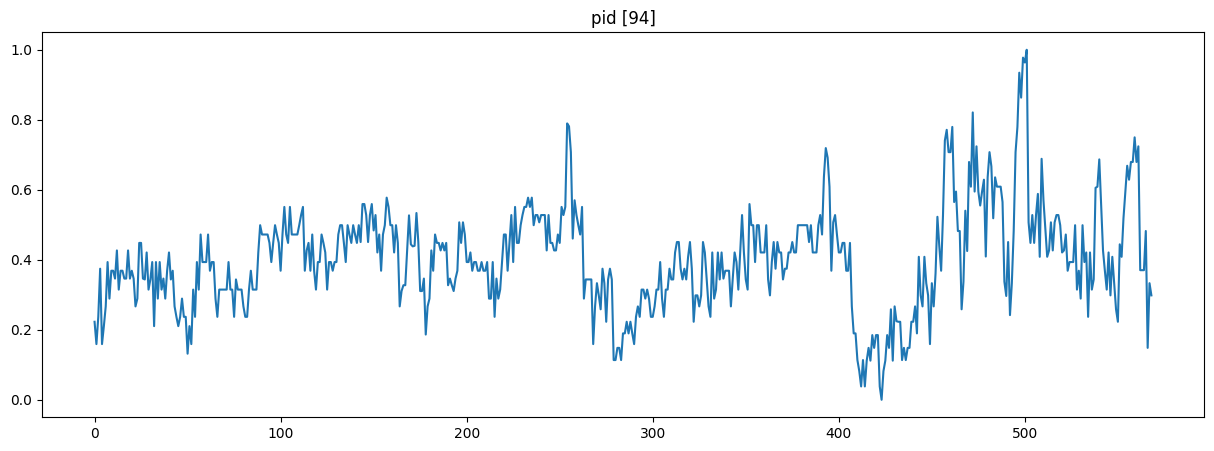

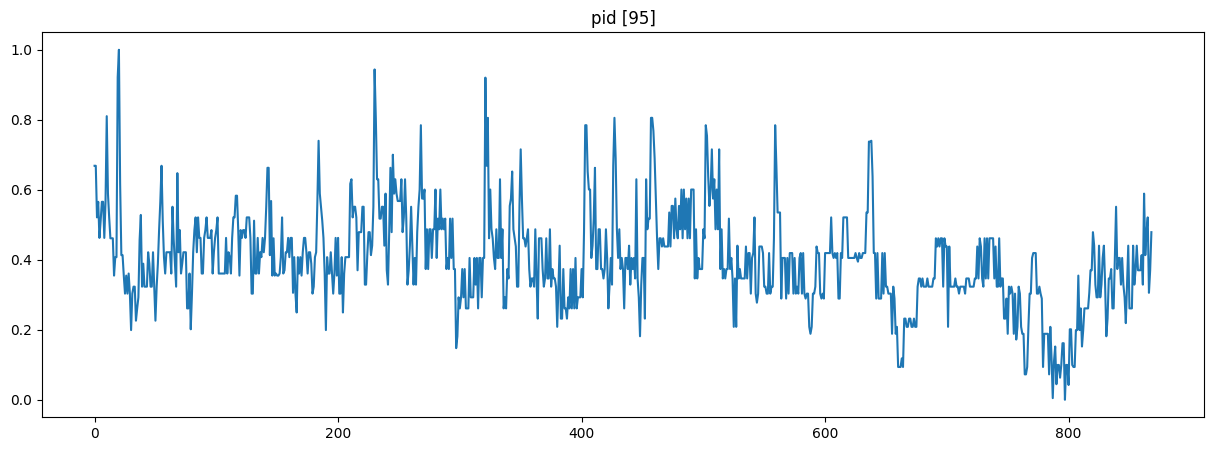

In [57]:
plot_feature_distribution_onePid(feature_data, idx_pid_mapping_dict)

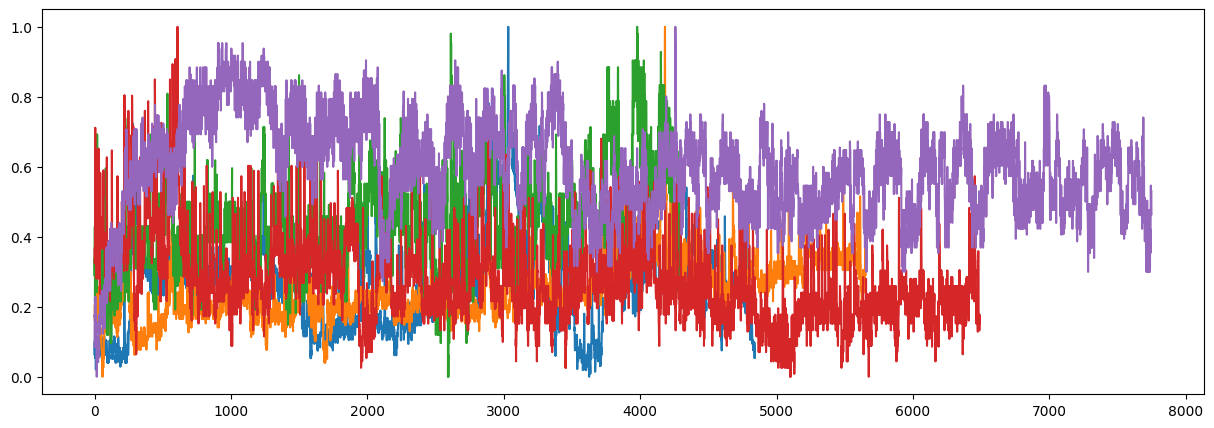

In [30]:
plot_feature_distribution_allPid(feature_data)

# Generate Time Series Data [Smooth First]
* get eyes coordinate data
* change y-coordinate
* smooth
* get time series data

## Raw data

In [14]:
def landmarks_detection(image, results, isDraw=False):
    imgHeight, imgWidth= image.shape[:2]
    # list[(x,y), (x,y)....]: the list of tuples for each landmarks 
    mesh_coord = [(int(point.x * imgWidth), int(point.y * imgHeight)) for point in results.multi_face_landmarks[0].landmark]
    if isDraw:
        [cv2.circle(image, p, 2, COLOR_GREEN, -1) for p in mesh_coord]
    return mesh_coord


def get_coordinate_data(coords):
    n_landmarks = len(coords)
    ### [Left] Eye = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
    pt1_x, pt1_y = coords[398][0], coords[398][1]
    pt2_x, pt2_y = coords[362][0], coords[362][1]
    pt3_x, pt3_y = coords[382][0], coords[382][1]
    pt4_x, pt4_y = coords[374][0], coords[374][1]
    pt5_x, pt5_y = coords[249][0], coords[249][1]
    pt6_x, pt6_y = coords[263][0], coords[263][1]
    pt7_x, pt7_y = coords[466][0], coords[466][1]
    pt8_x, pt8_y = coords[386][0], coords[386][1]

    ### [Right] Eye = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246]
    pt9_x, pt9_y   = coords[173][0], coords[173][1]
    pt10_x, pt10_y = coords[133][0], coords[133][1]
    pt11_x, pt11_y = coords[155][0], coords[155][1]
    pt12_x, pt12_y = coords[145][0], coords[145][1]
    pt13_x, pt13_y = coords[7][0], coords[7][1]
    pt14_x, pt14_y = coords[33][0], coords[33][1]
    pt15_x, pt15_y = coords[246][0], coords[246][1]
    pt16_x, pt16_y = coords[159][0], coords[159][1]
    
    data = [pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x, pt4_y, pt5_x, pt5_y, pt6_x, pt6_y, pt7_x, pt7_y, pt8_x, pt8_y, 
            pt9_x, pt9_y, pt10_x, pt10_y, pt11_x, pt11_y, pt12_x, pt12_y, pt13_x, pt13_y, pt14_x, pt14_y, pt15_x, pt15_y, pt16_x, pt16_y]
    return data


def get_raw_coordinate_data(pidList):
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        for pid in pidList:
            # if pid=='01':
            if pid >= '01':
            # if pid > '59':
                video_path = VIDEOROOT + pid + '/Description1/clip1.mp4'
                csv_output_path = VIDEOROOT + pid + '/Description1_20240314/1_raw_coordinate_data.csv'

                if os.path.exists(VIDEOROOT + pid + '/Description1_20240314/')==False:
                    os.mkdir(VIDEOROOT + pid + '/Description1_20240314/')

                if not os.path.exists(video_path):
                    print(f'====== Pid [{pid}] clip1 does NOT exist. ======')
                else:
                    print(f'[Pid {pid}] {video_path}, {csv_output_path}')

                    ### Load Video [Description 1] ------------------------------------------------------
                    cap = cv2.VideoCapture(video_path)
                    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    frameWidth, frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    FPS = cap.get(cv2.CAP_PROP_FPS)

                    cnt_no_face = 0
                    canWriteCSV = True
                    dataList = []
                    for frame in tqdm(range(n_frames), total=n_frames):
                        ret, image = cap.read()
                        if ret == False:
                            break
                        results = face_mesh.process(image)
                        if results.multi_face_landmarks:
                            meshCoord = landmarks_detection(image, results, False)
                            data = get_coordinate_data(meshCoord)
                            dataList.append(data)
                        else:
                            cnt_no_face += 1
                            if cnt_no_face > 10*30 and canWriteCSV==True: ### 10 seconds
                                invalidID_list.append(pid)
                                print(f'[Info] pid {pid} - no face detected.')
                                canWriteCSV = False
                                break
                    cap.release()
                    cv2.destroyAllWindows()
                    if canWriteCSV == True:
                        with open(csv_output_path, 'w', newline='') as outfile:
                            csv_writer = csv.writer(outfile)
                            csv_writer.writerows(dataList)


get_raw_coordinate_data(allID_list)

[Pid 01] data/01/Description1/clip1.mp4, data/01/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1590/1590 [00:18<00:00, 85.04it/s]


[Pid 02] data/02/Description1/clip1.mp4, data/02/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1170/1170 [00:13<00:00, 86.59it/s]


[Pid 03] data/03/Description1/clip1.mp4, data/03/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:12<00:00, 84.35it/s]


[Pid 04] data/04/Description1/clip1.mp4, data/04/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:13<00:00, 86.64it/s]


[Pid 05] data/05/Description1/clip1.mp4, data/05/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:17<00:00, 85.30it/s]


[Pid 06] data/06/Description1/clip1.mp4, data/06/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 690/690 [00:08<00:00, 85.62it/s]


[Pid 07] data/07/Description1/clip1.mp4, data/07/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 690/690 [00:07<00:00, 86.91it/s]


[Pid 08] data/08/Description1/clip1.mp4, data/08/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [00:06<00:00, 83.69it/s]


[Pid 09] data/09/Description1/clip1.mp4, data/09/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:05<00:00, 87.91it/s]


[Pid 10] data/10/Description1/clip1.mp4, data/10/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 690/690 [00:07<00:00, 86.97it/s]


[Pid 100] data/100/Description1/clip1.mp4, data/100/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:21<00:00, 70.86it/s]


[Pid 11] data/11/Description1/clip1.mp4, data/11/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:05<00:00, 86.58it/s]


[Pid 12] data/12/Description1/clip1.mp4, data/12/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:12<00:00, 85.85it/s]


[Pid 13] data/13/Description1/clip1.mp4, data/13/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 3690/3690 [00:43<00:00, 85.61it/s]


[Pid 14] data/14/Description1/clip1.mp4, data/14/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [00:07<00:00, 87.17it/s]


[Pid 15] data/15/Description1/clip1.mp4, data/15/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1290/1290 [00:15<00:00, 84.42it/s]


[Pid 16] data/16/Description1/clip1.mp4, data/16/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:15<00:00, 93.65it/s]


[Pid 17] data/17/Description1/clip1.mp4, data/17/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1590/1590 [00:18<00:00, 84.76it/s]


[Pid 18] data/18/Description1/clip1.mp4, data/18/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 870/870 [00:10<00:00, 86.42it/s]


[Pid 19] data/19/Description1/clip1.mp4, data/19/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:22<00:00, 85.84it/s]


[Pid 20] data/20/Description1/clip1.mp4, data/20/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:11<00:00, 84.51it/s]


[Pid 21] data/21/Description1/clip1.mp4, data/21/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:11<00:00, 86.02it/s]


[Pid 22] data/22/Description1/clip1.mp4, data/22/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:11<00:00, 86.69it/s]


[Pid 23] data/23/Description1/clip1.mp4, data/23/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:13<00:00, 84.93it/s]


[Pid 24] data/24/Description1/clip1.mp4, data/24/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 4560/4560 [00:53<00:00, 84.93it/s]


[Pid 25] data/25/Description1/clip1.mp4, data/25/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 870/870 [00:10<00:00, 86.39it/s]


[Pid 26] data/26/Description1/clip1.mp4, data/26/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1320/1320 [00:15<00:00, 85.35it/s]


[Pid 27] data/27/Description1/clip1.mp4, data/27/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:14<00:00, 86.73it/s]


[Pid 28] data/28/Description1/clip1.mp4, data/28/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [00:09<00:00, 85.89it/s]


[Pid 29] data/29/Description1/clip1.mp4, data/29/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [00:09<00:00, 84.16it/s]


[Pid 30] data/30/Description1/clip1.mp4, data/30/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:15<00:00, 86.68it/s]


[Pid 31] data/31/Description1/clip1.mp4, data/31/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1890/1890 [00:22<00:00, 84.49it/s]


[Pid 32] data/32/Description1/clip1.mp4, data/32/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:20<00:00, 83.29it/s]


[Pid 33] data/33/Description1/clip1.mp4, data/33/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 3240/3240 [00:38<00:00, 84.26it/s]


[Pid 34] data/34/Description1/clip1.mp4, data/34/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [00:08<00:00, 86.91it/s]


[Pid 35] data/35/Description1/clip1.mp4, data/35/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1380/1380 [00:16<00:00, 86.14it/s]


[Pid 36] data/36/Description1/clip1.mp4, data/36/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 570/570 [00:06<00:00, 84.64it/s]


[Pid 37] data/37/Description1/clip1.mp4, data/37/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:10<00:00, 86.01it/s]


[Pid 38] data/38/Description1/clip1.mp4, data/38/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 86.31it/s]


[Pid 39] data/39/Description1/clip1.mp4, data/39/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:05<00:00, 86.70it/s]


[Pid 40] data/40/Description1/clip1.mp4, data/40/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:08<00:00, 85.31it/s]


[Pid 42] data/42/Description1/clip1.mp4, data/42/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [00:09<00:00, 84.80it/s]


[Pid 43] data/43/Description1/clip1.mp4, data/43/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:13<00:00, 85.30it/s]


[Pid 44] data/44/Description1/clip1.mp4, data/44/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1170/1170 [00:13<00:00, 85.73it/s]


[Pid 45] data/45/Description1/clip1.mp4, data/45/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 2310/2310 [00:27<00:00, 84.48it/s]


[Pid 46] data/46/Description1/clip1.mp4, data/46/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:11<00:00, 83.80it/s]


[Pid 47] data/47/Description1/clip1.mp4, data/47/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:04<00:00, 83.48it/s]


[Pid 48] data/48/Description1/clip1.mp4, data/48/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:14<00:00, 84.84it/s]


[Pid 49] data/49/Description1/clip1.mp4, data/49/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:10<00:00, 86.12it/s]


[Pid 50] data/50/Description1/clip1.mp4, data/50/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 780/780 [00:09<00:00, 83.79it/s]


[Pid 51] data/51/Description1/clip1.mp4, data/51/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 3030/3030 [00:35<00:00, 85.34it/s]


[Pid 52] data/52/Description1/clip1.mp4, data/52/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 86.81it/s]


[Pid 53] data/53/Description1/clip1.mp4, data/53/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:12<00:00, 72.16it/s]


[Pid 54] data/54/Description1/clip1.mp4, data/54/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:15<00:00, 70.44it/s]


[Pid 55] data/55/Description1/clip1.mp4, data/55/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:13<00:00, 70.70it/s]


[Pid 56] data/56/Description1/clip1.mp4, data/56/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:14<00:00, 71.77it/s]


[Pid 57] data/57/Description1/clip1.mp4, data/57/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 840/840 [00:12<00:00, 69.97it/s]


[Pid 58] data/58/Description1/clip1.mp4, data/58/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:28<00:00, 71.68it/s]


[Pid 59] data/59/Description1/clip1.mp4, data/59/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 77.19it/s]


[Pid 60] data/60/Description1/clip1.mp4, data/60/Description1_20240314/1_raw_coordinate_data.csv


 10%|███████▋                                                                      | 300/3060 [00:01<00:14, 186.38it/s]


[Info] pid 60 - no face detected.
[Pid 61] data/61/Description1/clip1.mp4, data/61/Description1_20240314/1_raw_coordinate_data.csv


 28%|█████████████████████▋                                                        | 300/1080 [00:01<00:04, 160.46it/s]


[Info] pid 61 - no face detected.
[Pid 62] data/62/Description1/clip1.mp4, data/62/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:27<00:00, 70.26it/s]


[Pid 63] data/63/Description1/clip1.mp4, data/63/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 3930/3930 [00:55<00:00, 70.61it/s]


[Pid 64] data/64/Description1/clip1.mp4, data/64/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:22<00:00, 70.82it/s]


[Pid 65] data/65/Description1/clip1.mp4, data/65/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:25<00:00, 71.90it/s]


[Pid 66] data/66/Description1/clip1.mp4, data/66/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 2550/2550 [00:36<00:00, 70.42it/s]


[Pid 67] data/67/Description1/clip1.mp4, data/67/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1170/1170 [00:16<00:00, 71.57it/s]


[Pid 68] data/68/Description1/clip1.mp4, data/68/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [00:07<00:00, 72.87it/s]


[Pid 69] data/69/Description1/clip1.mp4, data/69/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:06<00:00, 72.24it/s]


[Pid 70] data/70/Description1/clip1.mp4, data/70/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 870/870 [00:12<00:00, 70.37it/s]


[Pid 71] data/71/Description1/clip1.mp4, data/71/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [00:04<00:00, 72.31it/s]


[Pid 72] data/72/Description1/clip1.mp4, data/72/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [00:09<00:00, 69.02it/s]


[Pid 73] data/73/Description1/clip1.mp4, data/73/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 2280/2280 [00:32<00:00, 70.23it/s]


[Pid 74] data/74/Description1/clip1.mp4, data/74/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 69.72it/s]


[Pid 75] data/75/Description1/clip1.mp4, data/75/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:13<00:00, 71.08it/s]


[Pid 76] data/76/Description1/clip1.mp4, data/76/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 870/870 [00:12<00:00, 70.98it/s]


[Pid 77] data/77/Description1/clip1.mp4, data/77/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:13<00:00, 70.22it/s]


[Pid 78] data/78/Description1/clip1.mp4, data/78/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:23<00:00, 72.10it/s]


[Pid 79] data/79/Description1/clip1.mp4, data/79/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1290/1290 [00:18<00:00, 69.38it/s]


[Pid 80] data/80/Description1/clip1.mp4, data/80/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 71.58it/s]


[Pid 81] data/81/Description1/clip1.mp4, data/81/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:15<00:00, 68.25it/s]


[Pid 82] data/82/Description1/clip1.mp4, data/82/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:14<00:00, 71.30it/s]


[Pid 83] data/83/Description1/clip1.mp4, data/83/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:15<00:00, 70.34it/s]


[Pid 84] data/84/Description1/clip1.mp4, data/84/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 3420/3420 [00:48<00:00, 70.21it/s]


[Pid 85] data/85/Description1/clip1.mp4, data/85/Description1_20240314/1_raw_coordinate_data.csv


 47%|█████████████████████████████████████▎                                          | 378/810 [00:03<00:04, 97.65it/s]


[Info] pid 85 - no face detected.
[Pid 86] data/86/Description1/clip1.mp4, data/86/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:21<00:00, 68.35it/s]


[Pid 87] data/87/Description1/clip1.mp4, data/87/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:12<00:00, 71.95it/s]


[Pid 88] data/88/Description1/clip1.mp4, data/88/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1980/1980 [00:28<00:00, 69.57it/s]


[Pid 89] data/89/Description1/clip1.mp4, data/89/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:17<00:00, 71.52it/s]


[Pid 90] data/90/Description1/clip1.mp4, data/90/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:10<00:00, 71.60it/s]


[Pid 91] data/91/Description1/clip1.mp4, data/91/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 690/690 [00:09<00:00, 71.54it/s]


[Pid 92] data/92/Description1/clip1.mp4, data/92/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 71.57it/s]


[Pid 93] data/93/Description1/clip1.mp4, data/93/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:13<00:00, 69.84it/s]


[Pid 94] data/94/Description1/clip1.mp4, data/94/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 570/570 [00:08<00:00, 70.05it/s]


[Pid 95] data/95/Description1/clip1.mp4, data/95/Description1_20240314/1_raw_coordinate_data.csv


100%|████████████████████████████████████████████████████████████████████████████████| 870/870 [00:12<00:00, 70.13it/s]


[Pid 96] data/96/Description1/clip1.mp4, data/96/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:14<00:00, 70.23it/s]


[Pid 97] data/97/Description1/clip1.mp4, data/97/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 1860/1860 [00:26<00:00, 69.88it/s]


[Pid 98] data/98/Description1/clip1.mp4, data/98/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 2370/2370 [00:33<00:00, 70.40it/s]


[Pid 99] data/99/Description1/clip1.mp4, data/99/Description1_20240314/1_raw_coordinate_data.csv


100%|██████████████████████████████████████████████████████████████████████████████| 2580/2580 [00:36<00:00, 70.16it/s]


### Problem List: 60, 61, 85

In [15]:
# invalidID_list = ["60", "61", "85"]
print(f'invalidID_list: {invalidID_list}')

invalidID_list: ['60', '60', '61', '85']


## Change y-coordinate

In [18]:
def change_y_coordinate(pidList, invalidList):
    for pid in pidList:
        if pid not in invalidList:
            # if pid=='01':
            if pid > '01':
                csv_file = KeypointsROOT + pid + '/Description1_20240314/1_raw_coordinate_data.csv'
                csv_file_output = KeypointsROOT + pid + '/Description1_20240314/2_change_y_data.csv'
                
                videoType = videoType_dict[int(pid)]['type']
                if videoType == 1:
                    frameHeight = 480
                elif videoType == 2:
                    frameHeight = 720
    
                if not os.path.exists(csv_file):
                    print(f'[{pid}] csv file does not exist.')
                else:
                    df = pd.read_csv(csv_file, header=None)
                    print(f'pid: {pid}, {csv_file}, videoType: {videoType}, output: {csv_file_output}')
                    n_row, n_col = df.shape[0], df.shape[1]

                    cnt = 0
    
                    for rowIdx in range(n_row):
                        for colIdx in range(n_col):
                            if colIdx%2==1:
                                value = df.iloc[rowIdx, colIdx]
                                df.iloc[rowIdx, colIdx] = frameHeight - value
                                cnt += 1
                    df.to_csv(csv_file_output, index=False, header=False)



change_y_coordinate(allID_list, invalidID_list)

pid: 02, data/02/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/02/Description1_20240314/2_change_y_data.csv
pid: 03, data/03/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/03/Description1_20240314/2_change_y_data.csv
pid: 04, data/04/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/04/Description1_20240314/2_change_y_data.csv
pid: 05, data/05/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/05/Description1_20240314/2_change_y_data.csv
pid: 06, data/06/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/06/Description1_20240314/2_change_y_data.csv
pid: 07, data/07/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/07/Description1_20240314/2_change_y_data.csv
pid: 08, data/08/Description1_20240314/1_raw_coordinate_data.csv, videoType: 1, output: data/08/Description1_20240314/2_change_y_data.csv
pid: 09, data/09/Description1_2024

## Time Series Data (Smooth)

In [31]:
def smooth_coordinate(df):
    n_rows, n_cols = df.shape[0], df.shape[1]

    resultArray_smooth = []
    for i in range(n_cols):
        x = df.iloc[:, i].values
        x_smooth = savgol_filter(x, window_length=31, polyorder=10)
        x_smooth = np.round(x_smooth, 2)
        resultArray_smooth.append(x_smooth)

        # plt.figure(figsize=(15, 5))
        # plt.plot(x, 'r')
        # plt.plot(x_smooth, 'b')
        # plt.show()

    smooth_data = []
    resultArray = np.array(resultArray_smooth)
    nFrames = resultArray.shape[1]
    for i in range(nFrames):
        smooth_data.append([resultArray[0][i], resultArray[1][i], resultArray[2][i], resultArray[3][i],
                            resultArray[4][i], resultArray[5][i], resultArray[6][i], resultArray[7][i],
                            resultArray[8][i], resultArray[9][i], resultArray[10][i], resultArray[11][i], 
                            resultArray[12][i], resultArray[13][i], resultArray[14][i], resultArray[15][i], 
                            resultArray[16][i], resultArray[17][i], resultArray[18][i], resultArray[19][i], 
                            resultArray[20][i], resultArray[21][i], resultArray[22][i], resultArray[23][i], 
                            resultArray[24][i], resultArray[25][i], resultArray[26][i], resultArray[27][i], 
                            resultArray[28][i], resultArray[29][i], resultArray[30][i], resultArray[31][i]
                            ])
    smooth_data = np.array(smooth_data)
    df_smooth = pd.DataFrame(smooth_data)
    return df_smooth


def generate_timeSeries_data(pidList, invalidList):
    for pid in pidList:
        if pid not in invalidList:
            # if pid=='01':
            if pid > '01':
                csv_file = KeypointsROOT + pid + '/Description1_20240314/2_change_y_data.csv'
                csv_file_output = KeypointsROOT + pid + '/Description1_20240314/3_timeSeries_smooth.csv'
    
                if not os.path.exists(csv_file):
                    print(f'[{pid}] csv file does not exist.')
                else:
                    df = pd.read_csv(csv_file, header=None)
                    n_row, n_col = df.shape[0], df.shape[1]

                    df = smooth_coordinate(df)

                    df_new = pd.DataFrame()

                    lEye_pt1_x, lEye_pt2_x, lEye_pt3_x = [], [], []
                    lEye_pt1_y, lEye_pt2_y, lEye_pt3_y = [], [], []
                    rEye_pt1_x, rEye_pt2_x, rEye_pt3_x = [], [], []
                    rEye_pt1_y, rEye_pt2_y, rEye_pt3_y = [], [], []
                    for i in range(n_row):
                        pt1_x, pt1_y = df.iloc[[i], [0]].values[0][0], df.iloc[[i], [1]].values[0][0] ### [Left Eye]
                        pt2_x, pt2_y = df.iloc[[i], [2]].values[0][0], df.iloc[[i], [3]].values[0][0]
                        pt3_x, pt3_y = df.iloc[[i], [4]].values[0][0], df.iloc[[i], [5]].values[0][0]
                        pt4_x, pt4_y = df.iloc[[i], [6]].values[0][0], df.iloc[[i], [7]].values[0][0]
                        pt5_x, pt5_y = df.iloc[[i], [8]].values[0][0], df.iloc[[i], [9]].values[0][0]
                        pt6_x, pt6_y = df.iloc[[i], [10]].values[0][0], df.iloc[[i], [11]].values[0][0]
                        pt7_x, pt7_y = df.iloc[[i], [12]].values[0][0], df.iloc[[i], [13]].values[0][0]
                        pt8_x, pt8_y = df.iloc[[i], [14]].values[0][0], df.iloc[[i], [15]].values[0][0]
                    
                        pt9_x, pt9_y   = df.iloc[[i], [16]].values[0][0], df.iloc[[i], [17]].values[0][0] ### [Right Eye]
                        pt10_x, pt10_y = df.iloc[[i], [18]].values[0][0], df.iloc[[i], [19]].values[0][0]
                        pt11_x, pt11_y = df.iloc[[i], [20]].values[0][0], df.iloc[[i], [21]].values[0][0]
                        pt12_x, pt12_y = df.iloc[[i], [22]].values[0][0], df.iloc[[i], [23]].values[0][0]
                        pt13_x, pt13_y = df.iloc[[i], [24]].values[0][0], df.iloc[[i], [25]].values[0][0]
                        pt14_x, pt14_y = df.iloc[[i], [26]].values[0][0], df.iloc[[i], [27]].values[0][0]
                        pt15_x, pt15_y = df.iloc[[i], [28]].values[0][0], df.iloc[[i], [29]].values[0][0]
                        pt16_x, pt16_y = df.iloc[[i], [30]].values[0][0], df.iloc[[i], [31]].values[0][0]

                        lEye_pt1_x.append(round((pt1_x+pt2_x+pt3_x)/3, 2))
                        lEye_pt2_x.append(round((pt4_x+pt8_x)/2, 2))
                        lEye_pt3_x.append(round((pt5_x+pt6_x+pt7_x)/3, 2))
                        lEye_pt1_y.append(round((pt1_y+pt2_y+pt3_y)/3, 2))
                        lEye_pt2_y.append(round((pt4_y+pt8_y)/2, 2))
                        lEye_pt3_y.append(round((pt5_y+pt6_y+pt7_y)/3, 2))
                        rEye_pt1_x.append(round((pt9_x+pt10_x+pt11_x)/3, 2))
                        rEye_pt2_x.append(round((pt12_x+pt16_x)/2, 2))
                        rEye_pt3_x.append(round((pt13_x+pt14_x+pt15_x)/3, 2))
                        rEye_pt1_y.append(round((pt9_y+pt10_y+pt11_y)/3, 2))
                        rEye_pt2_y.append(round((pt12_y+pt16_y)/2, 2))
                        rEye_pt3_y.append(round((pt13_y+pt14_y+pt15_y)/3, 2))
                        
                    feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                                         'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
                    coord_value_list = [lEye_pt1_x, lEye_pt1_y, lEye_pt2_x, lEye_pt2_y, lEye_pt3_x, lEye_pt3_y, 
                                        rEye_pt1_x, rEye_pt1_y, rEye_pt2_x, rEye_pt2_y, rEye_pt3_x, rEye_pt3_y]
                    for featureIdx, feature in enumerate(feature_name_list):
                        df_new.insert(featureIdx, feature, coord_value_list[featureIdx])
                    print(f'[Pid {pid}] output: {csv_file_output}')
                    df_new.to_csv(csv_file_output, index=None, header=None)
                        

generate_timeSeries_data(allID_list, invalidID_list)

[Pid 02] output: data/02/Description1_20240314/3_timeSeries_smooth.csv
[Pid 03] output: data/03/Description1_20240314/3_timeSeries_smooth.csv
[Pid 04] output: data/04/Description1_20240314/3_timeSeries_smooth.csv
[Pid 05] output: data/05/Description1_20240314/3_timeSeries_smooth.csv
[Pid 06] output: data/06/Description1_20240314/3_timeSeries_smooth.csv
[Pid 07] output: data/07/Description1_20240314/3_timeSeries_smooth.csv
[Pid 08] output: data/08/Description1_20240314/3_timeSeries_smooth.csv
[Pid 09] output: data/09/Description1_20240314/3_timeSeries_smooth.csv
[Pid 10] output: data/10/Description1_20240314/3_timeSeries_smooth.csv
[Pid 100] output: data/100/Description1_20240314/3_timeSeries_smooth.csv
[Pid 11] output: data/11/Description1_20240314/3_timeSeries_smooth.csv
[Pid 12] output: data/12/Description1_20240314/3_timeSeries_smooth.csv
[Pid 13] output: data/13/Description1_20240314/3_timeSeries_smooth.csv
[Pid 14] output: data/14/Description1_20240314/3_timeSeries_smooth.csv
[Pid